In [43]:
# This is the main code for Entropy-Aesthetics research

from selenium import webdriver
import math
import pickle
import uuid
import copy
import numpy as np
import pandas as pd
from functools import reduce

from PIL import Image, ImageDraw

from scipy.cluster.vq import *
from scipy.misc import imresize
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import os
import sys

import collections
import csv

import base64
import cv2
from skimage import img_as_ubyte
from skimage.filters import rank
from skimage.morphology import  disk
from skimage.feature import canny

import scipy.spatial as spatial
from unittest import TestCase

from io import StringIO
from io import BytesIO

In [44]:
prefix = "file:///Users/chenwang/Documents/Manuscript/Entropy_Aesthetic/Aesthetic/source/"

windowWidth = 1900
windowHeight = 900

# Aliaksei's setting
# windowWidth = 1280
# windowHeight = 800

In [45]:
infiles = [
    
    '0*theboneandjointcenter.com',
    '1*theborneopost.com',
    '2*two-n.com',
    '3*swellnet.com',
    '4*klex.ru',    
    '5*disney.co.jp',
    '6*wikipedia.org',
    '7*news.yahoo.co.jp',
    '8*huxiu.com',
    '9*chi2019.acm.org',    
    '10*cheshi.com',
    '11*humblebundle.com',
    '12*theatlantic.com',
    '13*cvpr2018.thecvf.com',   
    '14*microsoft.com',
    '15*opera.com',
    '16*labinthewild.org',
    '17*macg.co',    
    '18*richyli.com',
    '19*pxtoem.com', 
    '20*dna.fr',    
    '21*javadrive.jp',
    '22*jcr.incites.thomsonreuters.com',
    '23*infoq.com',    
    '24*jiqimao.tv',
    '25*clamav.net',
    '26*bootcdn.cn',
    '27*runoob.com',
    '28*tensorfly.cn',
    '29*journaldugeek.com', 
    '30*matetranslate.com',
    '31*kameisyouten.ocnk.net',
    '32*gingerweb.jp',
    '33*cp.pocky.jp',
    '34*aladdin-aic.com',
    '35*trafst.jp',
    '36*cps.com.cn',
    '37*techplay.jp',    
    '38*kokage-m.com',
    '39*tech-camp.in',
    '40*hasegawa-heart.com',    
    '41*steakland.jp',
    '42*showroomprive.com',
    '43*imas-cg.net',
    '44*filetender.com',
    '45*hexo.io',
    '46*yinwang.org',
    '47*blog.yitianshijie.net',
    '48*yatani.jp',
    '49*qiita.com',
    '50*52nlp.cn',
    '51*guidetojapanese.org',
    '52*olderadults.mobi',
    '53*blog.whatsapp.com',
    '54*tech-jp.co.jp',
    '56*sankei.com',
    '55*lomake.fi',
    '57*bgmaimuna.com',
    '58*0dt.net',
    '59*web.ics.purdue.edu',
    '60*canon-foundation.jp',
    '61*tech.nikkeibp.co.jp',
    '62*jp.techcrunch.com',
    '63*capcom.co.jp',
    '64*blog.sciencenet.cn',
    '65*pantone.com',
    '66*cerezo.jp',
    '67*news.livedoor.com',
    '68*gmo.jp',
    '69*tokai-tv.com', 
    '70*life-is-tech.com',
    '71*bloomberg.co.jp'
    
    
    # The source code of these webpages have problems
    #'999*ted.com',
    #'1*mozilla.org',
    #'3*segmentfault.com',
    #'4*makeitok.org',
    #'9*fangdd.com',
    #'13*superprof.fr',
    #'17*nounplus.net',
    #'20*goofy.photo',
    #'22*jcodecraeer.com',
    #'23*hdpfans.com',
    #'35*ho-ginza.net',
    #'36*pandayori.com',
    #'37*sekimoto.dental',
    #'39*coming-saji.com',
    #'40*bluewood.bitter.jp',
    #'54*stratechery.com',
    #'56*theclinic.cl',
    #'61*docs.opencv.org',
    #'62*interaction-design.org',
    #'63*jlpt.jp',
    #'66*sdtech.co.jp',
    #'76*kenkun-jinja.org', 
    #'82*ubejinja.or.jp',
    #'83*19lou.com',
    #'84*jiankang.com',
    #'86*hea.cn',
    #'87*jfc.or.jp',
    #'90*secure.j-bus.co.jp',
    #'98*kudago.com',

]

In [46]:
# For Webpage Element-based Segmentation
# Node - Processing DOM element from Selenium 

def findParent(node):
    return node.find_element_by_xpath('./parent::*')

def findChildren(node):
    return node.find_elements_by_xpath('./child::*') 

def getLoop(node):
    n = node.find_elements_by_xpath('./ancestor::*')
    loop = len(n) - 2
    return loop

class Node():
    def __init__(self, node):
        self.uuid = uuid.uuid1()
        self.me = node
        self.parent = findParent(node)
        self.tag = node.tag_name
        self.text = node.text
        self.font_size = node.value_of_css_property('font-size')
        self.float = node.value_of_css_property("float")
        self.top = node.location['y']
        self.left = node.location['x']
        self.width = node.size['width']
        self.height = node.size['height']
        self.background_image = node.value_of_css_property('background-image')
        self.background_color = node.value_of_css_property('background-color')
        self.display = node.value_of_css_property('display')
        
        self.p = 0
        self.mark = 0
        
def getNodePosition(node):
    # print("***", node.left, node.top, node.width, node.height)
    
    if node.top + node.height > windowHeight:
        node.height = windowHeight - node.top
    
    xy = [(node.left, node.top),
          (node.left + node.width, node.top),
          (node.left + node.width, node.top + node.height),
          (node.left, node.top + node.height),
          (node.left, node.top)
         ]
    
    # print(node.left, node.top, node.width, node.height)
    return xy

def getElementPosition(element):
    # print("***", element[0], element[1], element[2], element[3])
    
    if element[1] + element[3] > windowHeight:
        element[3] = windowHeight - element[1]
        
    xy = [(element[0], element[1]),
          (element[0] + element[2], element[1]),
          (element[0] + element[2], element[1] + element[3]),
          (element[0], element[1] + element[3]),
          (element[0], element[1])
         ]
    
    return xy

In [47]:
# For Webpage Element-based Segmentation

def segmentation(title):
    childStack = []
    generalStack = []
    parentStack = []
    url = prefix + title + "/" + title + ".html"
    driver.get(url)
    
    try:
        element = driver.find_element_by_xpath(path)
        generalStack.append(element)
    except Exception as e:
        print("Error: " + str(e))
    
    # Due to the processing problems, only processing the first two or three DOM levels
    loopMarker = 2
    
    while generalStack:
        currentElement = generalStack.pop()
        # print(currentElement.tag_name, "&", currentElement.get_attribute("class"))
        if findChildren(currentElement) and getLoop(currentElement) < loopMarker:
            parentStack.append(currentElement)
            for child in findChildren(currentElement)[::-1]:
                generalStack.append(child)
        else:
            node = Node(currentElement)
            childStack.append(node)
            # print(childStack)
    # print(childStack)
    # and x.width >= 19 * 5 and x.height >= 9 * 5
    
    # Drop Exceptions
    childStack = list(filter(lambda x: x.top >= 0 and x.top < windowHeight and x.left >= 0 and x.left < windowWidth, childStack))
    childStack = list(filter(lambda x: x.width != 0 and x.height != 0, childStack))
    childStack = list(filter(lambda x: x.width >= 19*3 and x.height >= 9*3, childStack))
    childStack = list(sorted(childStack, key=lambda x: math.sqrt(x.width**2 + x.height**2)))
    return childStack

In [48]:
# For Webpage Pixel-based Segmentation

def read_b64_img(b64):
    img = base64.b64decode(b64)
    #img = cv2.imread(b64)
    #img = cv2.resize(img, (windowWidth, windowHeight))
    npimg = np.fromstring(img, dtype=np.uint8)
    return cv2.imdecode(npimg, 1)

class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        # (x1, y1) is the upper left corner,
        # (x2, y2) is the lower right corner,  
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def taxicab_diagonal(self):
        return self.x2 - self.x1 + self.y2 - self.y1

    def overlaps(self, other):
        # Return True if self and other overlap.        
        return not ((self.x1 > other.x2) or (self.x2 < other.x1) or (self.y1 > other.y2) or (self.y2 < other.y1))

def makeClassFromCont(contours):
    bboxes = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if w < 5 or h < 5: 
            continue
        bboxes.append(BBox(x, y, x+w, y+h))
    return bboxes

def remove_overlaps(contours):
    #This function returns a set of bboxes after removing the overlapping contours
    bboxes = makeClassFromCont(contours)
    
    corners = []
    ulcorners = []

    # dict mapping corners to Bboxes.
    bbox_map = {}

    for bbox in bboxes:
        ul = (bbox.x1, bbox.y1)
        lr = (bbox.x2, bbox.y2)
        bbox_map[ul] = bbox
        bbox_map[lr] = bbox
        ulcorners.append(ul)
        corners.append(ul)
        corners.append(lr)        

    try:
        tree = spatial.KDTree(np.asarray(corners))
    except Exception:
        return 0
    for corner in ulcorners:
        bbox = bbox_map[corner]
        # Find all points which are within a taxicab distance of corner
        indices = tree.query_ball_point(corner, bbox_map[corner].taxicab_diagonal(), p = 1)
        for near_corner in tree.data[indices]:
            near_bbox = bbox_map[tuple(near_corner)]
            if bbox != near_bbox and bbox.overlaps(near_bbox):
                # Expand both the bboxes
                bbox.x1 = near_bbox.x1 = min(bbox.x1, near_bbox.x1)
                bbox.y1 = near_bbox.y1 = min(bbox.y1, near_bbox.y1) 
                bbox.x2 = near_bbox.x2 = max(bbox.x2, near_bbox.x2)
                bbox.y2 = near_bbox.y2 = max(bbox.y2, near_bbox.y2) 
    return set(bbox_map.values())

def get_elements(b64, detailed=True, preview=True):
    img_bgr = read_b64_img(b64)
    img_out = np.copy(img_bgr)

    contours_all_v, contours_all_h = segment(img_bgr, h_blur=13, v_blur=9)

    thickness = 1
    if detailed:
        contours_all = contours_all_h
    else:
        contours_all = contours_all_v
        thickness = 2

    offset, offset1 = 3, 5

    elements = []
    N = len(contours_all)
    for i, c in zip(range(N), contours_all):
        x, y, w, h = cv2.boundingRect(c)

        if w <= 15:
            continue
        if h <= 10:
            continue

        img_out = cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 0, 255), thickness)

        ele_b64 = base64.b64encode(cv2.imencode(".png", img_bgr[y:y+h, x:x+w])[1])

        elements.append({
            "id": i,
            "tag": "",
            "x_position": x,
            "y_position": y,
            "width": w,
            "height": h,
            "b64": ele_b64
        })

    result = {
        "elements": elements
    }

    if preview:
        b64 = base64.b64encode(cv2.imencode(".png", img_out)[1])
        result["preview"] = b64

    return result

def segment(img_bgr, h_blur=13, v_blur=9):
    BW = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(BW, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    denoised = rank.median(BW, disk(5))
    gradient_denoised = rank.gradient(denoised, disk(1))

    gradient_0 = rank.gradient(img_bgr[:, :, 0], disk(1))
    gradient_1 = rank.gradient(img_bgr[:, :, 1], disk(1))
    gradient_2 = rank.gradient(img_bgr[:, :, 2], disk(1))

    sobelx64f = cv2.Sobel(BW, cv2.CV_64F, 1, 0, ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)
    img_canny = canny(BW)

    _, contours_thresh, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, contours_0, _ = cv2.findContours(gradient_0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, contours_1, _ = cv2.findContours(gradient_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, contours_2, _ = cv2.findContours(gradient_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, contours_denoised, _ = cv2.findContours(gradient_denoised, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, contours_sobel, _ = cv2.findContours(sobel_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, contours_canny, _ = cv2.findContours(img_as_ubyte(img_canny), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contours = contours_0 + contours_1 + contours_2 + contours_denoised + contours_sobel + contours_canny

    # bbox = utils.remove_overlaps(contours)
    bbox = 0 # No big bounding box

    temp = np.zeros_like(BW)

    if bbox != 0:
        for bb in bbox:
            temp = cv2.rectangle(temp, (bb.x1, bb.y1), (bb.x2, bb.y2), (255, 255, 255), 1)

    for c in contours_thresh:
        x, y, w, h = cv2.boundingRect(c)
        temp = cv2.rectangle(temp, (x, y), (x + w, y + h), (255, 255, 255), 1)

    # Horizontal Blurring filter
    size = h_blur # 11
    kmb = np.zeros((size, size))
    kmb[int(size / 2), :] = np.ones(size)
    kmb = kmb/size

    # Apply horizontal blurring here
    temp = cv2.filter2D(temp, -1, kmb)
    _, contours_all_h, _ = cv2.findContours(temp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Vertical Blurring filter
    size = v_blur # 13
    kmb = np.zeros((size, size))
    kmb[:, int(size / 2)] = np.ones(size)
    kmb = kmb/size

    # Apply vertical blurring here
    temp = cv2.filter2D(temp, -1, kmb)
    _, contours_all_v, _ = cv2.findContours(temp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    return contours_all_v, contours_all_h

In [49]:
# Mark webpage matrix according to the segmentation result

def markMatrix(childStack, title):
    screenshot = 'webpages/'+ title +'.png'
    imageMatrix_elementStack_pickle[title] = {}
    imageMatrix = np.zeros([windowWidth, windowHeight], int)
    serial = 1
    elementStack = []
    
    with open(screenshot, 'rb') as f:
        impxs = f.read()
    impxs = base64.b64encode(impxs)
    elementpxs = get_elements(impxs, detailed=True)
    
    # Element Segmentation
    for i in childStack:
        elementStack.append([i.left, i.top, i.width, i.height])
    
    # Pixel Segmentation
    for i in elementpxs['elements']:
        elementStack.append([i['x_position'], i['y_position'], i['width'], i['height']])
    
    # print(elementStack)
    
    for i in elementStack:

        for j in range(i[0], i[0]+i[2]):
            if (i[0] + i[2] > windowWidth):
                break
            for k in range(i[1], i[1]+i[3]):
                if (i[1] + i[3] > windowHeight):
                    break
                #if imageMatrix[j,k] == 0:
                imageMatrix[j,k] = serial
        # print(imageMatrix)
        # print(imageMatrix[1899,899])
        serial += 1
    assert serial == len(elementStack) + 1
    # print(serial)
    
    matshow(imageMatrix)

    # print(imageMatrix)
#     imageMatrix_elementStack_pickle[title]['imageMatrix'] = imageMatrix
#     imageMatrix_elementStack_pickle[title]['elementStack'] = elementStack
    return imageMatrix, elementStack

In [50]:
# Visualization

# Webpages
def visualRect(elementStack, title):
    screenshot = Image.open("webpages/" + title + ".png")
    screenshot = screenshot.resize((windowWidth, windowHeight))
    draw = ImageDraw.Draw(screenshot)
    
    for i in elementStack:
        xy = getElementPosition(i)

        draw.line(xy, fill="#FF0000", width=3)

    screenshot.save('test/rg/' + title + "-processed.png")
    
# Tree Plot
def drawPic(title, codeim, Z):
    fig = figure(figsize=(15,15))
    #subplots(1,2,figsize=(15,15))
    ax = fig.add_subplot(121)
    imshow(codeim)
    ax2 = fig.add_subplot(122)
    dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=8.)
    show()
    
    #plot(codeim)
    fig.savefig('test/hg/' + title + '-clustering.png')

In [51]:
# Hierarchical Clustering Threshold Setting 
# max_d = 4.12
max_d = 0.25

# Basic Pixel Block Step, Dimensionality Reduction
steps = 80

# Hierarchical Clustering
def entropyHSVXYClustering(title, segment, steps, w):
    infile = 'webpages/'+ title +'.png'
    im = Image.open(infile)
    # im = im.resize((windowWidth,windowHeight))
    im = array(im.convert('HSV'))
    dx = int(im.shape[0]/steps)
    dy = int(im.shape[1]/steps)
    features = []
    
    sbn = np.bincount(segment.reshape(1, segment.size)[0])
    # print(sbn)
    semanticBlockNum = len(sbn)

    # ***** Clustering & Metrics Normalization ***** 
    for x in range(steps):
        for y in range(steps):
            H = mean(im[x * dx:(x + 1)* dx, y * dy:(y+1) * dy, 0])/256
            S = mean(im[x * dx:(x + 1)* dx, y * dy:(y+1) * dy, 1])/256
            V = mean(im[x * dx:(x + 1)* dx, y * dy:(y+1) * dy, 2])/256
            
            semanticBlock = segment[y * dy:(y + 1) * dy, x * dx:(x + 1)* dx]
            # print(semanticBlock.reshape(1, semanticBlock.size))
            if semanticBlock != [[]]:
                sg = np.argmax(np.bincount(semanticBlock.reshape(1, semanticBlock.size)[0]))
            else:
                sg = 0

#             w1 = 0.33
#             w2 = 0.01
#             w3 = 0.66
            
            features.append([w[0]*H, w[1]*S, w[2]*V, w[3]*(x/steps), w[3]*(y/steps), w[4]*(sg/semanticBlockNum)])
    features = array(features, 'f')
#     with open('test/feature.csv', 'w') as f:
#         writer = csv.writer(f)
#         writer.writerow(['h', 's', 'v', 'x', 'y', 'sg'])
#         writer.writerows(features)
    
    Z = linkage(features, "ward")

    clusters = fcluster(Z, max_d, criterion='distance')
    # print(clusters.max())
    hist = collections.Counter(clusters)
    histData = hist.items()
    setNum = len(set(clusters))
    # print("setNum " + str(setNum))

    codeim = clusters.reshape(steps, steps)
    codeim = imresize(codeim, im.shape[:2], 'nearest')
    # codeim = np.array(Image.fromarray(codeim).resize(im.shape[:-1]))

    return codeim, Z, histData, setNum


# Entropy Computing
entropy_list = []
entropy_dict = {}
# imageMatrix_elementStack_pickle = {}


def entropyComputing(infile, segment, w):
    codeim, Z, histData, setNum = entropyHSVXYClustering(infile, segment, steps, w)
    H = 0
    total = len(Z)
    for i in histData:
        H += (i[1]/total)*math.log((i[1]/total),2)
    return -H, codeim, Z, setNum


# with open('test/imageMatrix_elementStack_pickle.pkl', 'rb') as f:
#     imageMatrix_elementStack_pickle = pickle.load(f)

    
# def main(w, title):
  
#     Already Done Segmentation
#     no, title = infiles[wbIndex].split('*')
#     H, codeim, Z, setNum = entropyComputing(title, imageMatrix_elementStack_pickle[title]['imageMatrix'], w)
#     entropy_list.append([title, H, setNum])
#     entropy_dict[title] = Z    
#     return H


def main(w):     
        
    for i in infiles:
        no, title = i.split('*')
        # Do Segmentation
        try:
            childStack = segmentation(title)
        except Exception as e:
            print("Segmentation Error: " + str(e))
            childStack = []
        finally:    
            imageMatrix, elementStack = markMatrix(childStack, title)
            
            # Computing the number of blocks and their size by counting histgram
            H, codeim, Z, setNum = entropyComputing(title, imageMatrix, w)
            drawPic(title, codeim, Z)
            visualRect(elementStack, title)
            entropy_list.append([title, H, setNum])
            entropy_dict[title] = Z
            print(i, H)    
            
    with open('test/entropy.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['title', 'entropy', 'clustering'])
        writer.writerows(entropy_list)
    with open('test/z.pkl', 'wb') as f:
        pickle.dump(entropy_dict, f)
        
    entropy_list = []
    entropy_dict = {}
        
#         # Writing Segmentation
#     with open('test/imageMatrix_elementStack_pickle.pkl', 'wb') as f:
#         pickle.dump(imageMatrix_elementStack_pickle, f)
         
    return elementStack, imageMatrix



/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


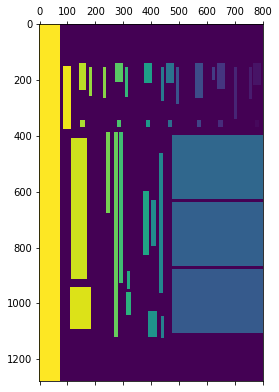

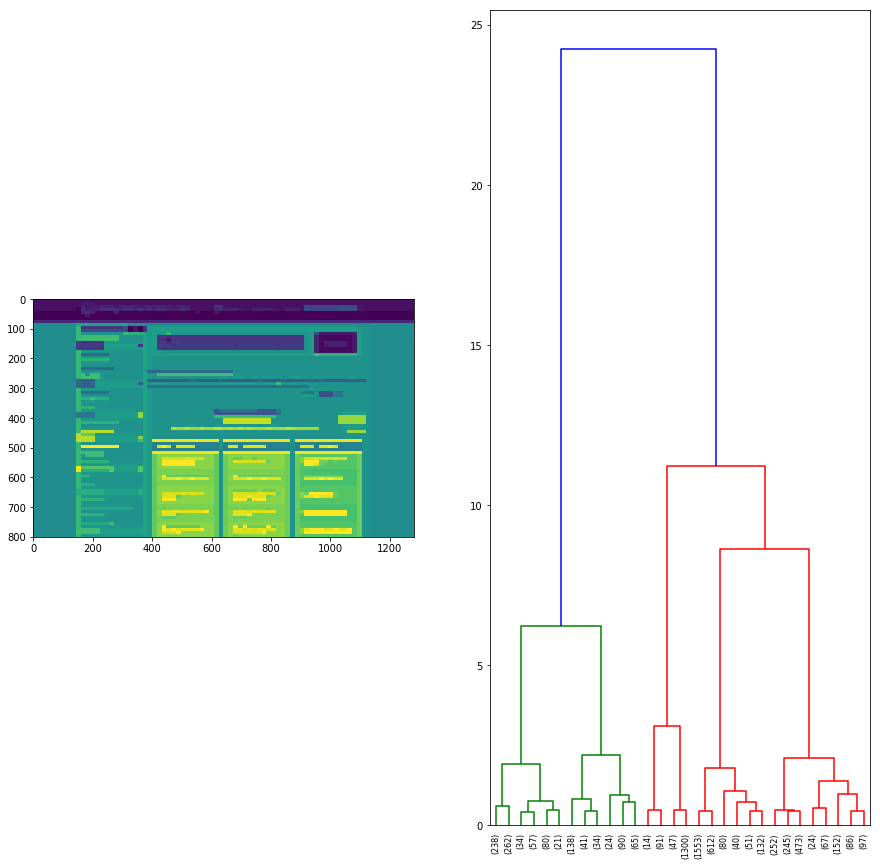

1 4.115998805505731


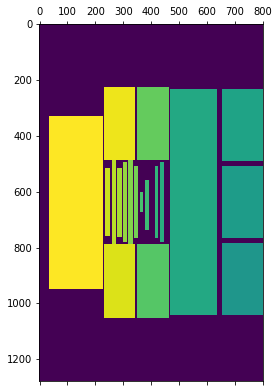

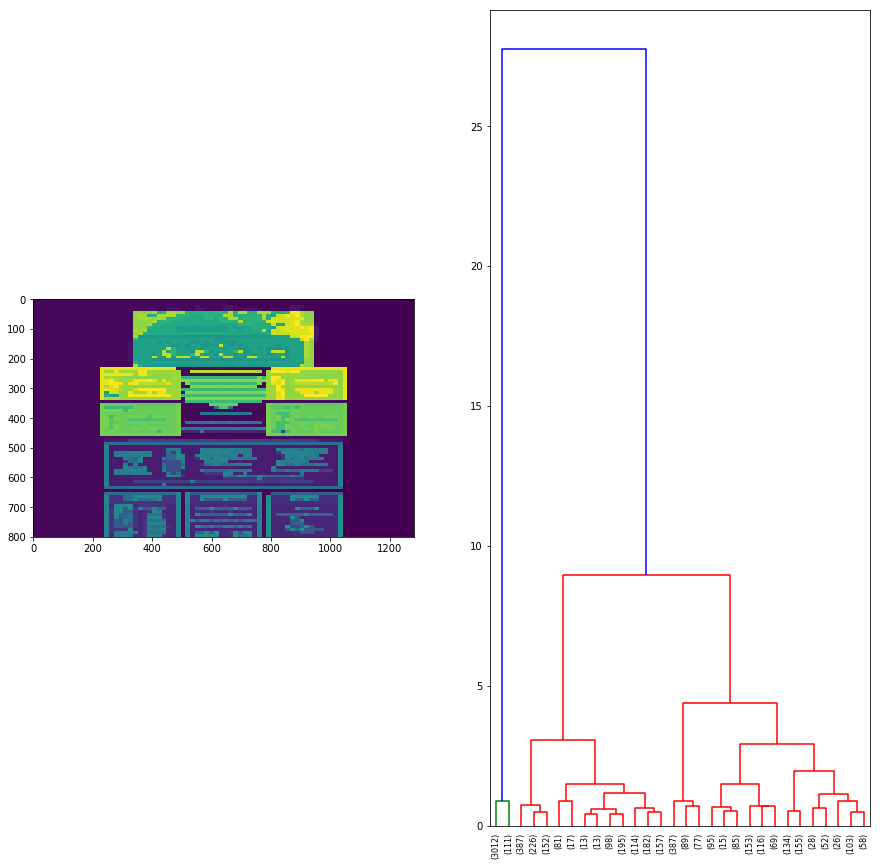

2 4.247220891675273


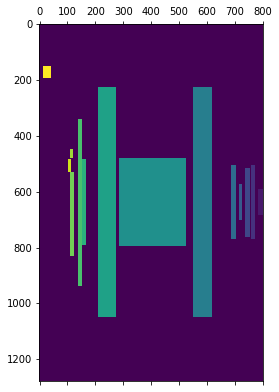

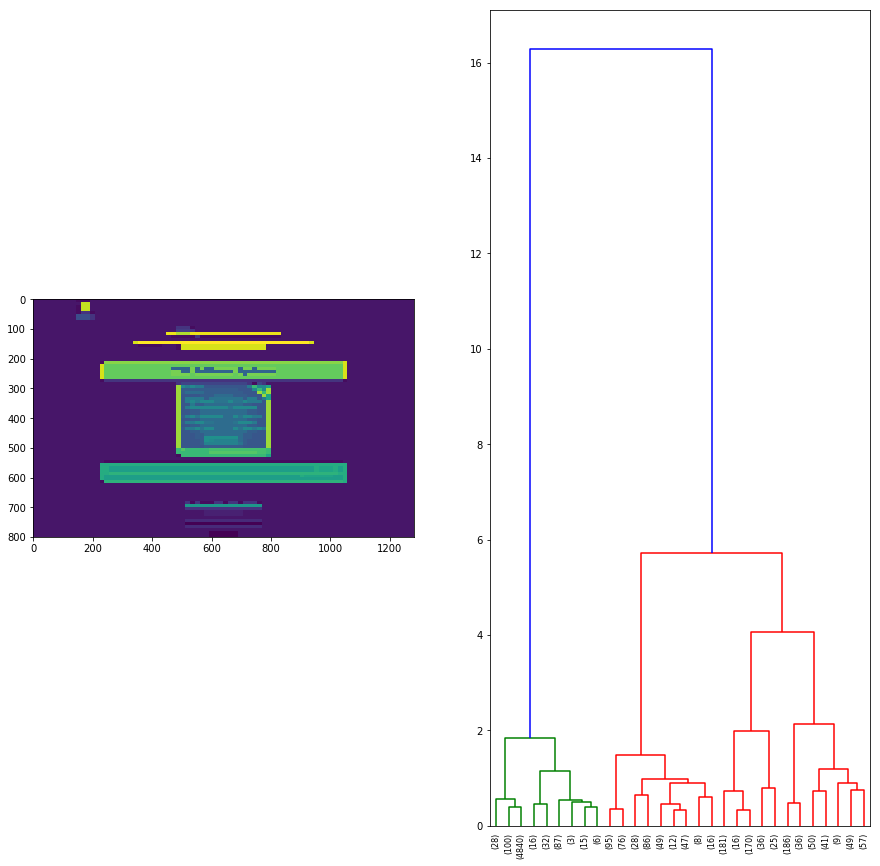

3 1.8988624484979815


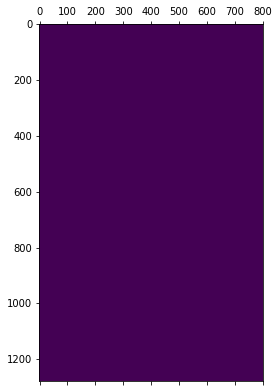

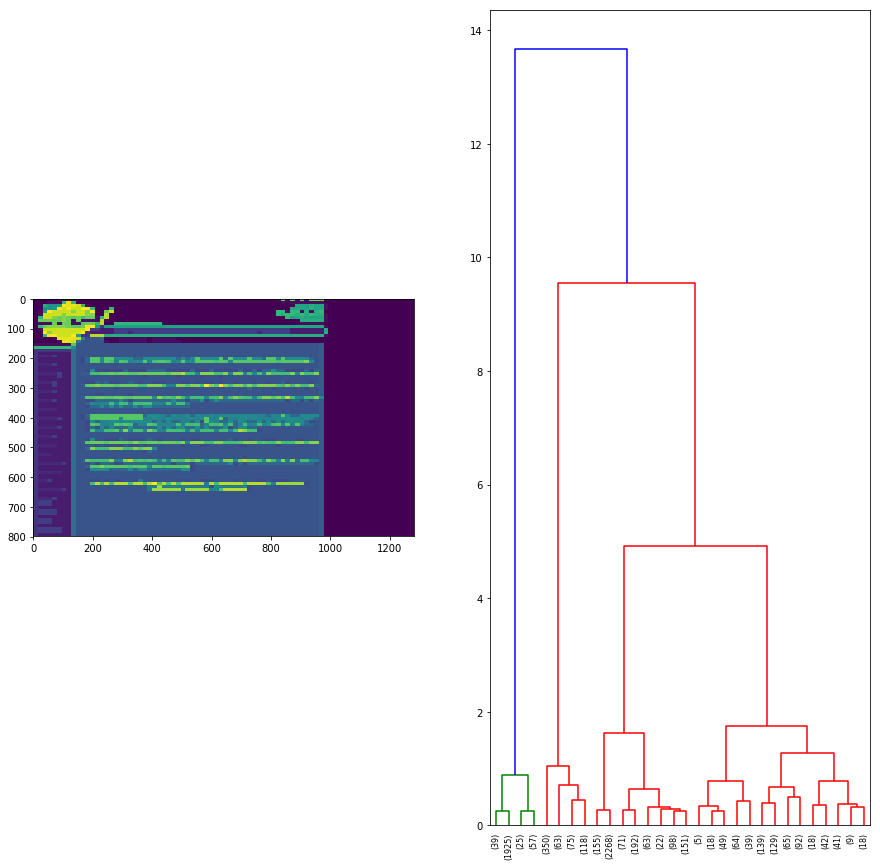

4 3.018901448497587


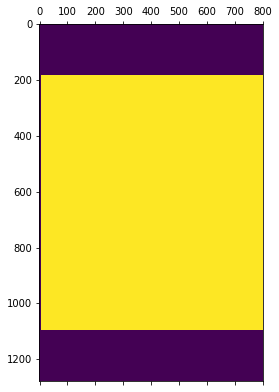

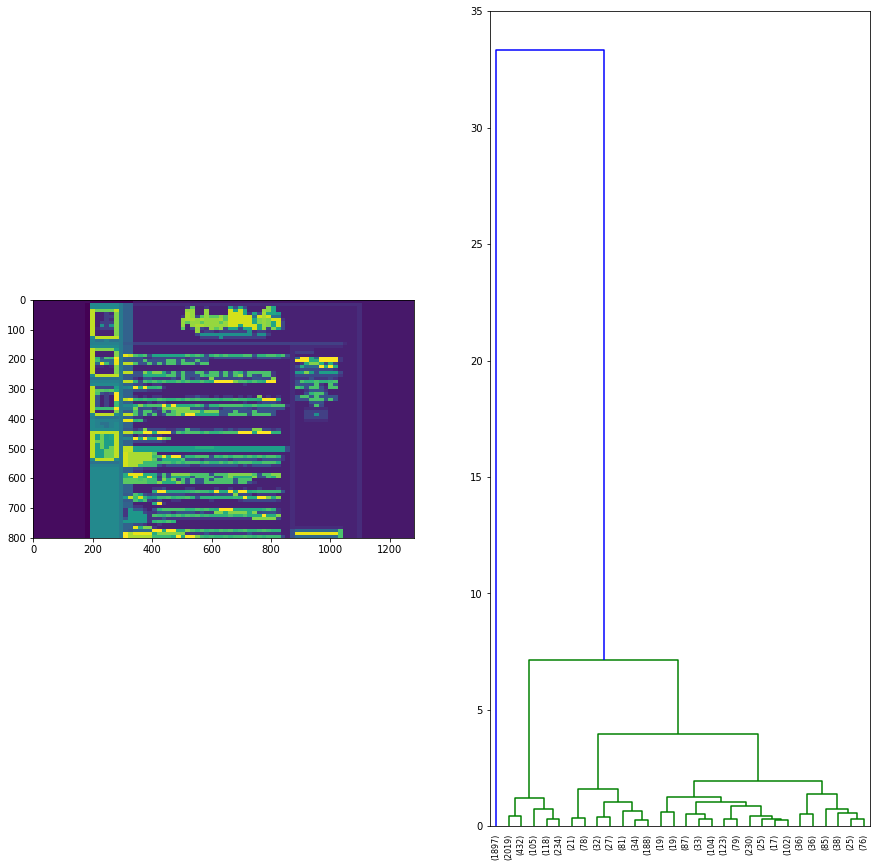

5 3.6587142072842185


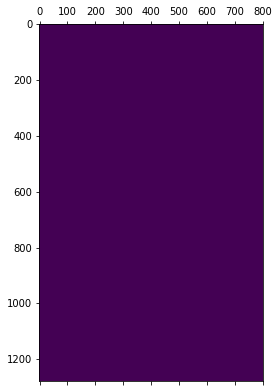

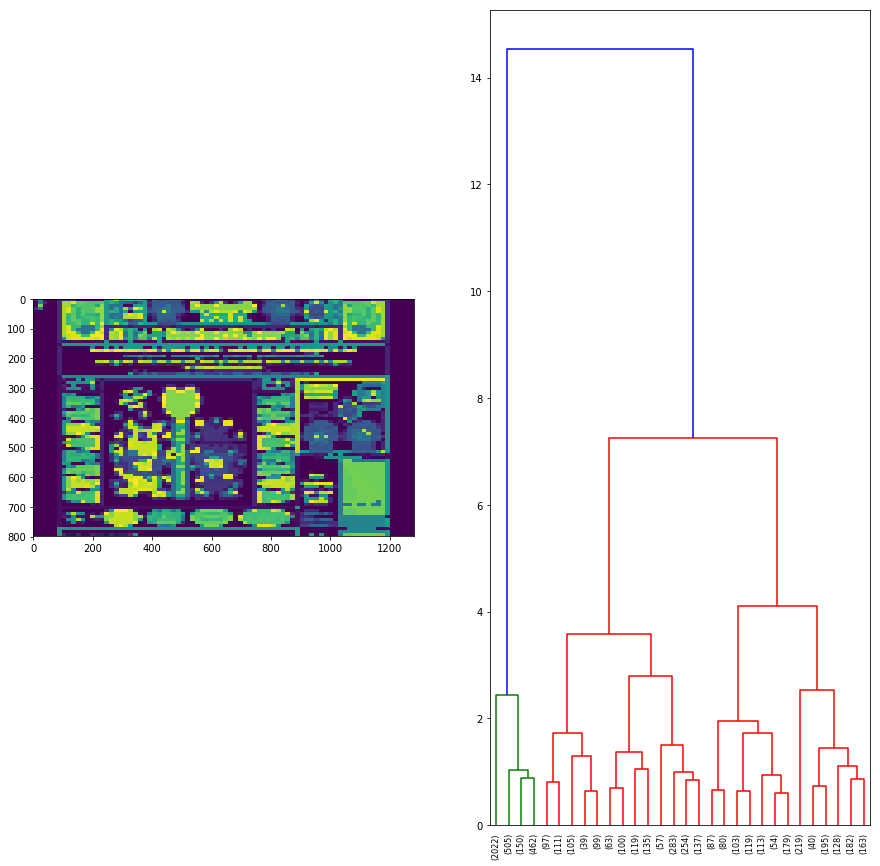

6 4.969251386369358


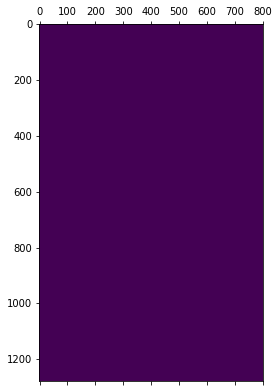

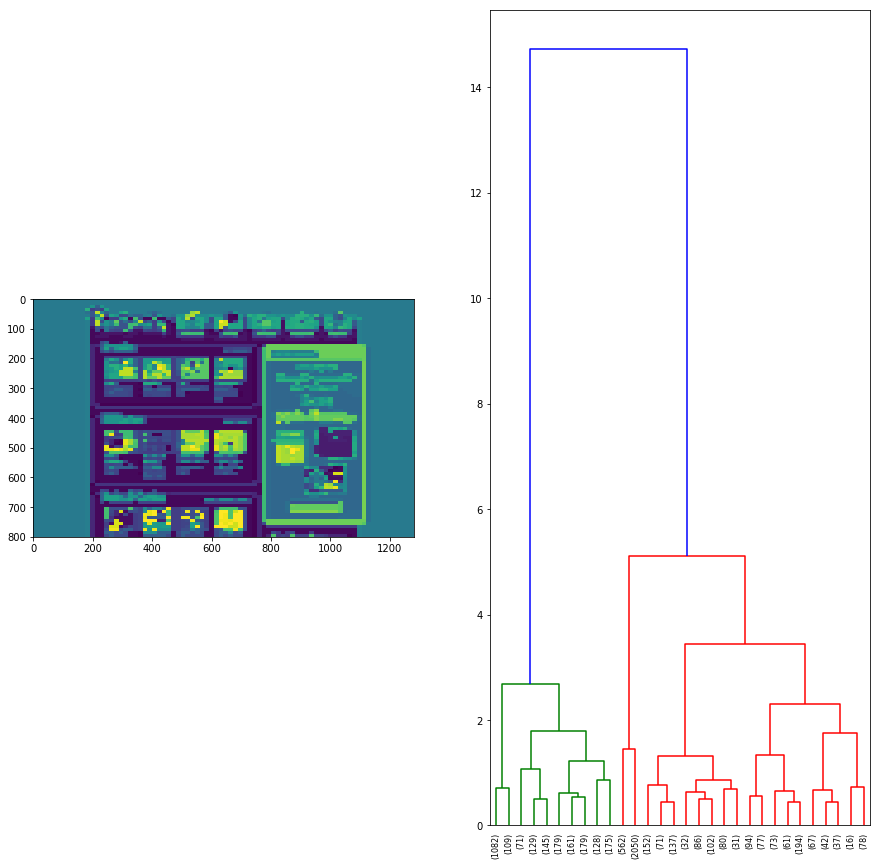

7 4.2846754727129


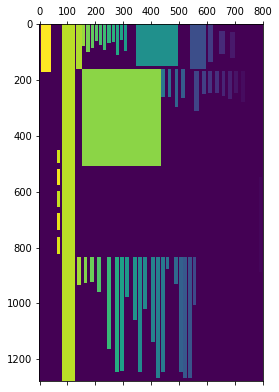

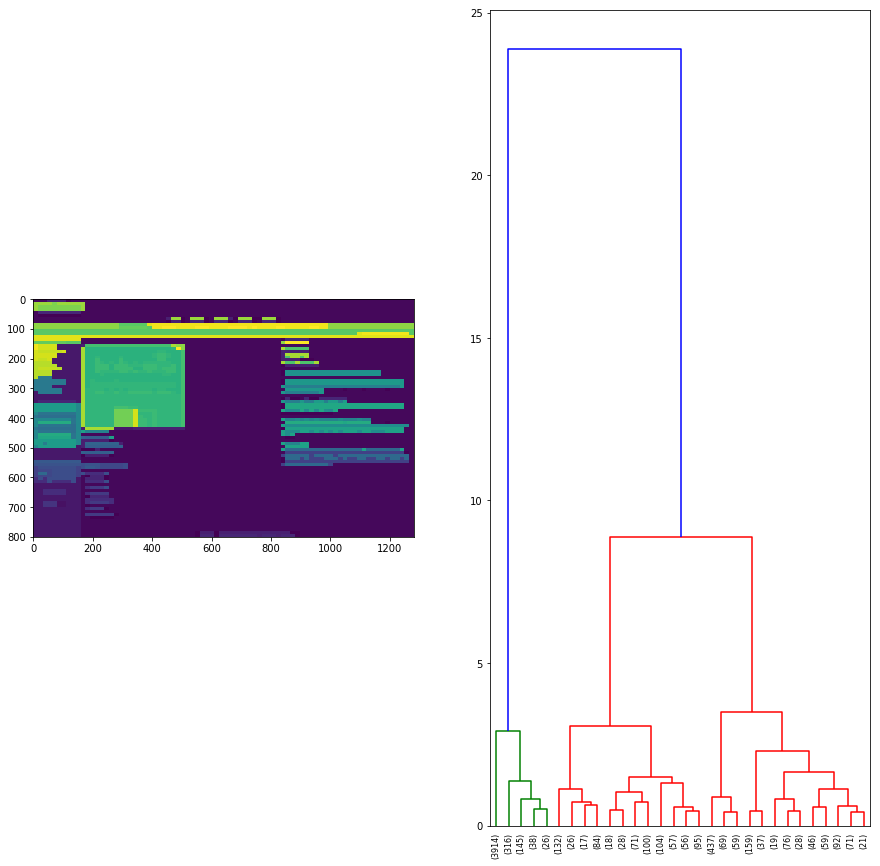

8 2.9581108402362415


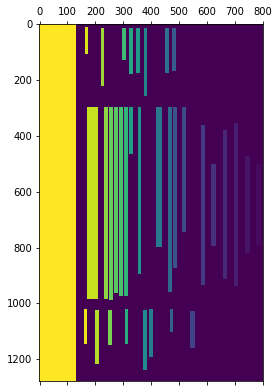

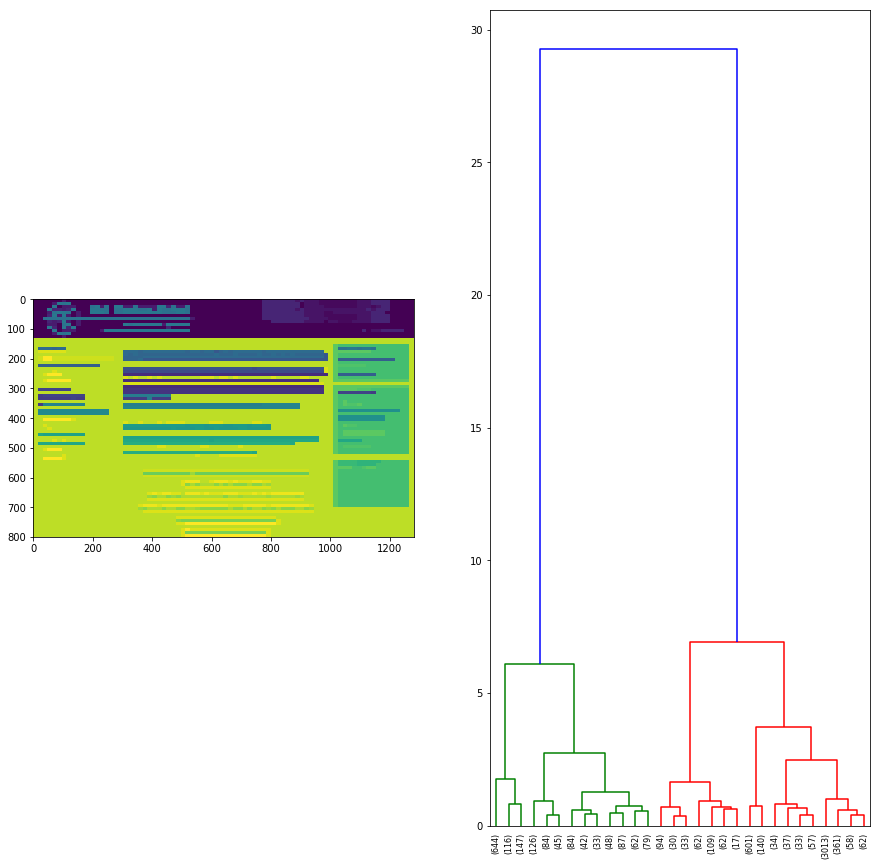

9 3.3359518827428487


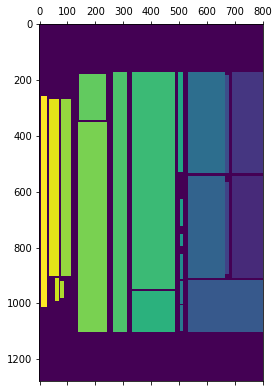

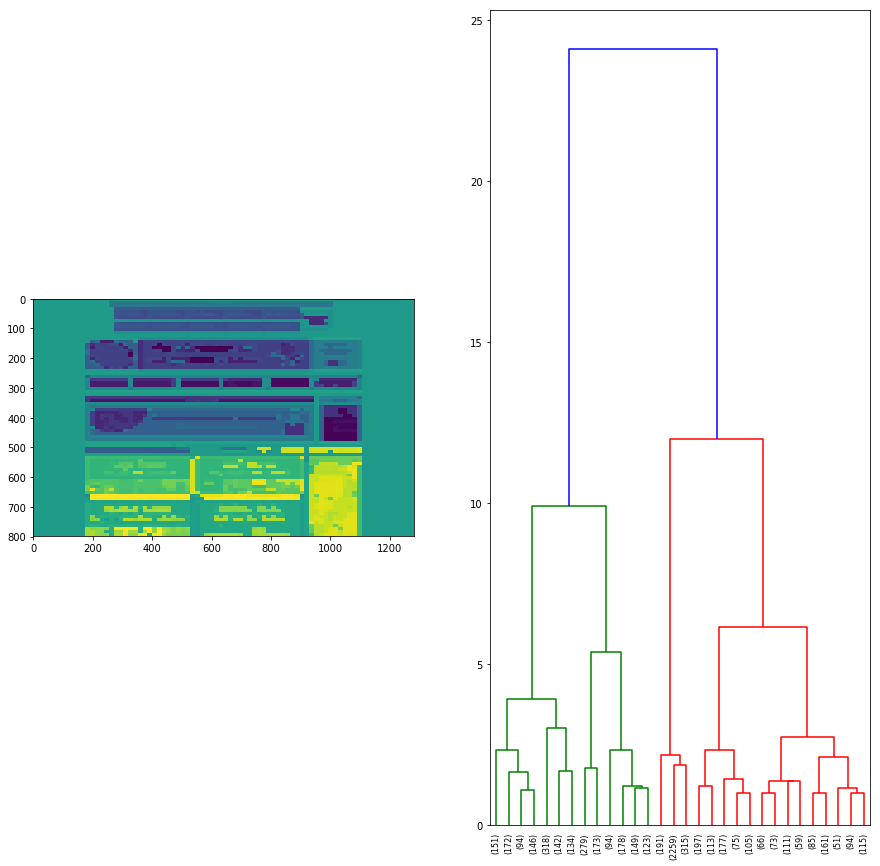

10 5.391636094500938


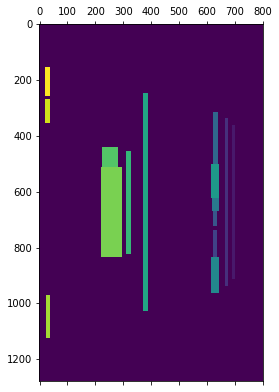

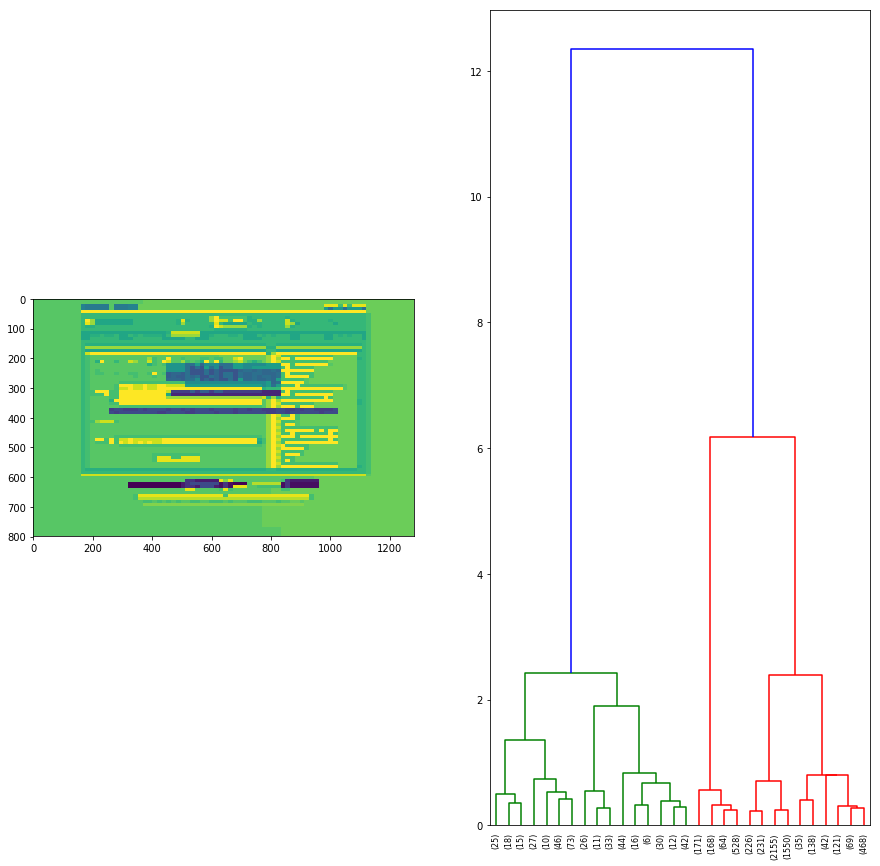

11 3.070956436208608


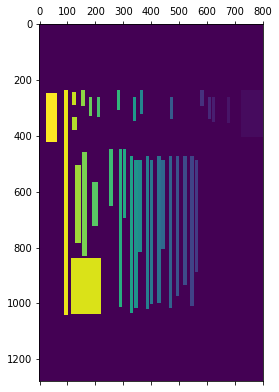

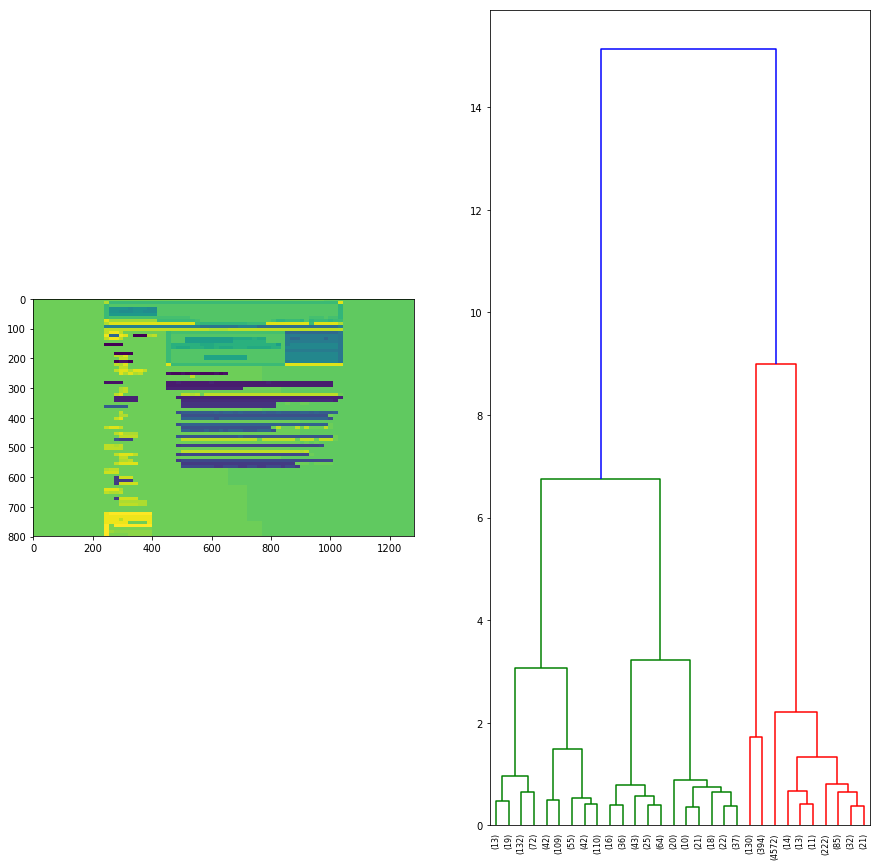

12 2.8878205602007414


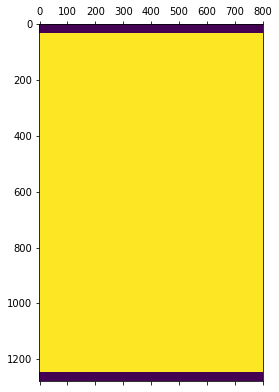

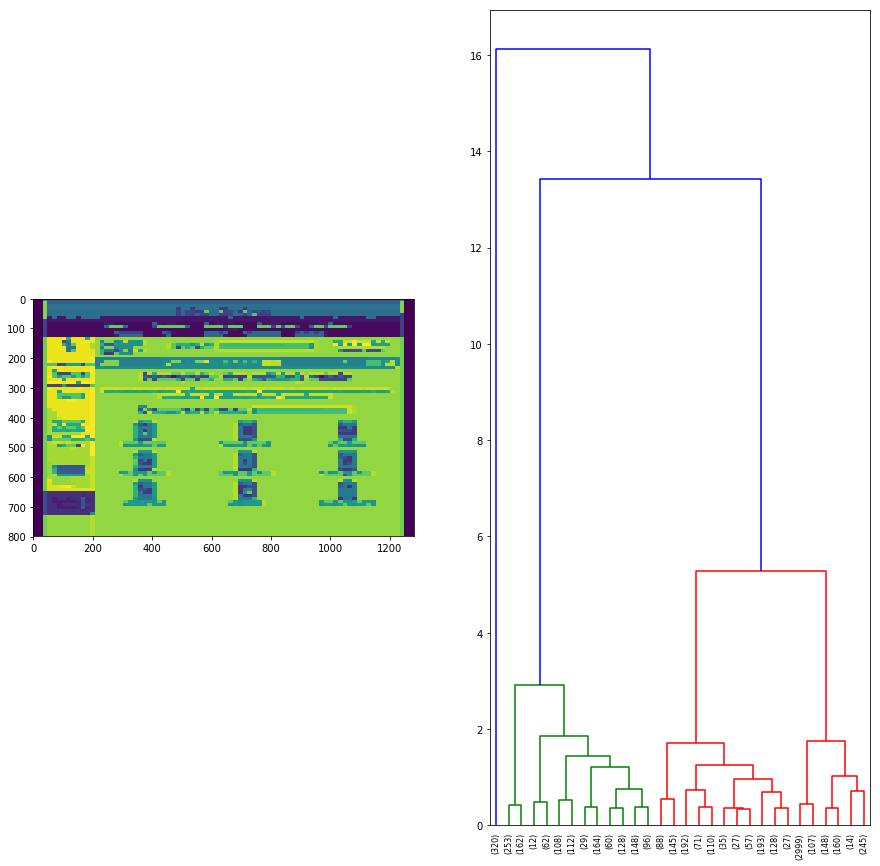

13 3.5735062145744205


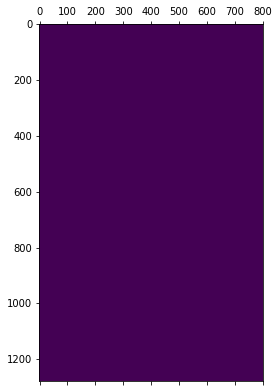

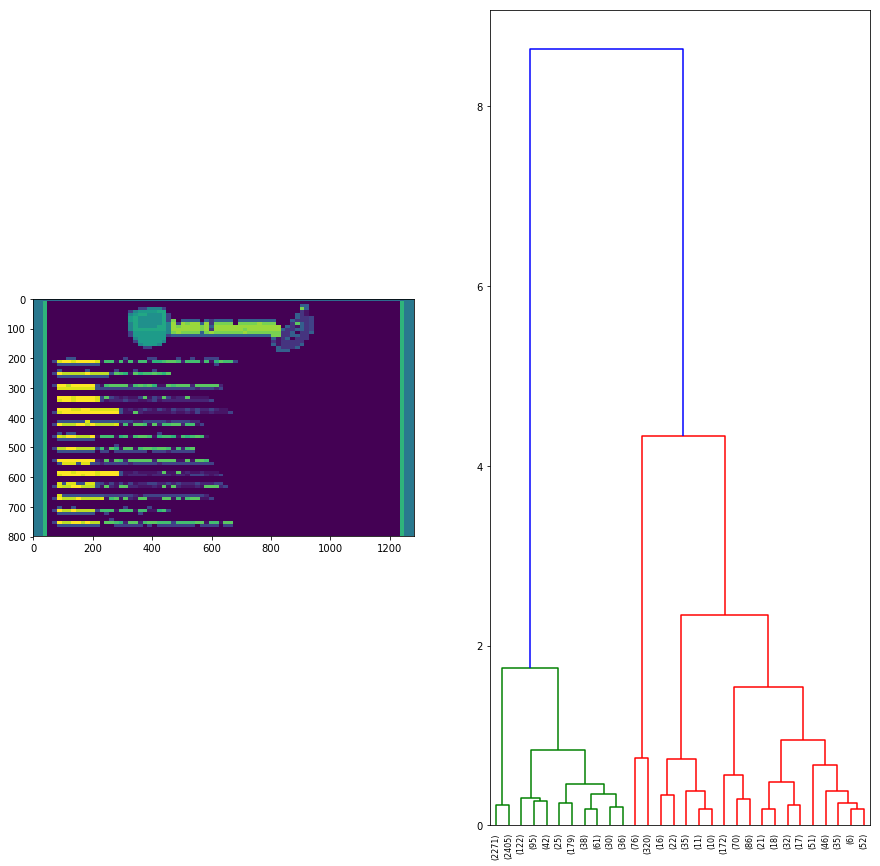

14 1.8961934389389896


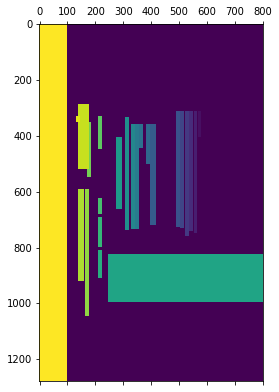

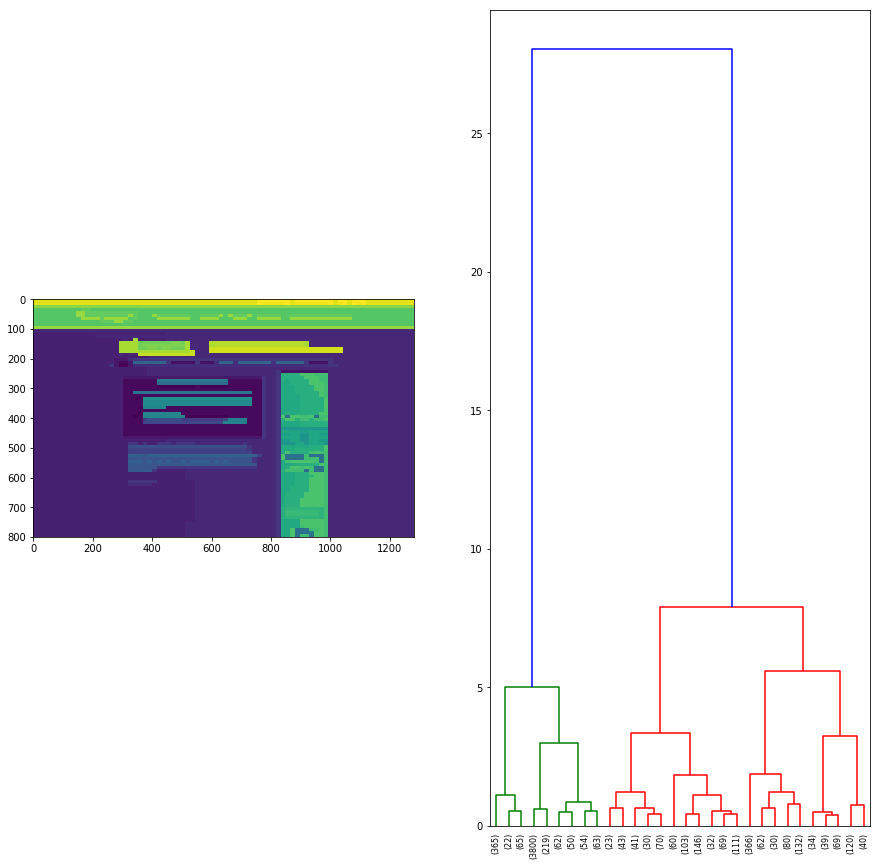

15 3.4770803436441744


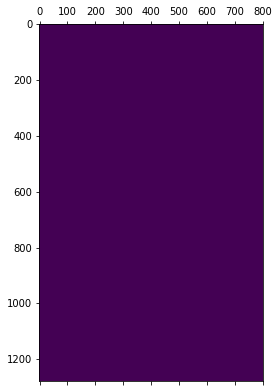

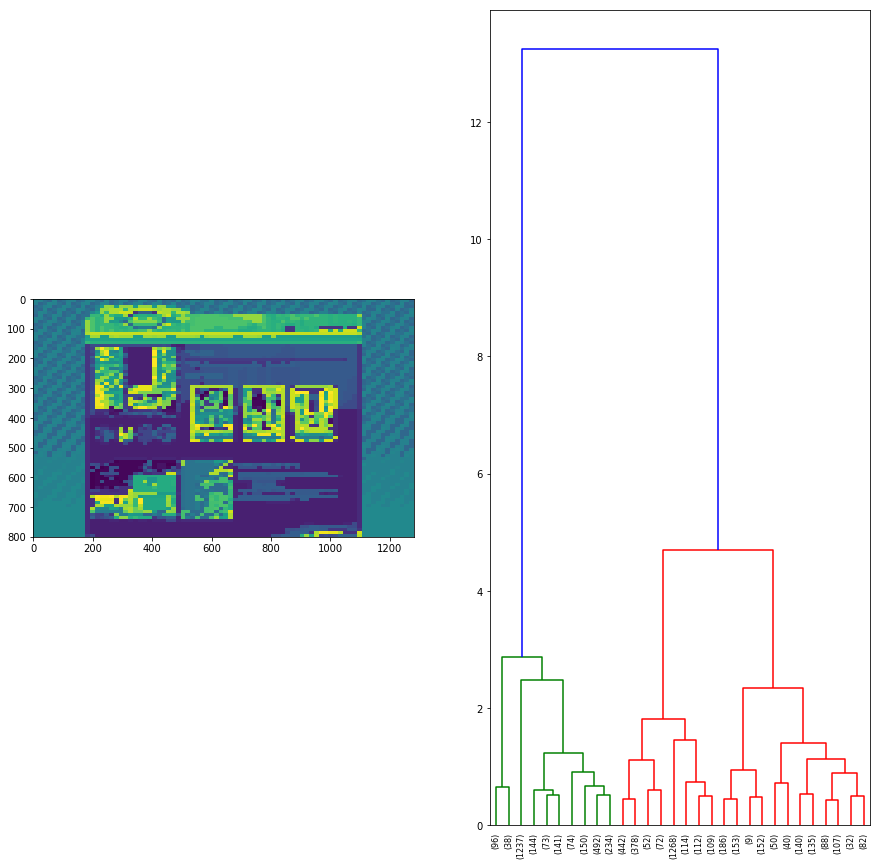

16 4.8710515256483555


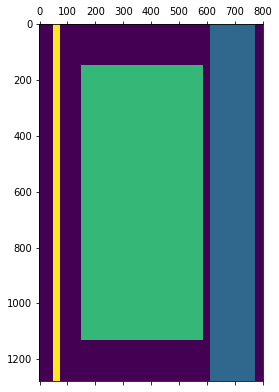

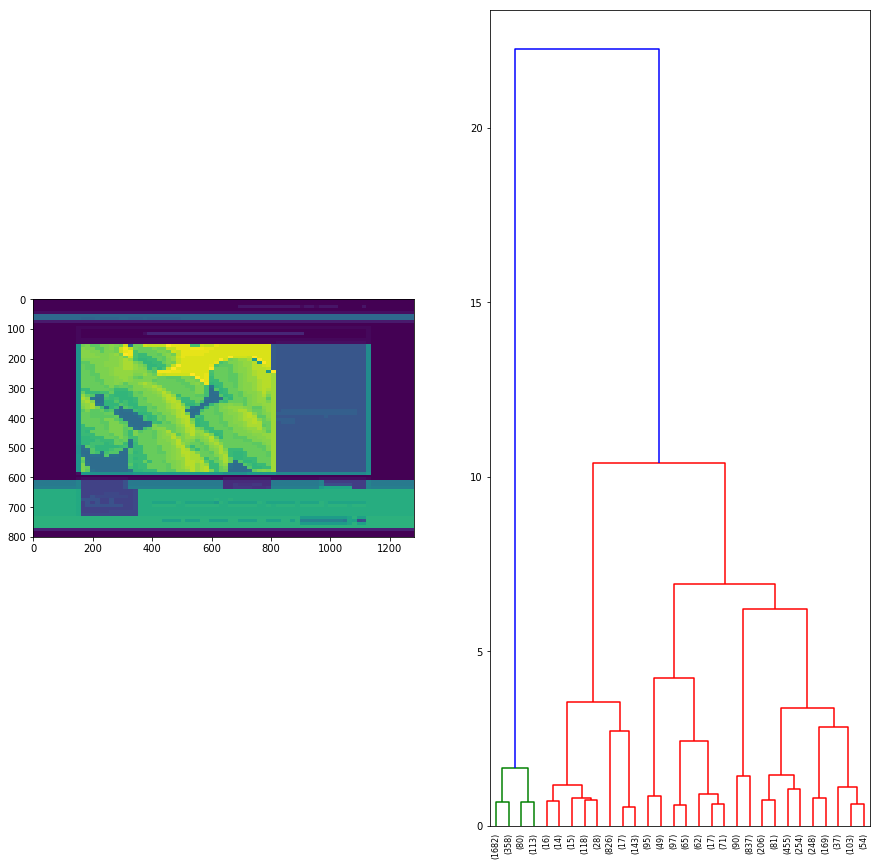

17 4.369719166883744


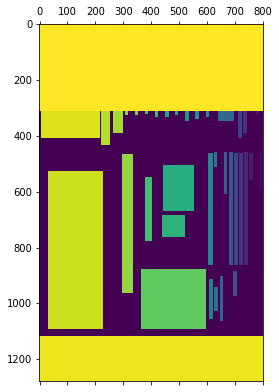

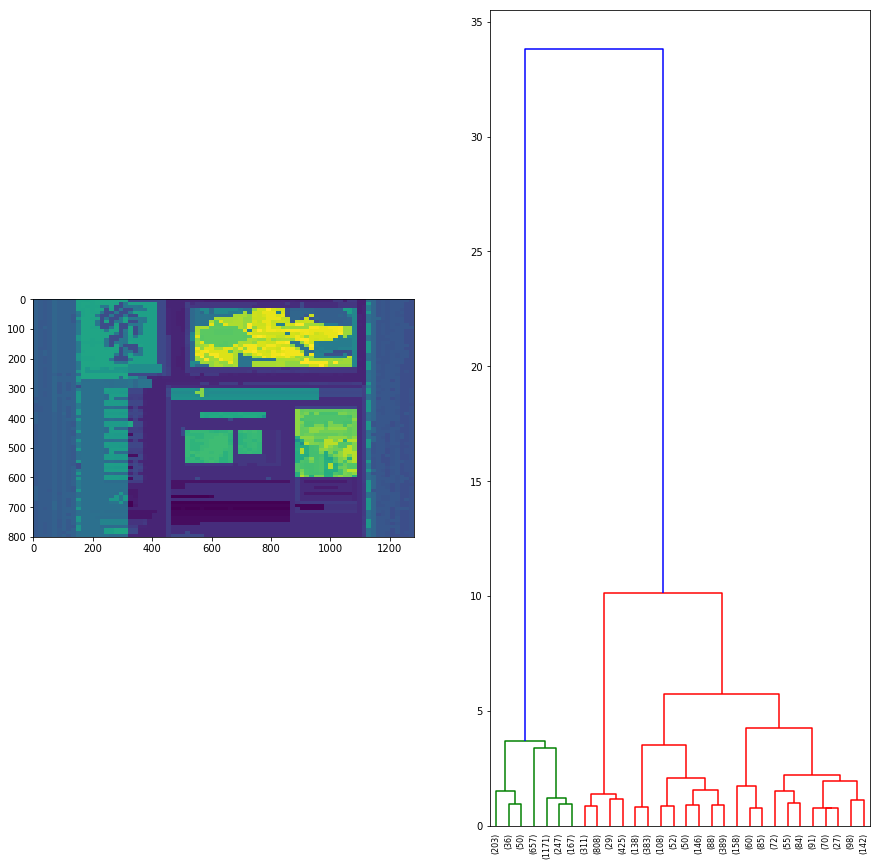

18 5.604681546021106


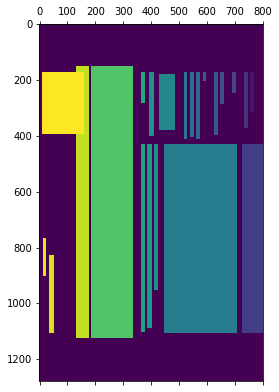

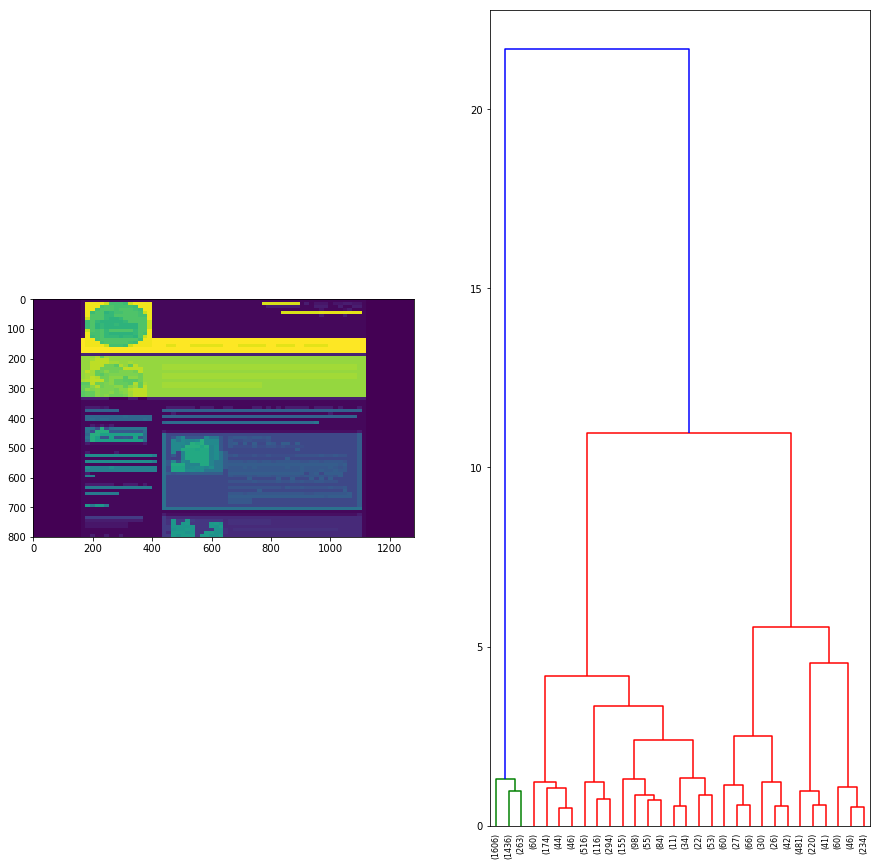

19 3.912764724091225


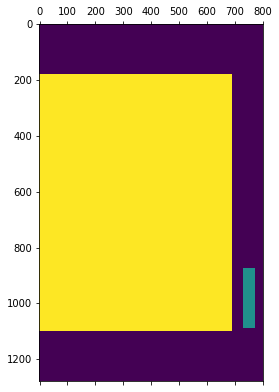

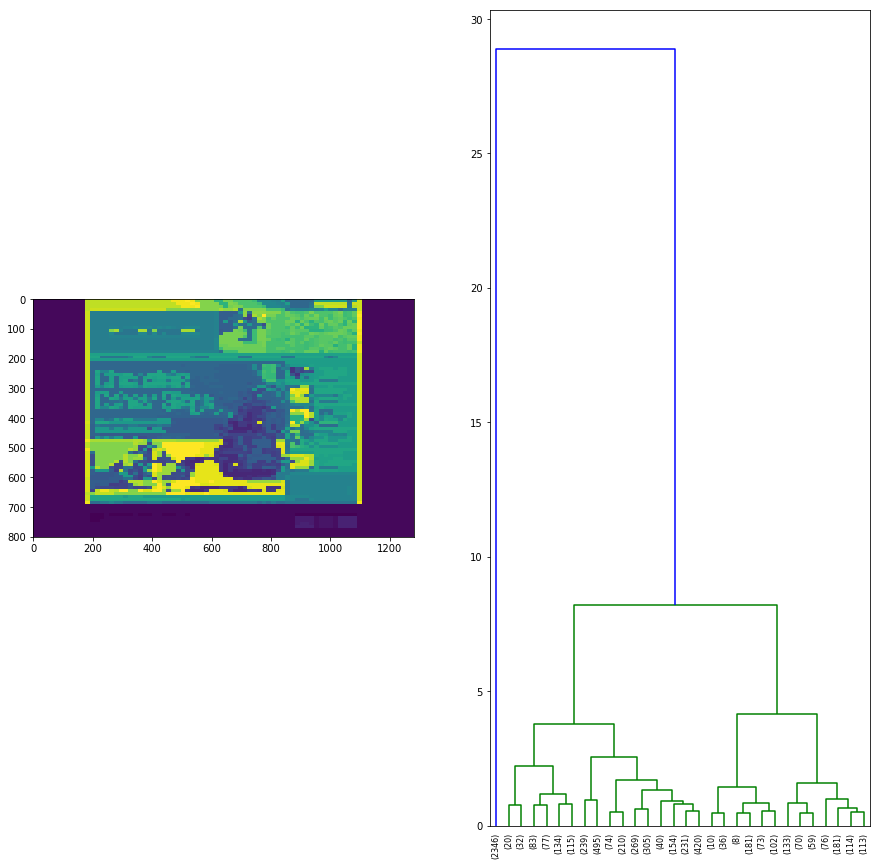

20 4.270368416694204


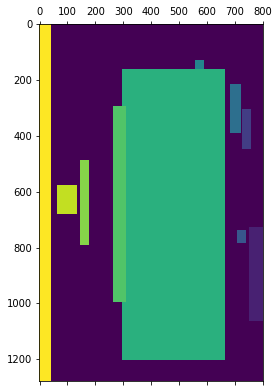

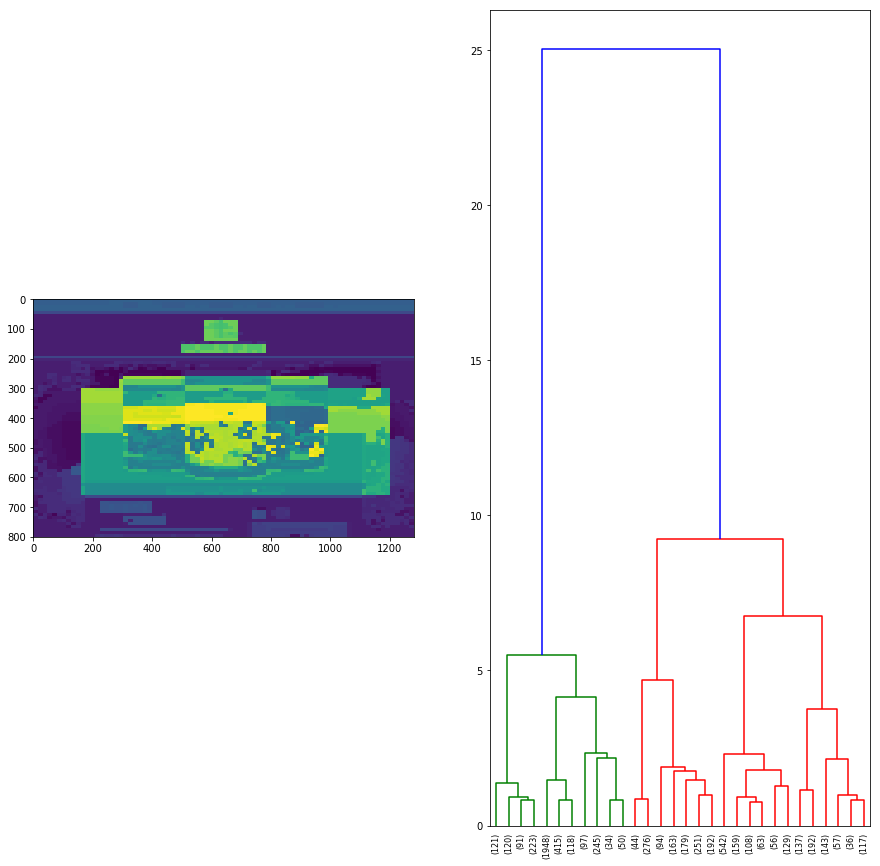

21 5.0584613601371835


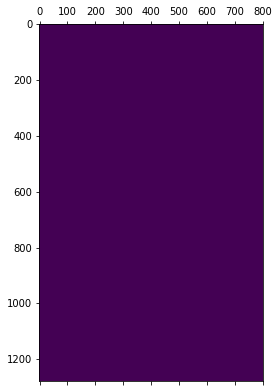

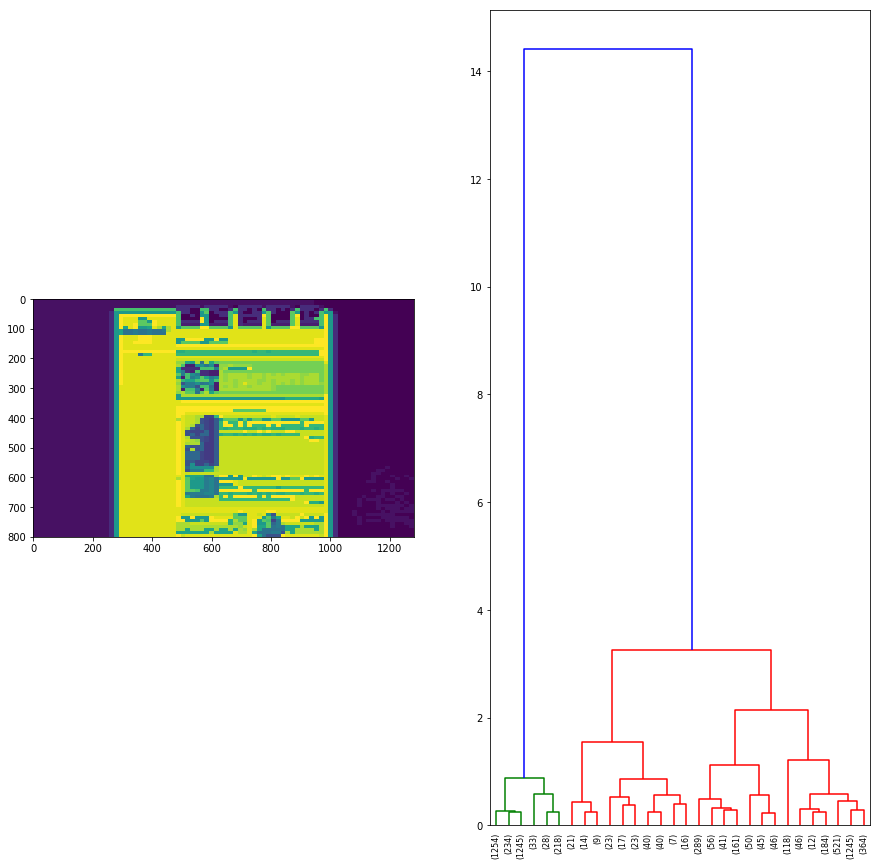

22 3.315182437610122


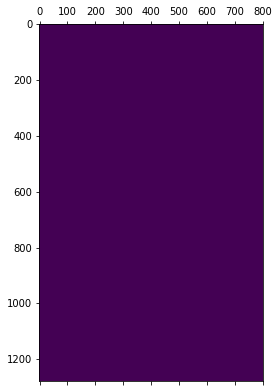

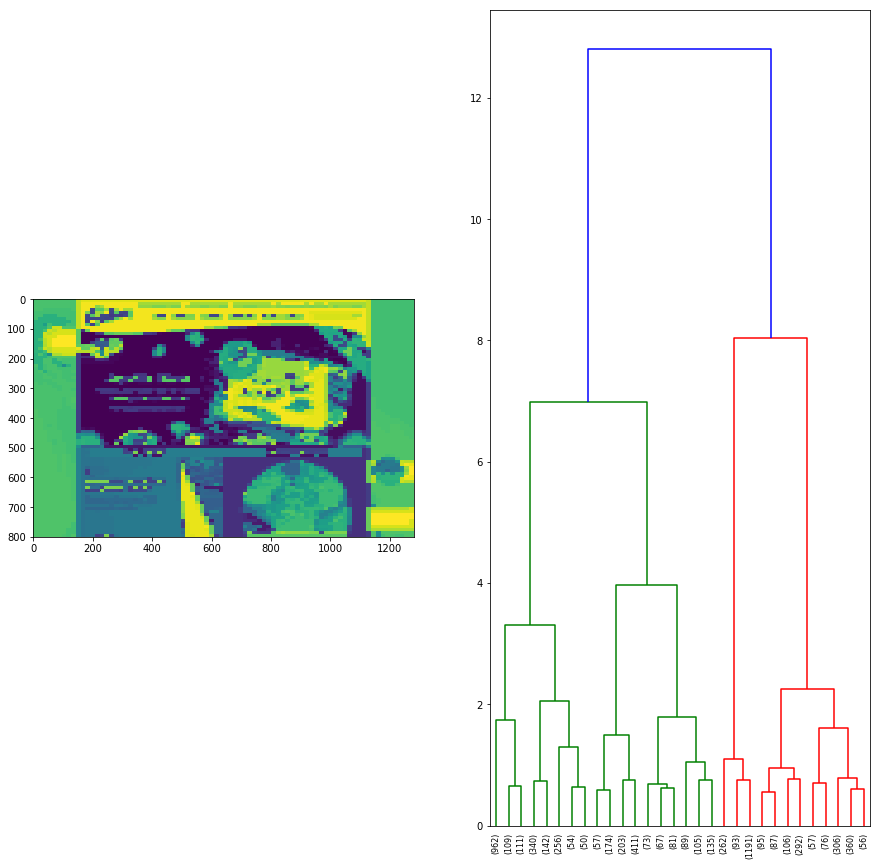

23 5.320881141914628


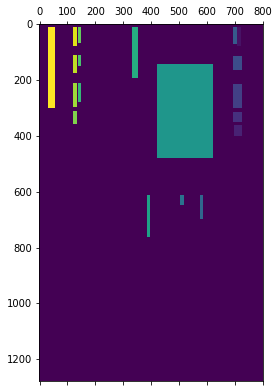

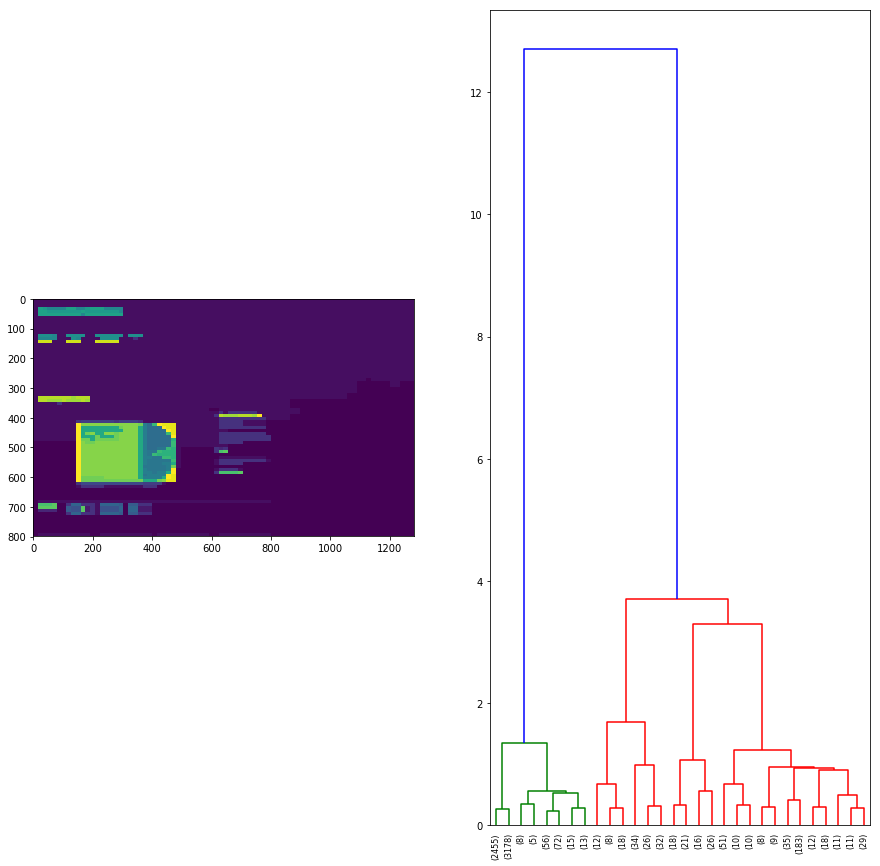

24 1.8772267220365022


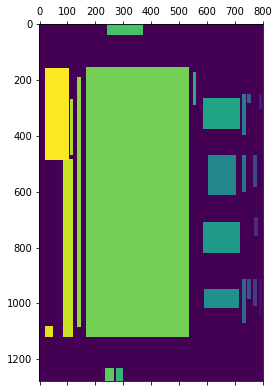

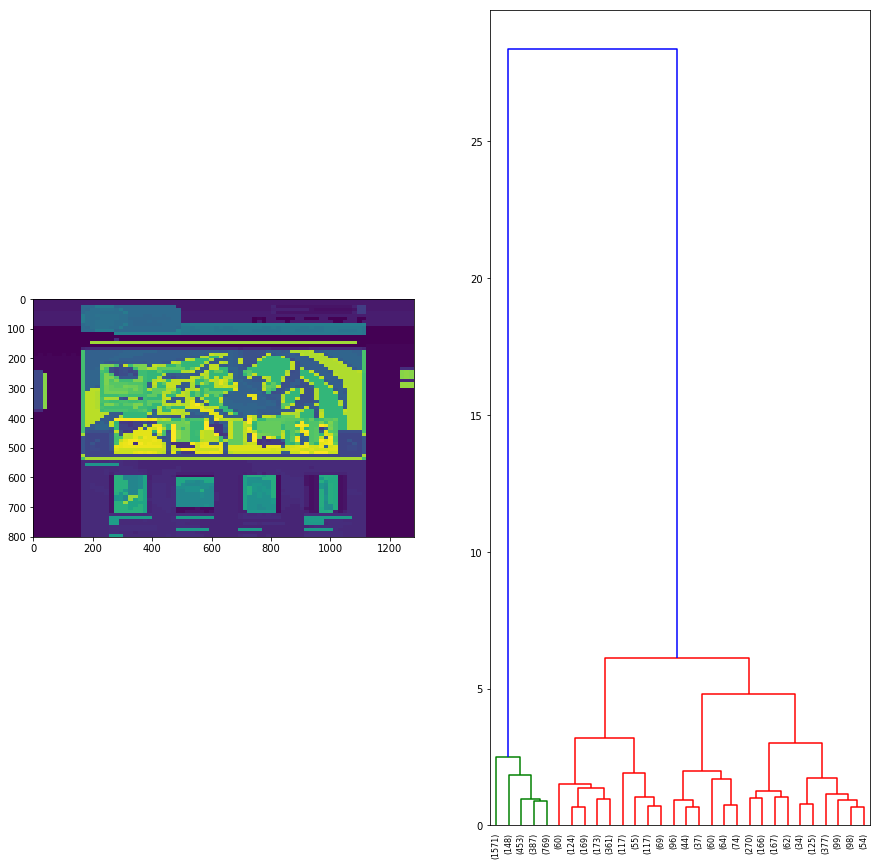

25 5.1148312449781175


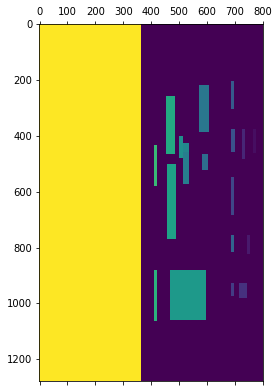

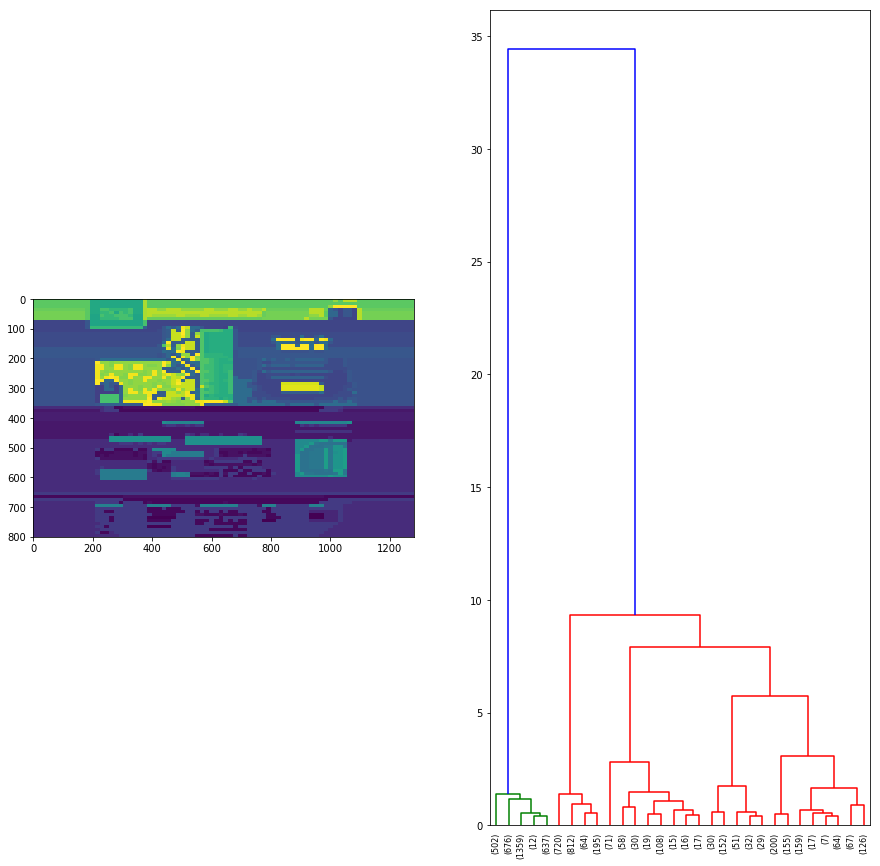

26 4.3970521307055215


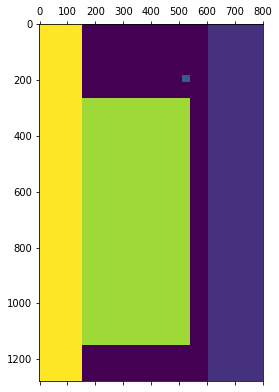

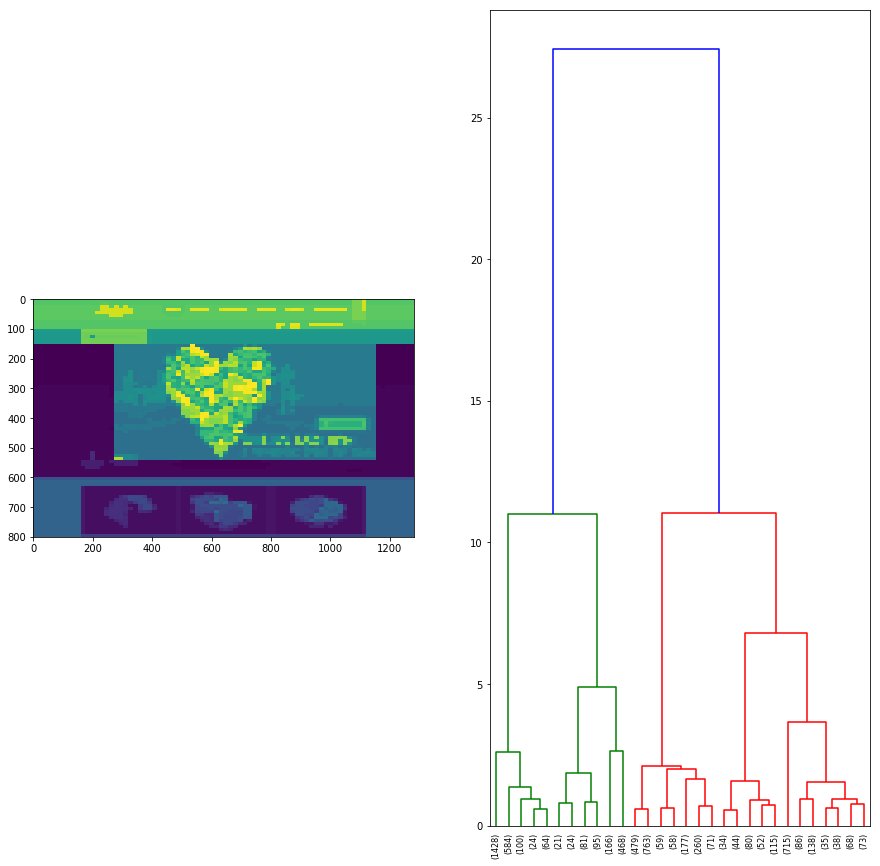

27 4.624722552178869


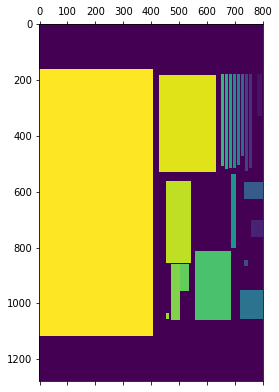

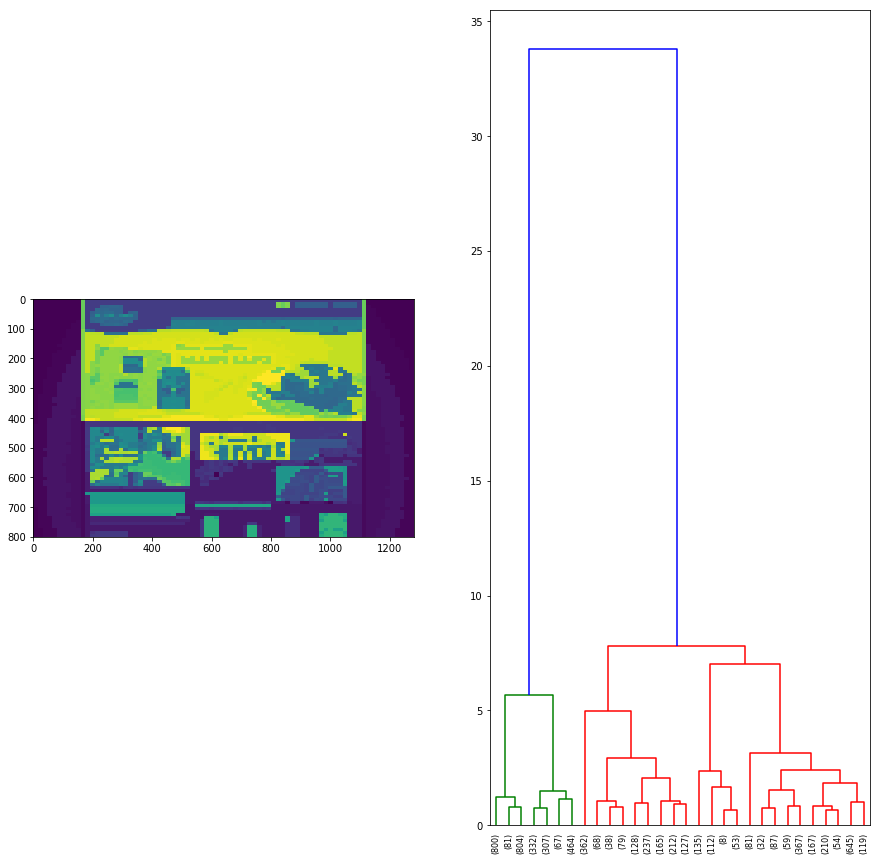

28 5.4193750202646145


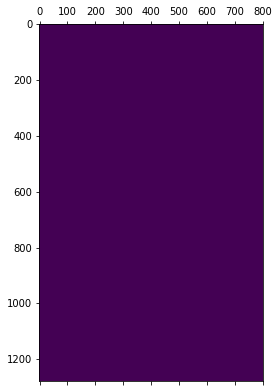

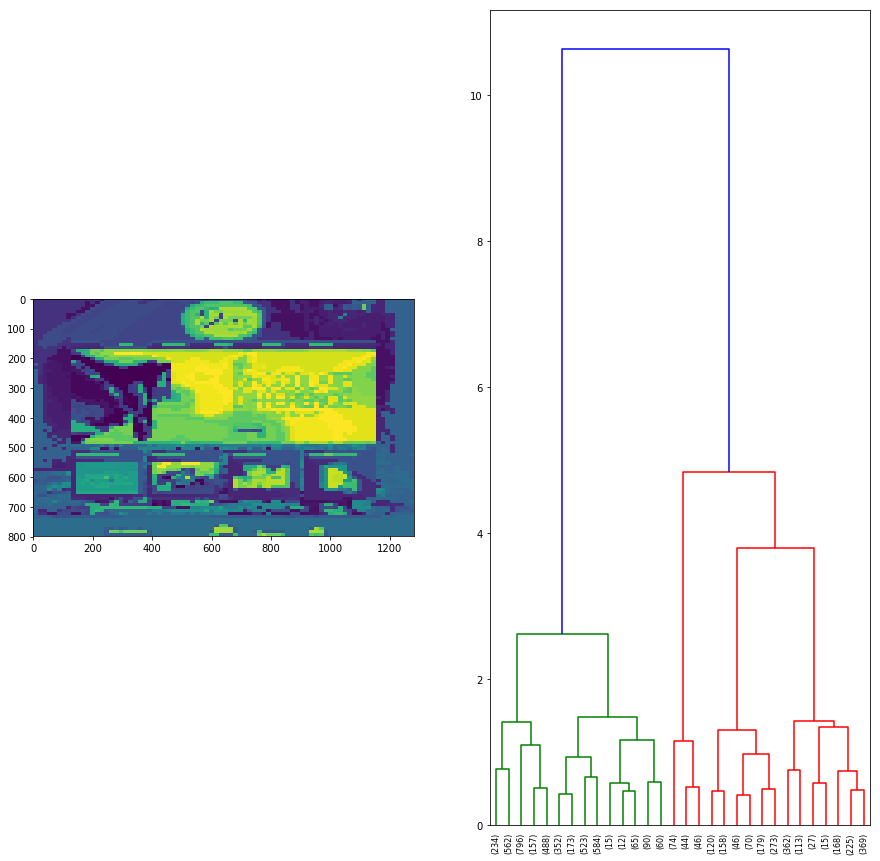

29 5.058657190908081


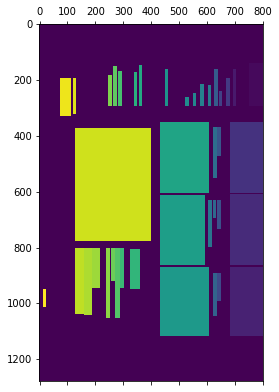

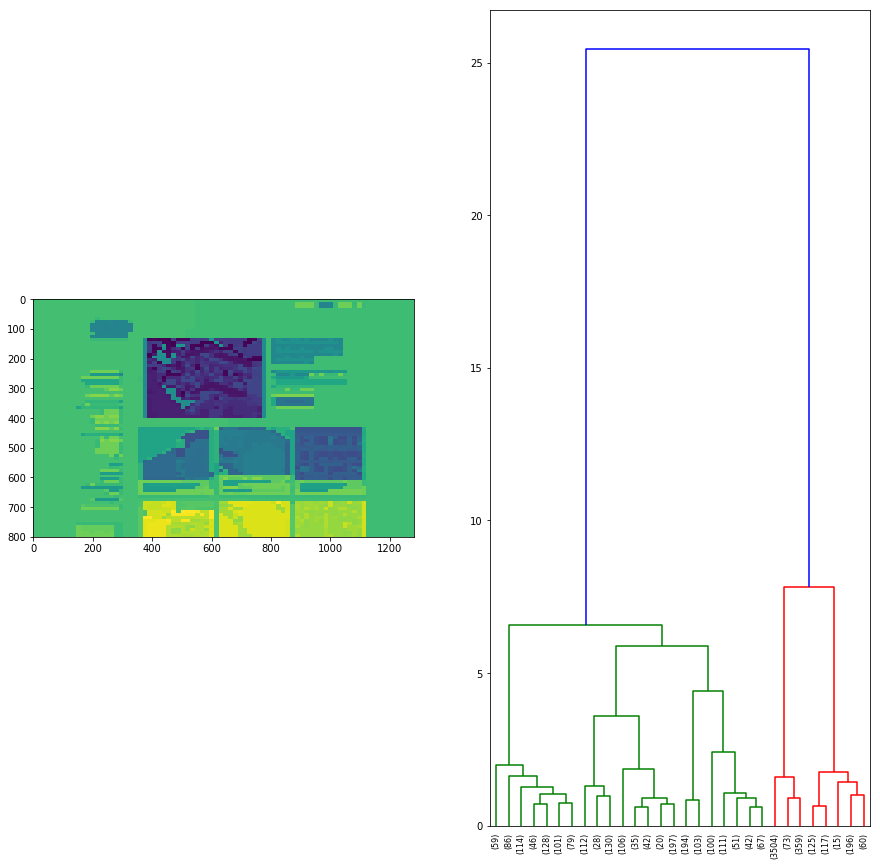

30 4.311931422089251


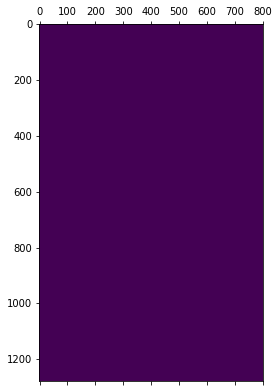

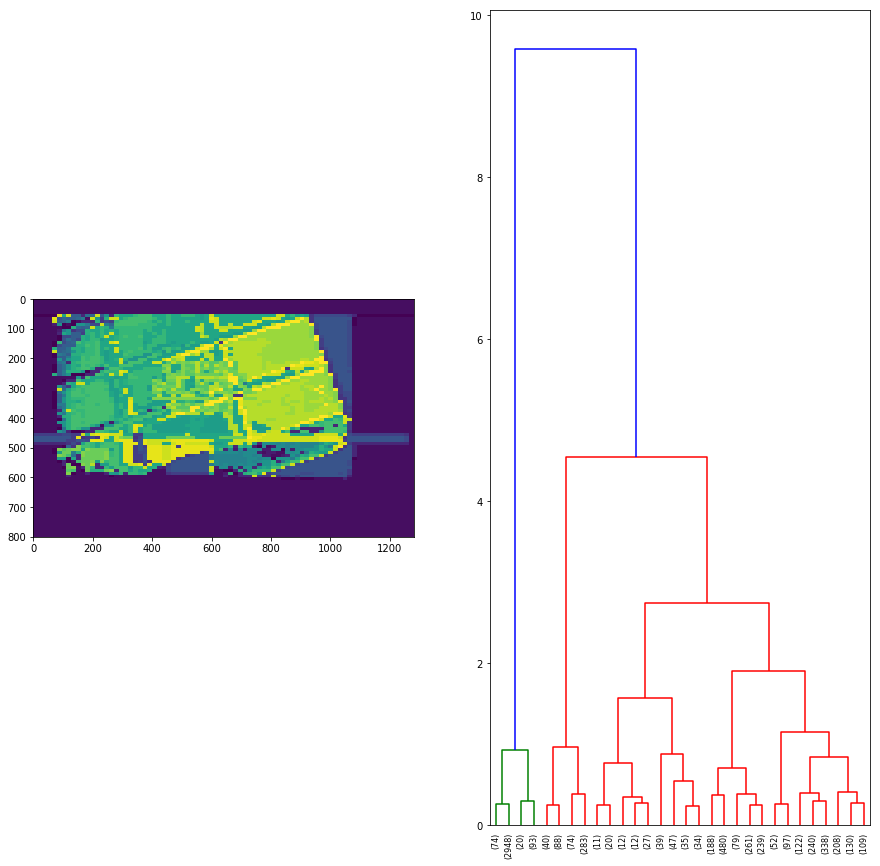

31 3.2874956581467583


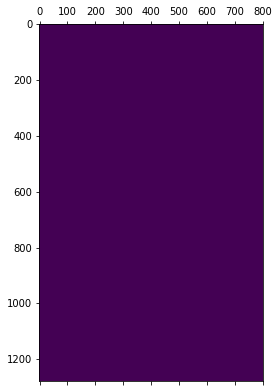

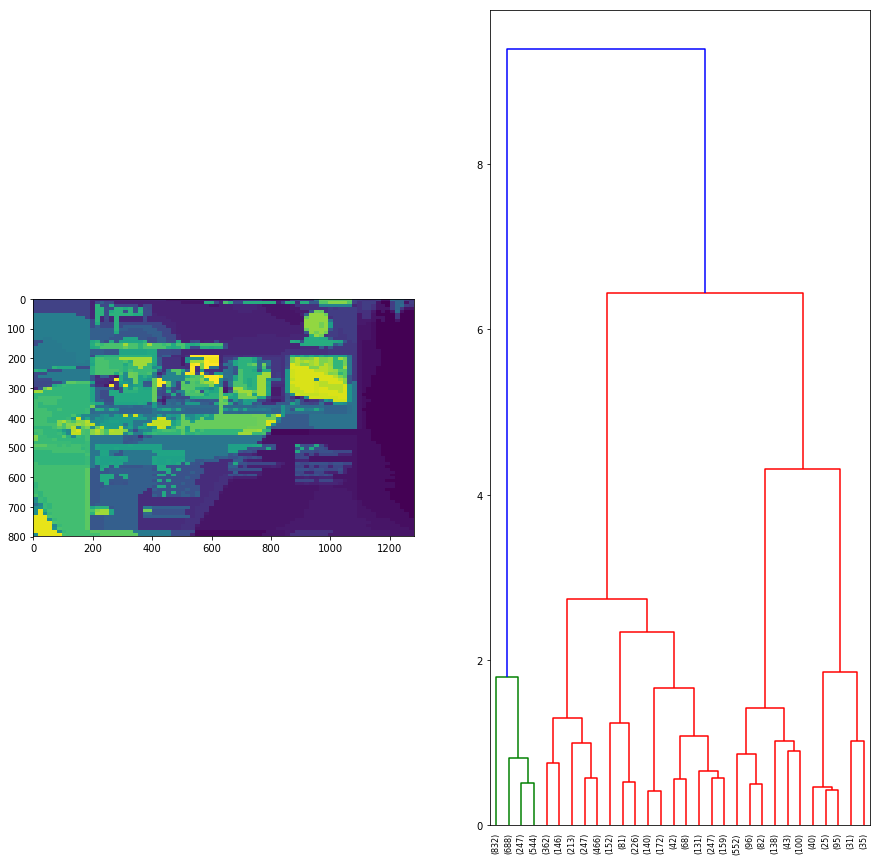

32 5.191960453601947


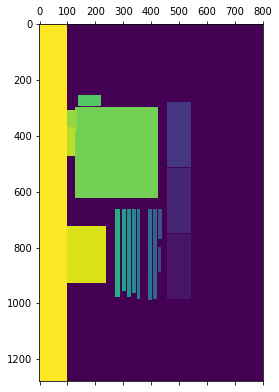

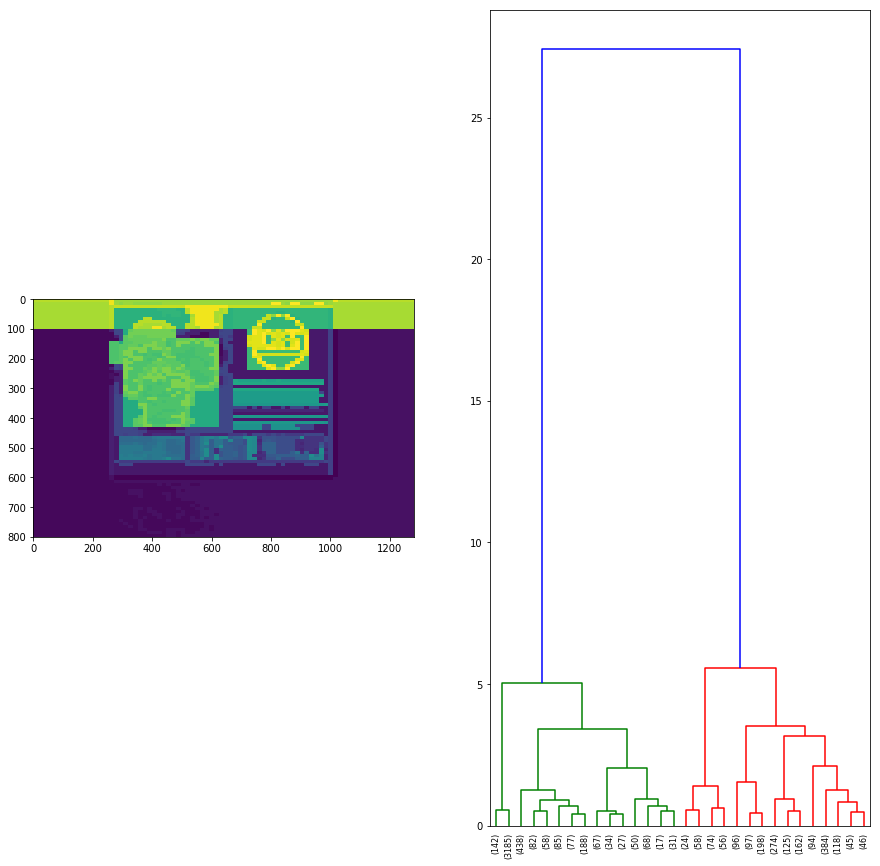

33 3.9519442168697205


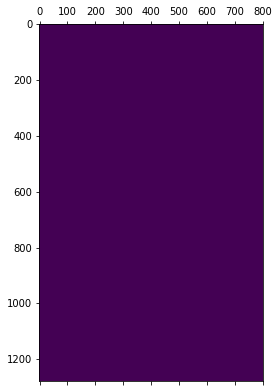

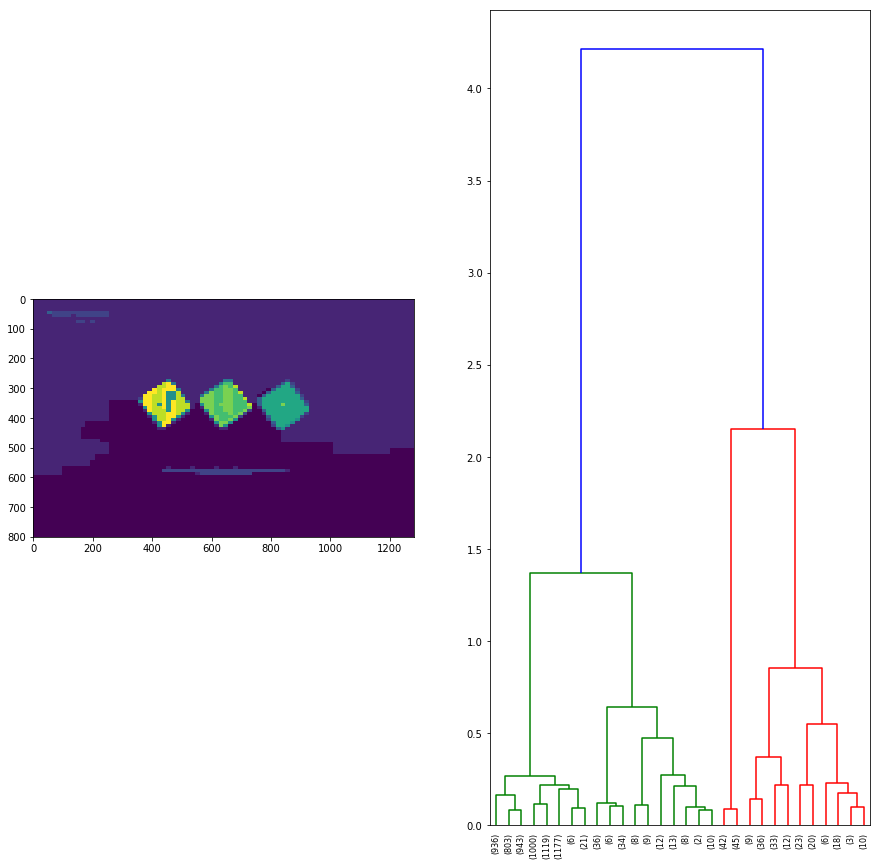

34 1.4479823276007524


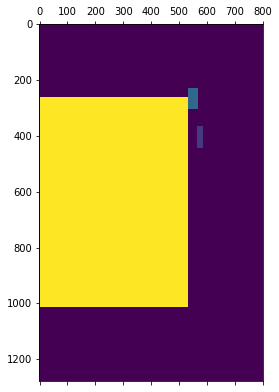

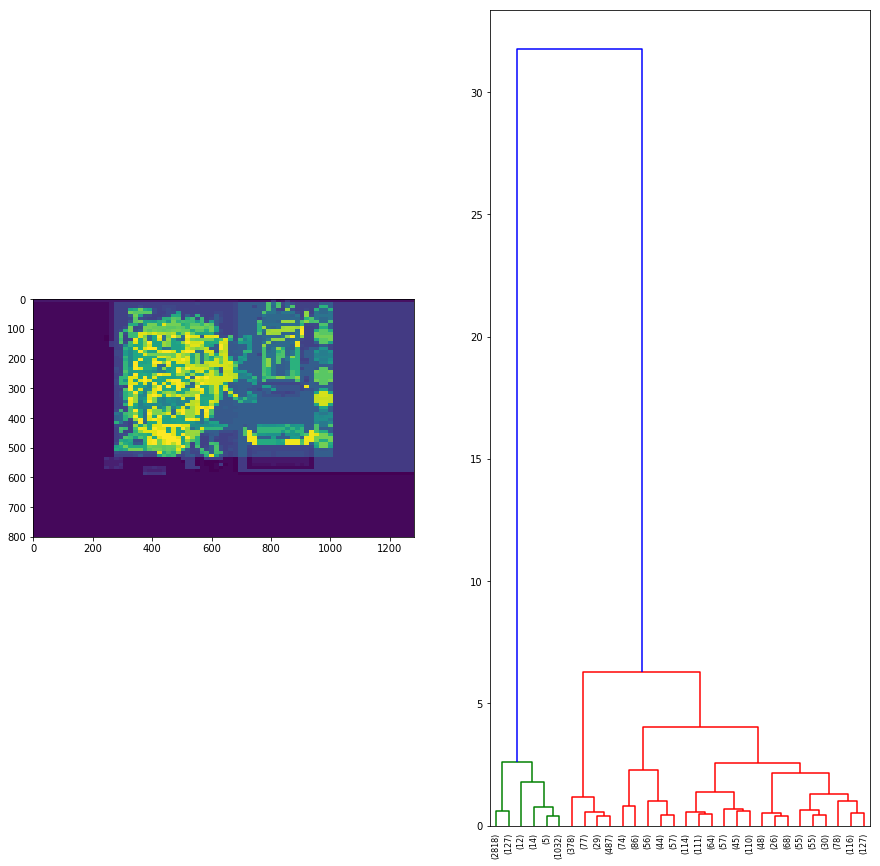

35 3.4716441142969923


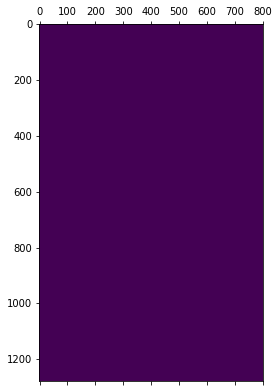

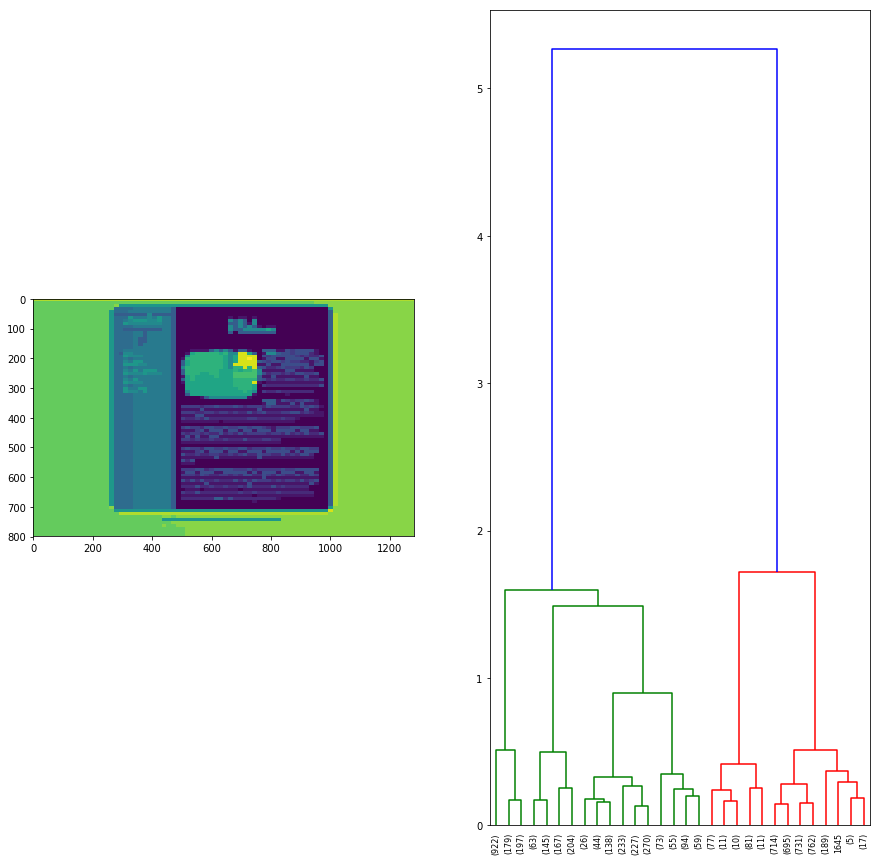

36 3.29346686624519


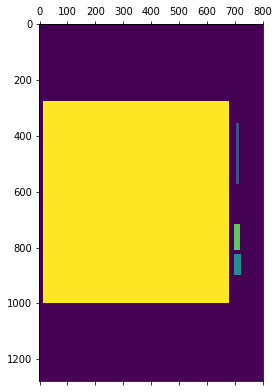

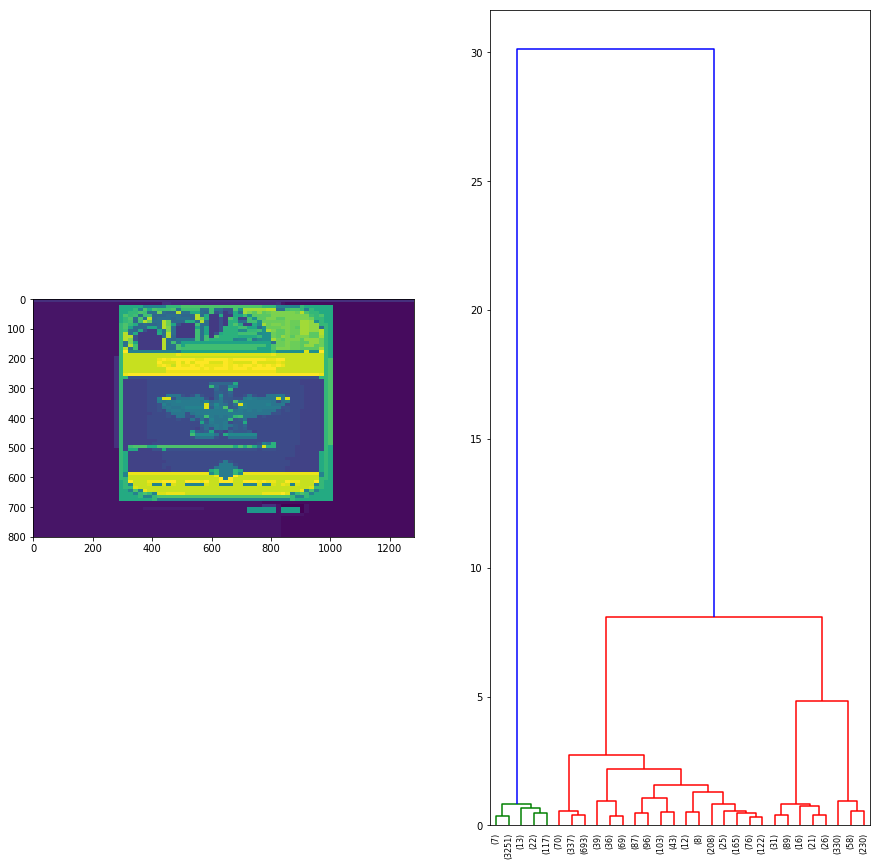

37 3.643815290047144


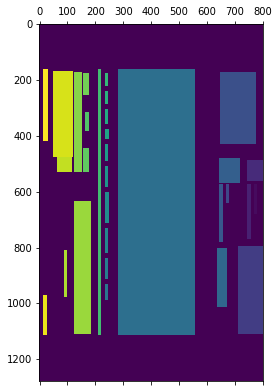

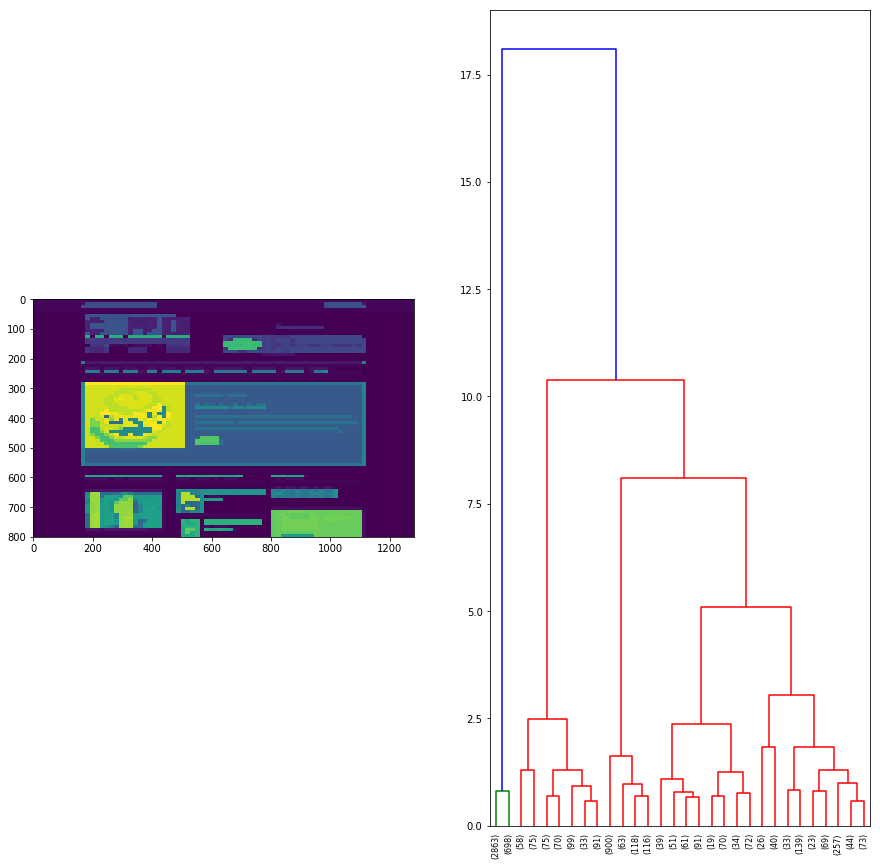

38 3.608799781741243


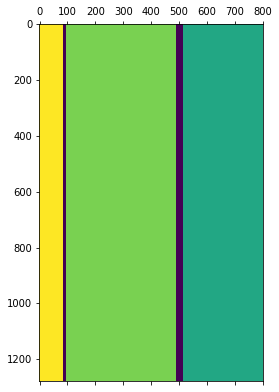

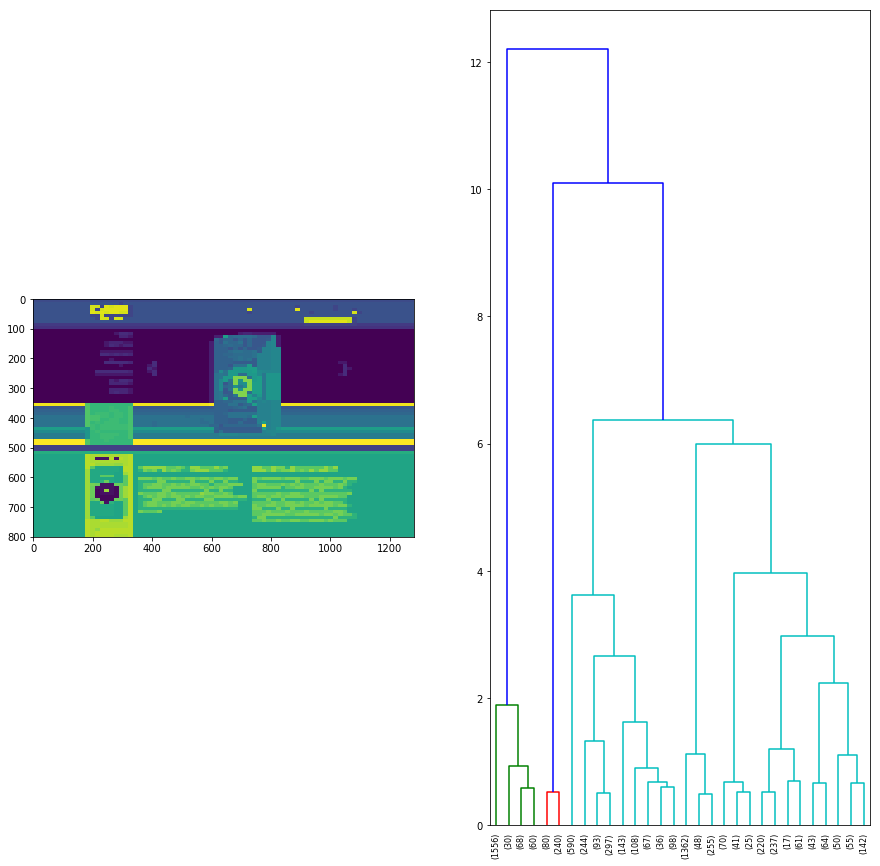

39 4.110538686513939


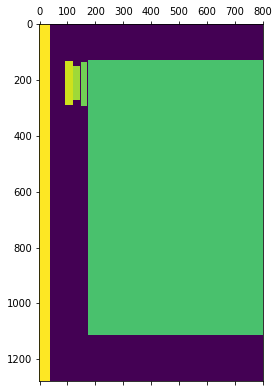

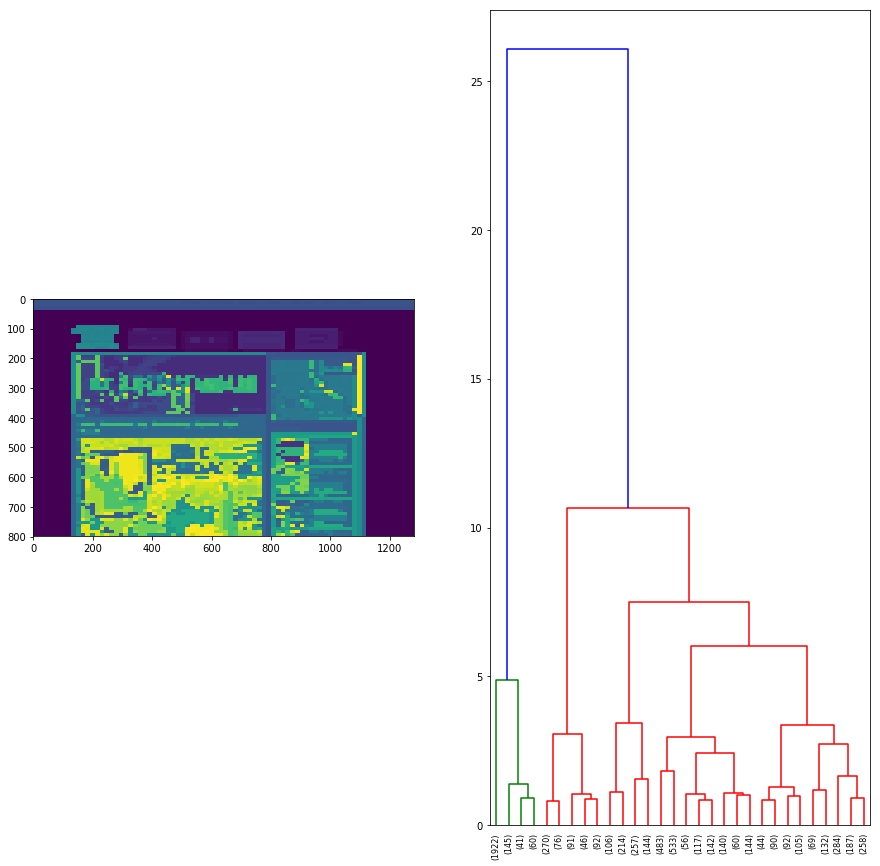

40 5.0886271977888855


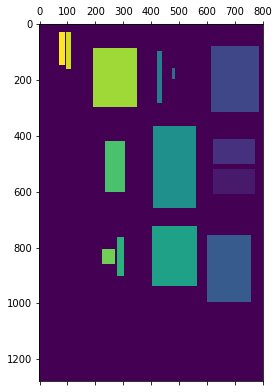

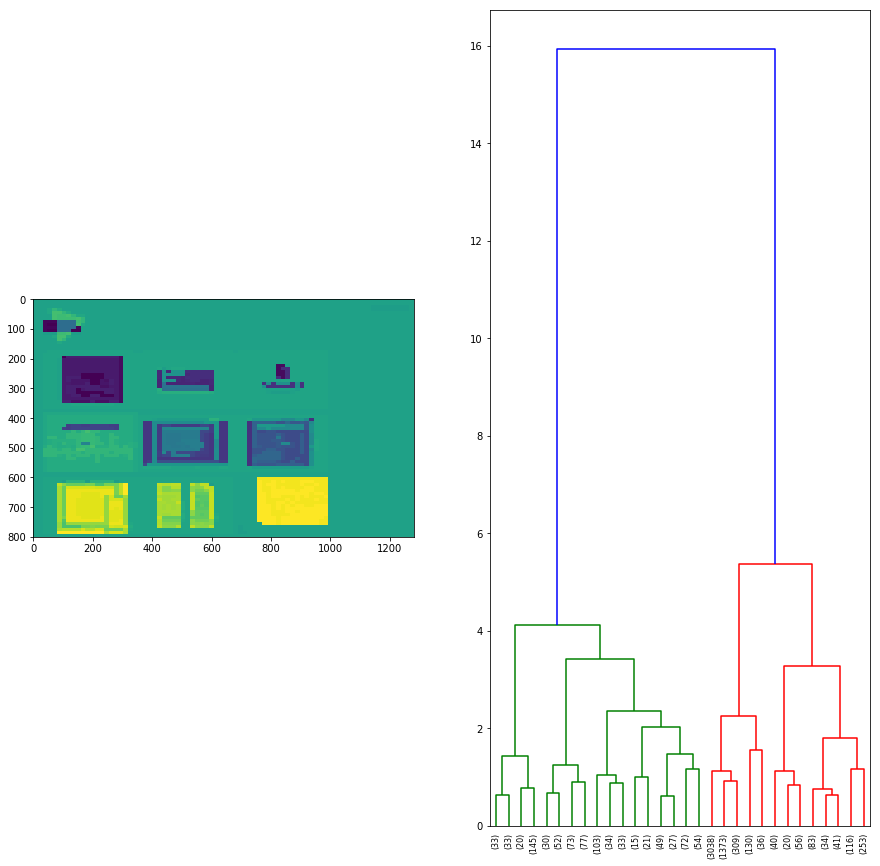

41 3.261111346773407


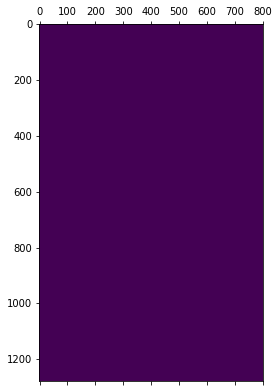

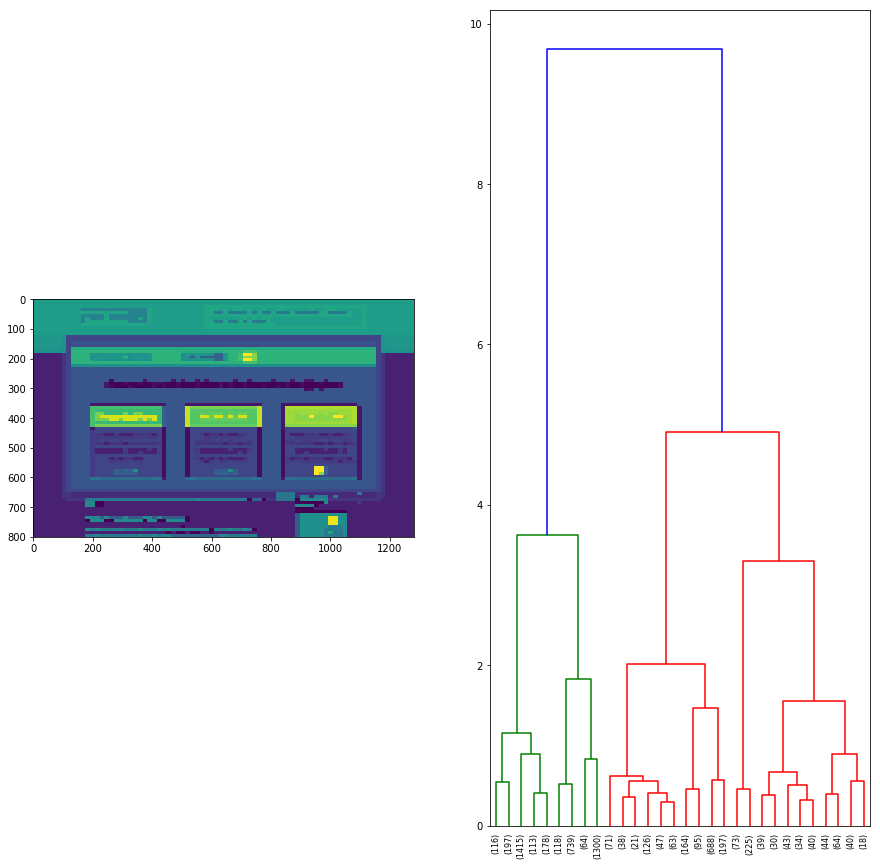

42 3.7890492836517224


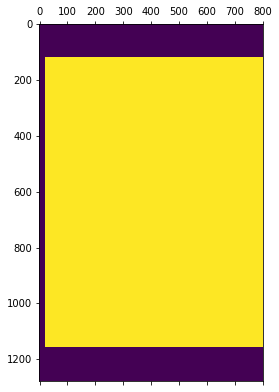

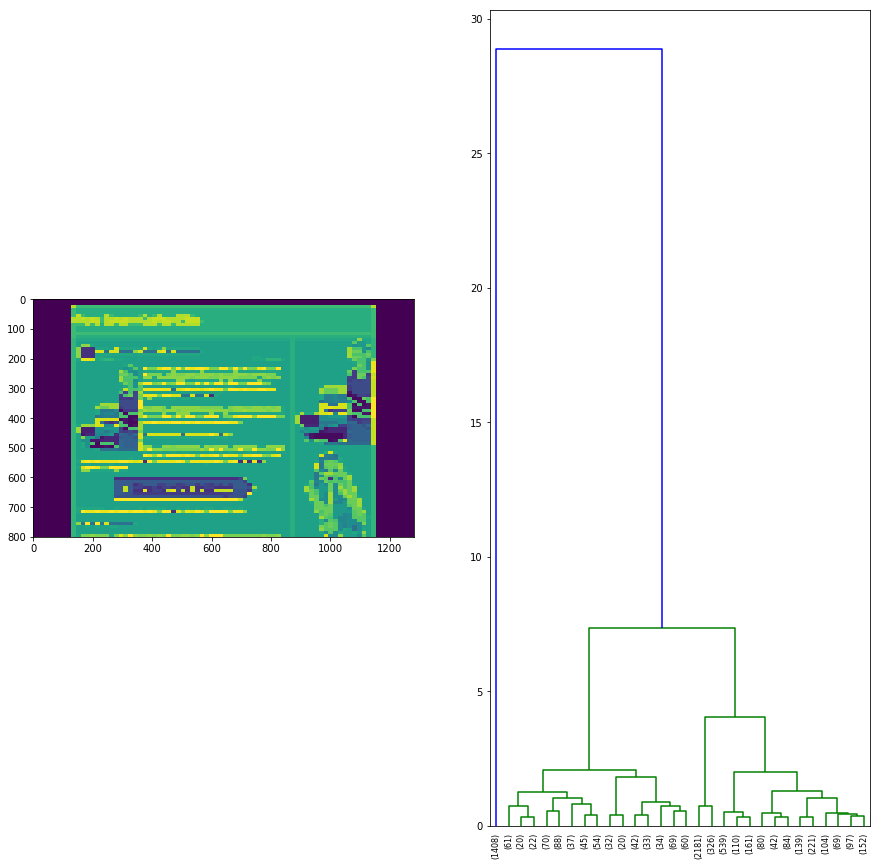

43 3.4806377244138806


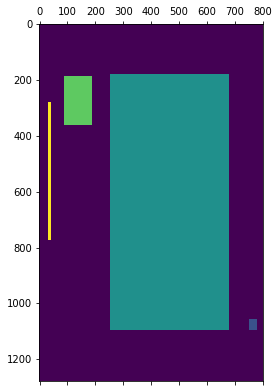

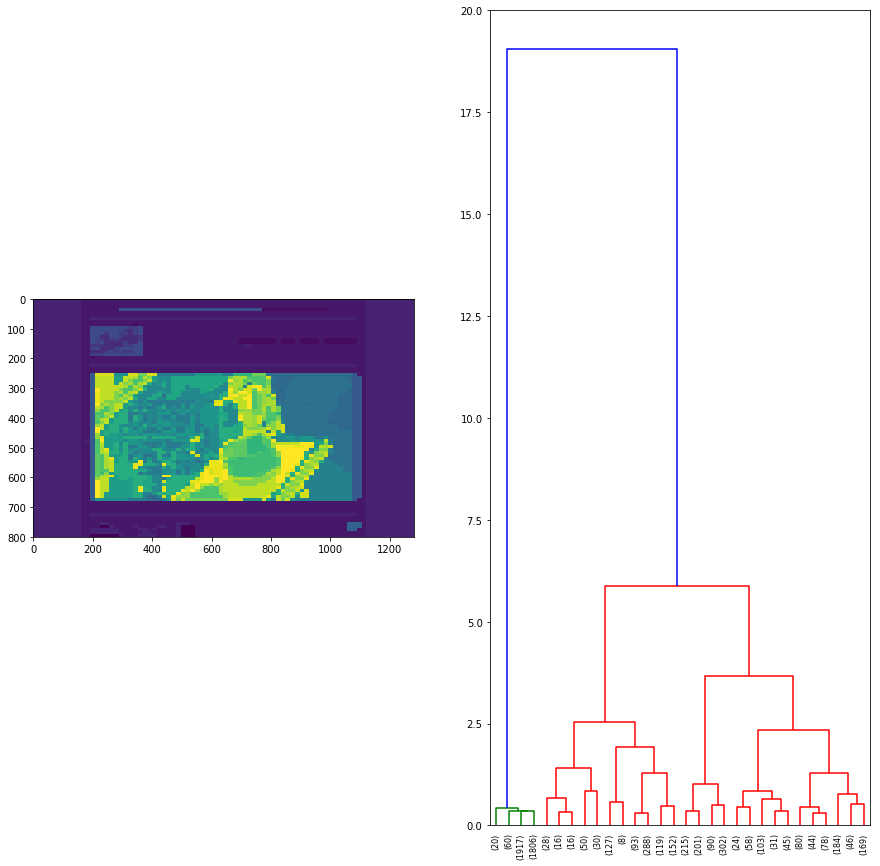

44 3.4680272981932596


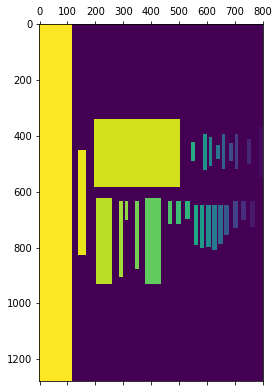

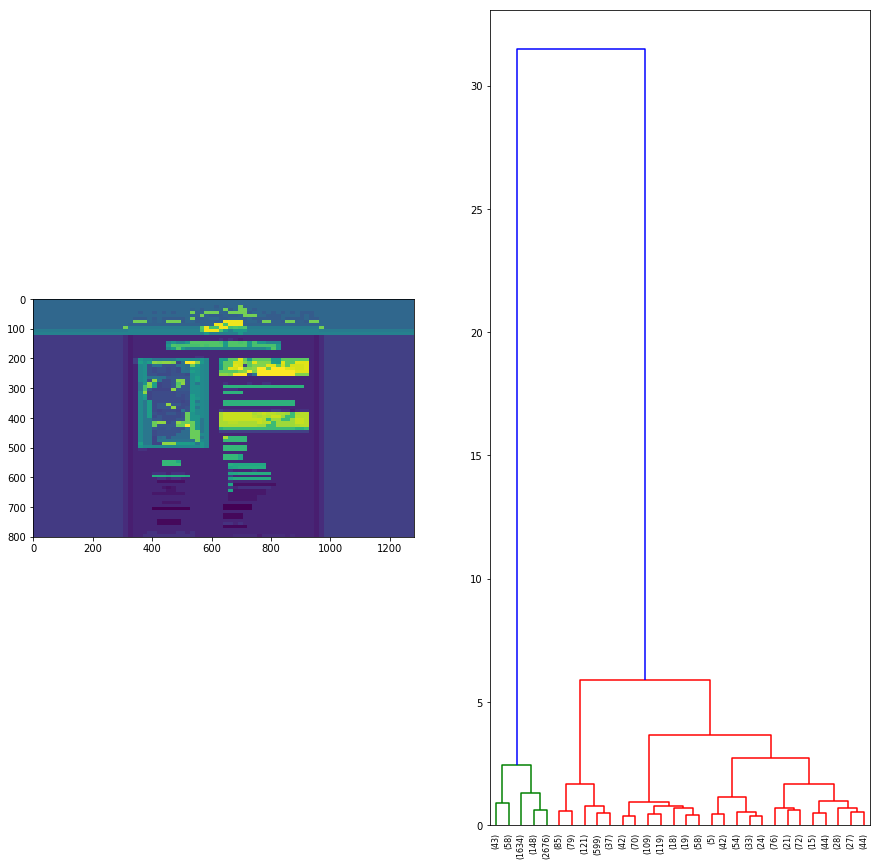

45 3.6119965784592747


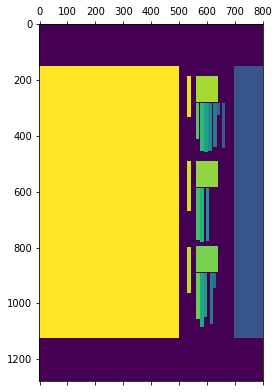

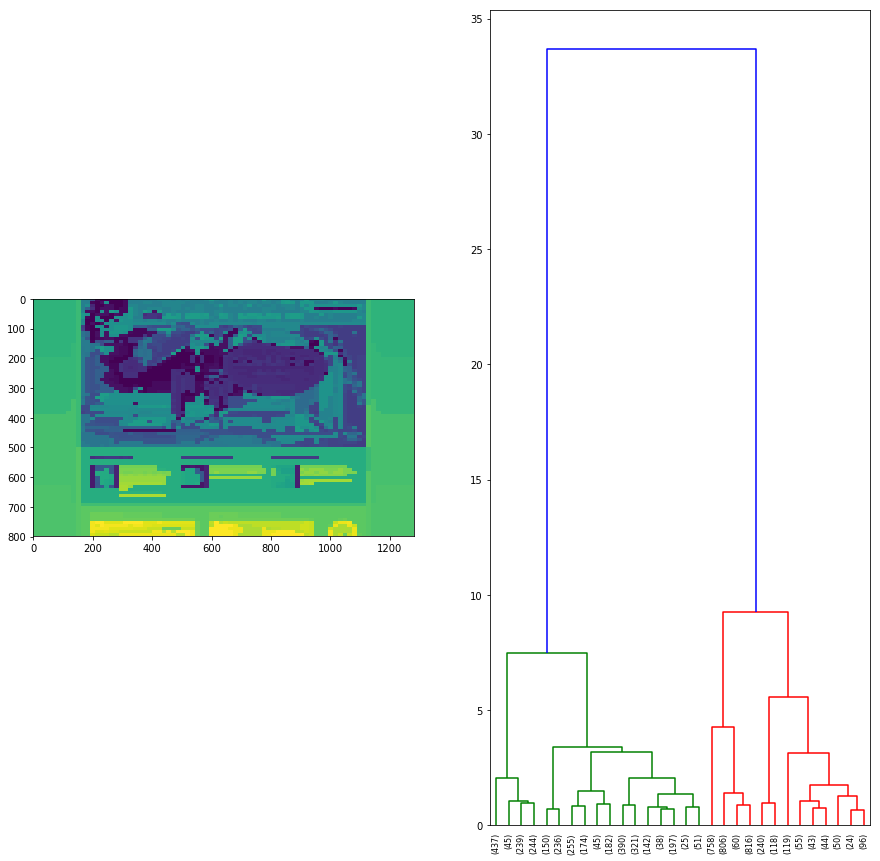

46 5.367555879682363


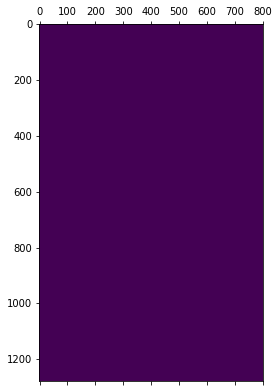

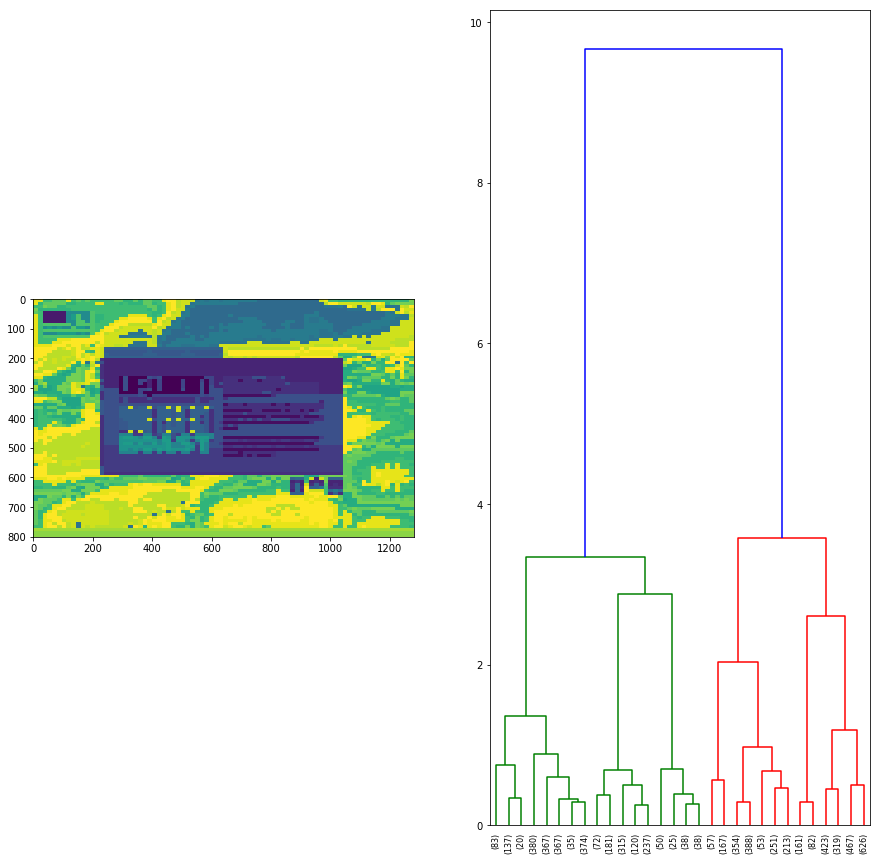

47 4.481949671633276


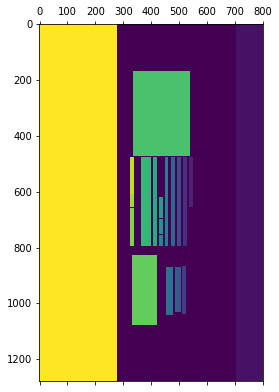

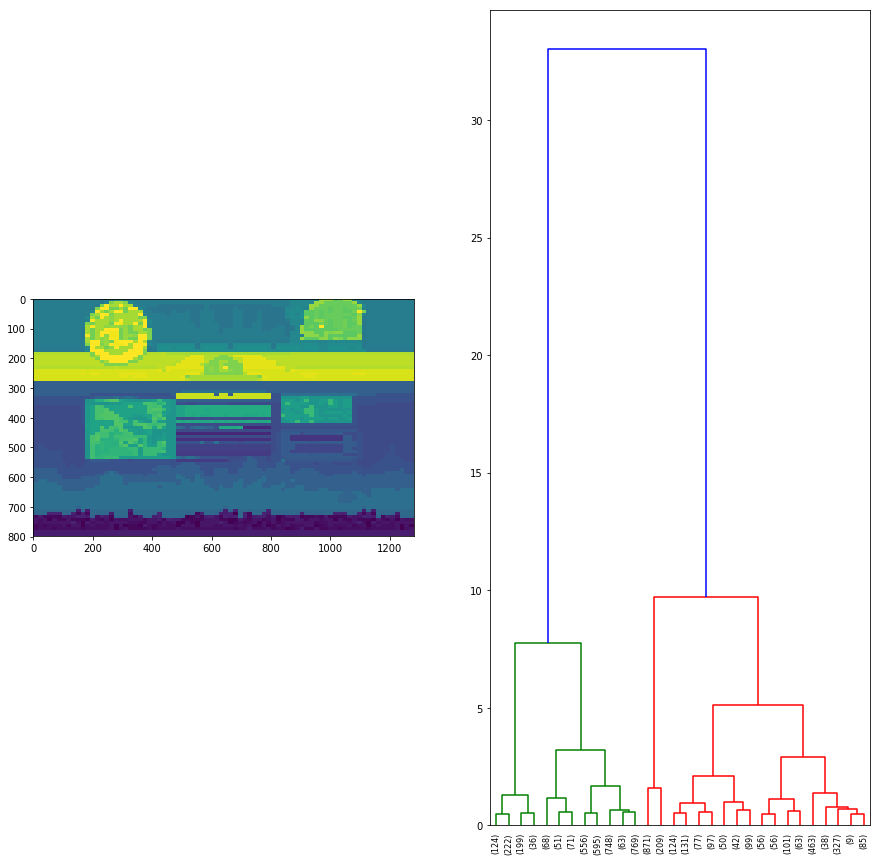

48 4.820428916844313


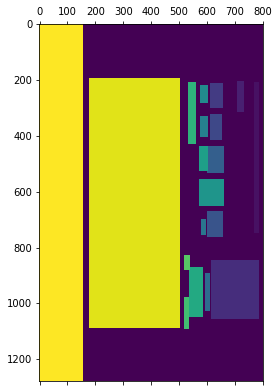

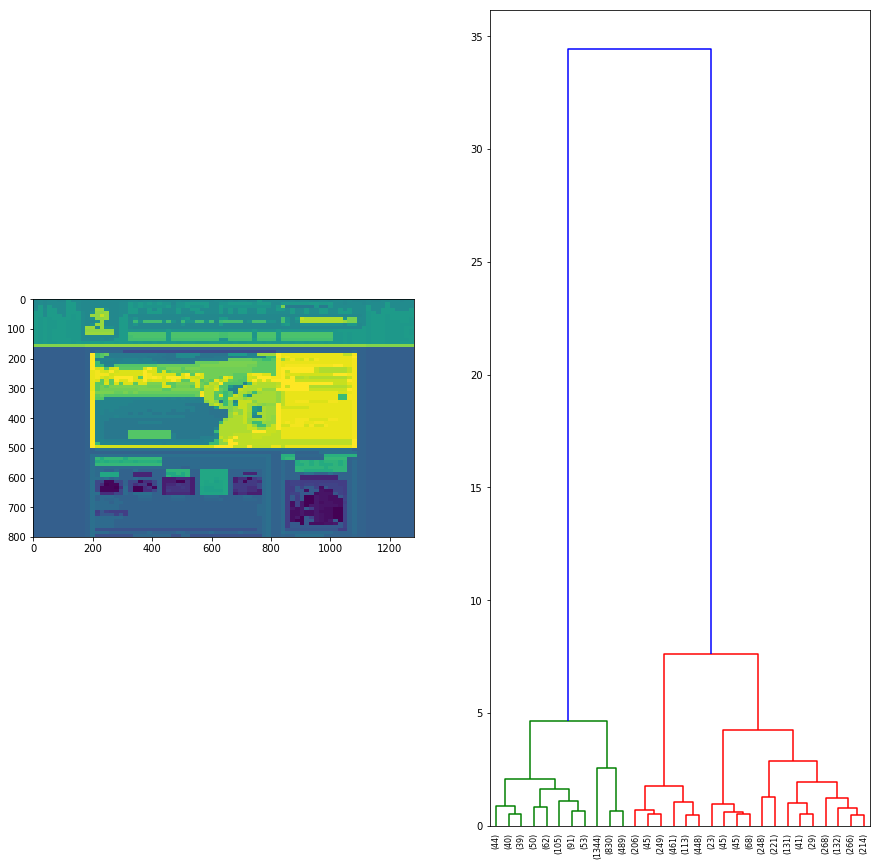

49 4.776166829785515


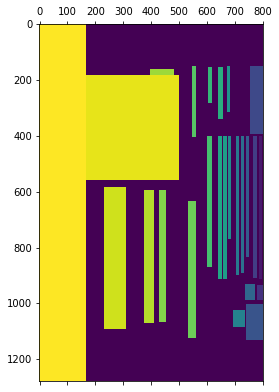

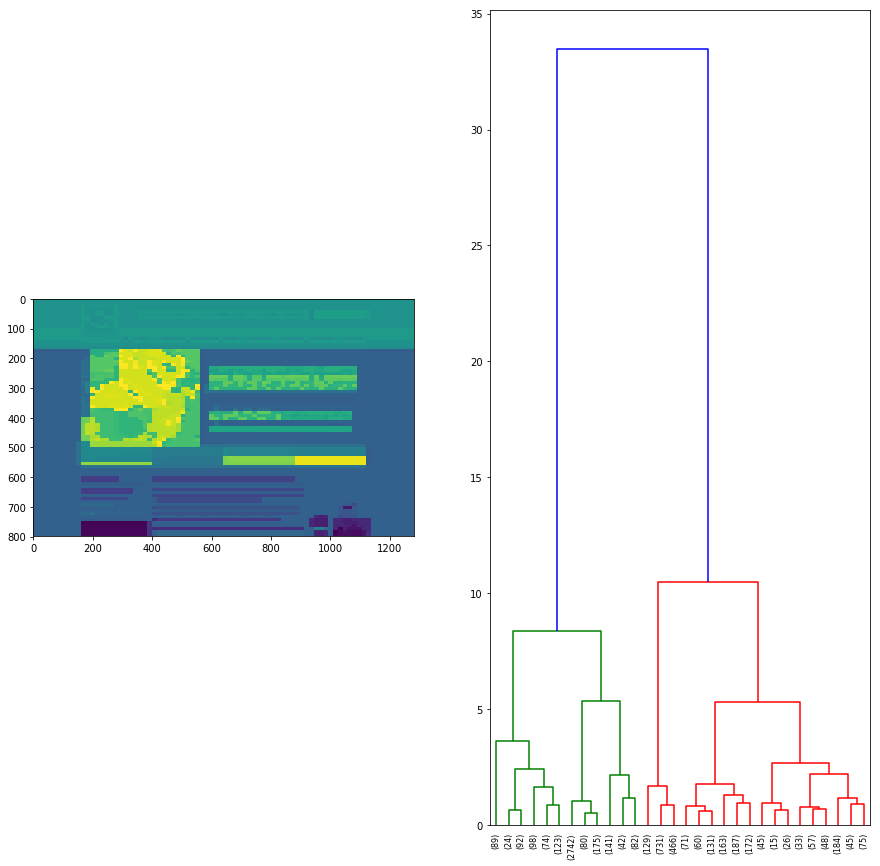

50 4.018978891307361


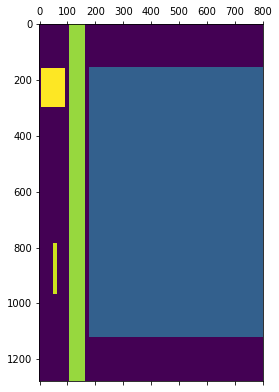

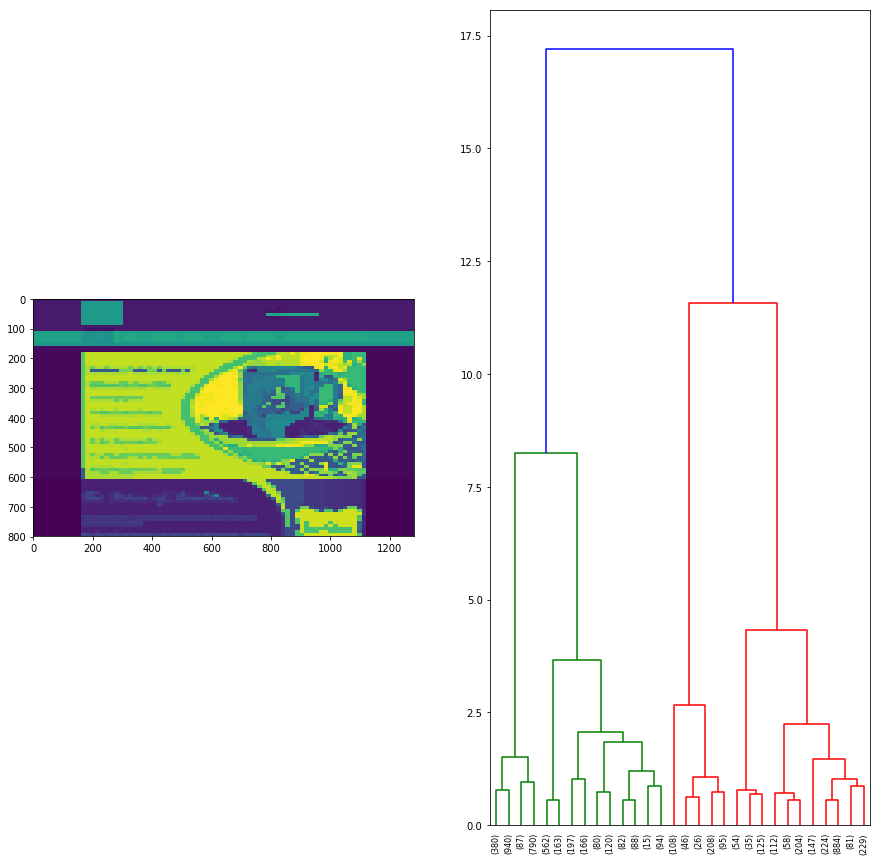

51 4.652982892355638


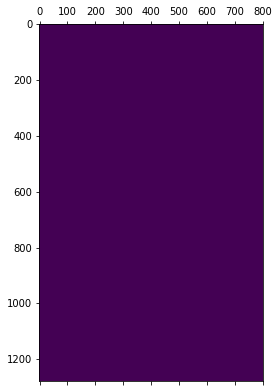

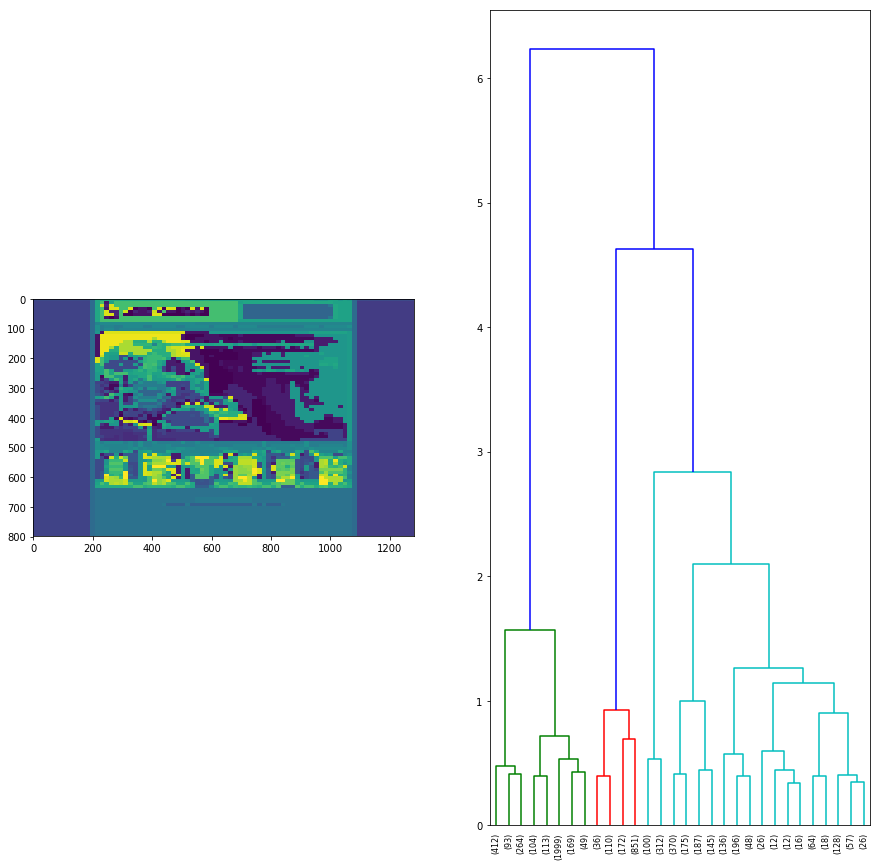

52 4.330599877421049


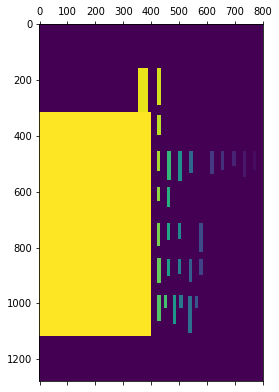

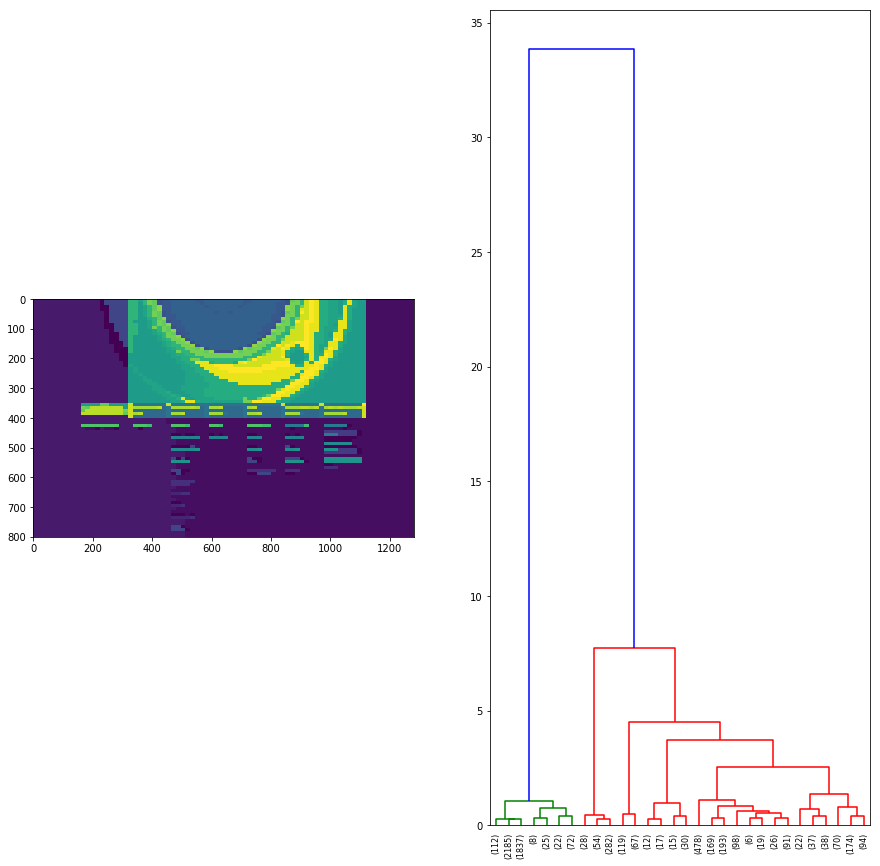

53 3.0895989463083176


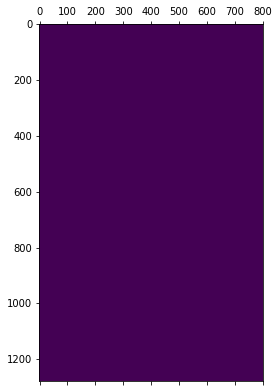

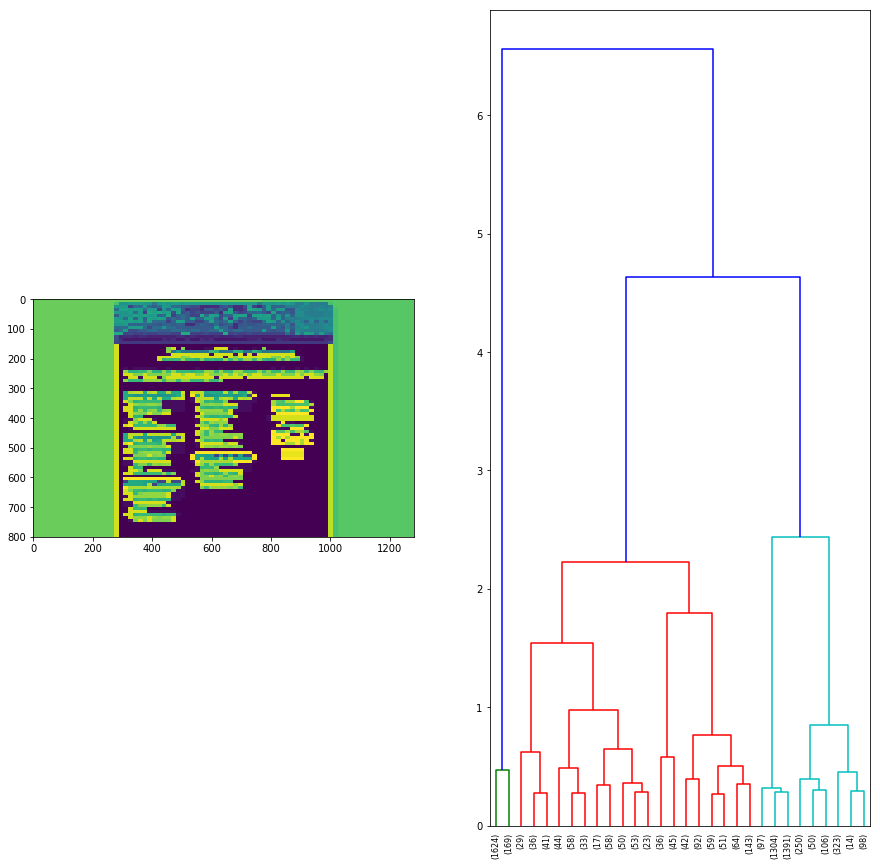

54 3.4234041588631157


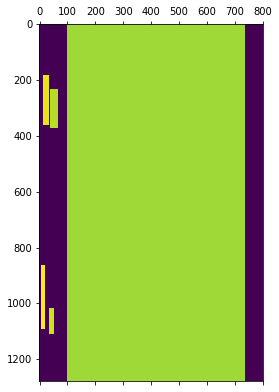

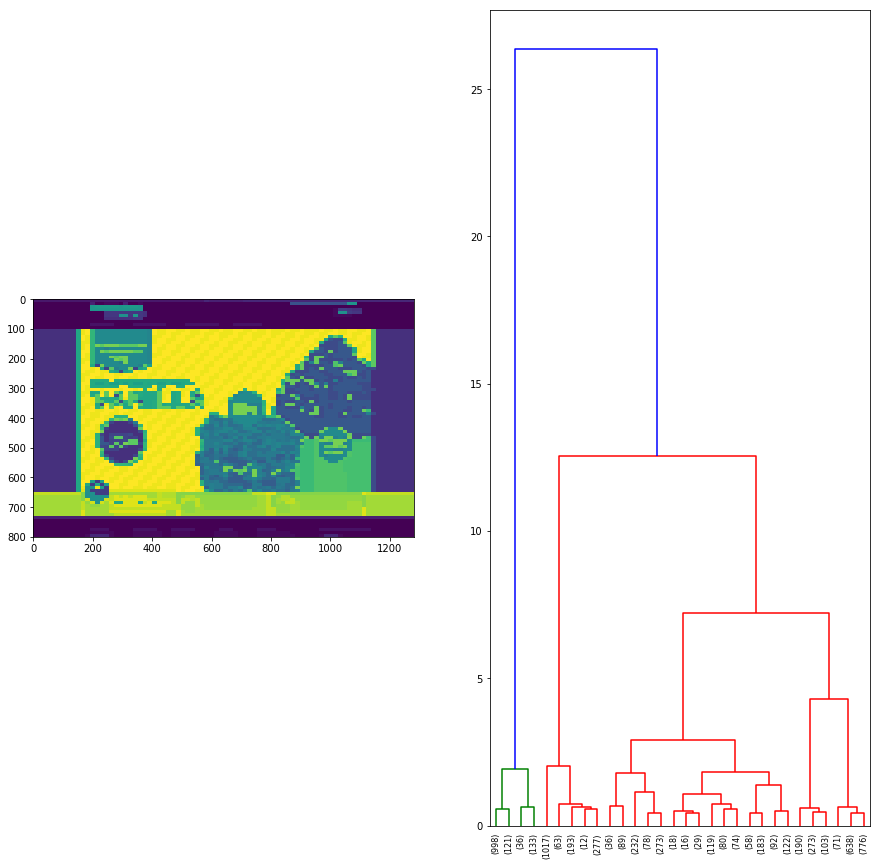

55 4.3268191917337395


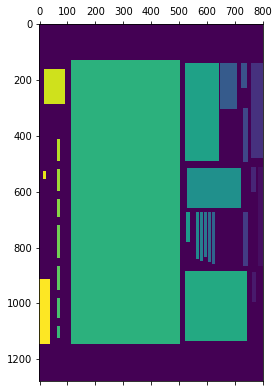

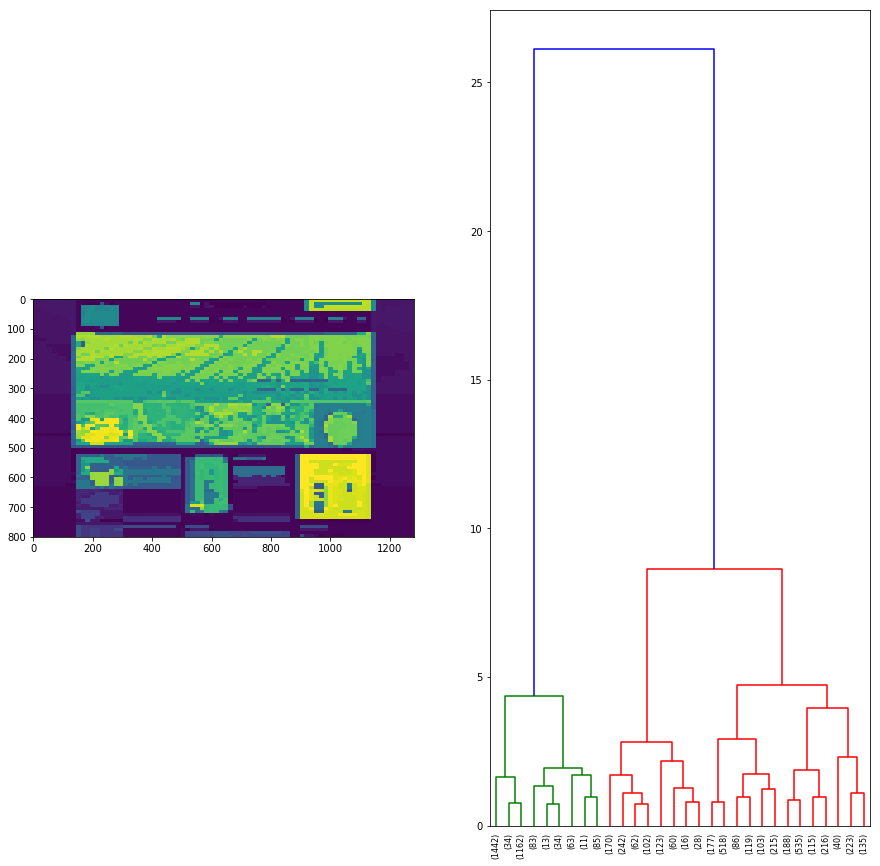

56 5.306156134714536


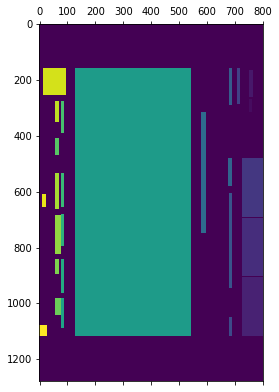

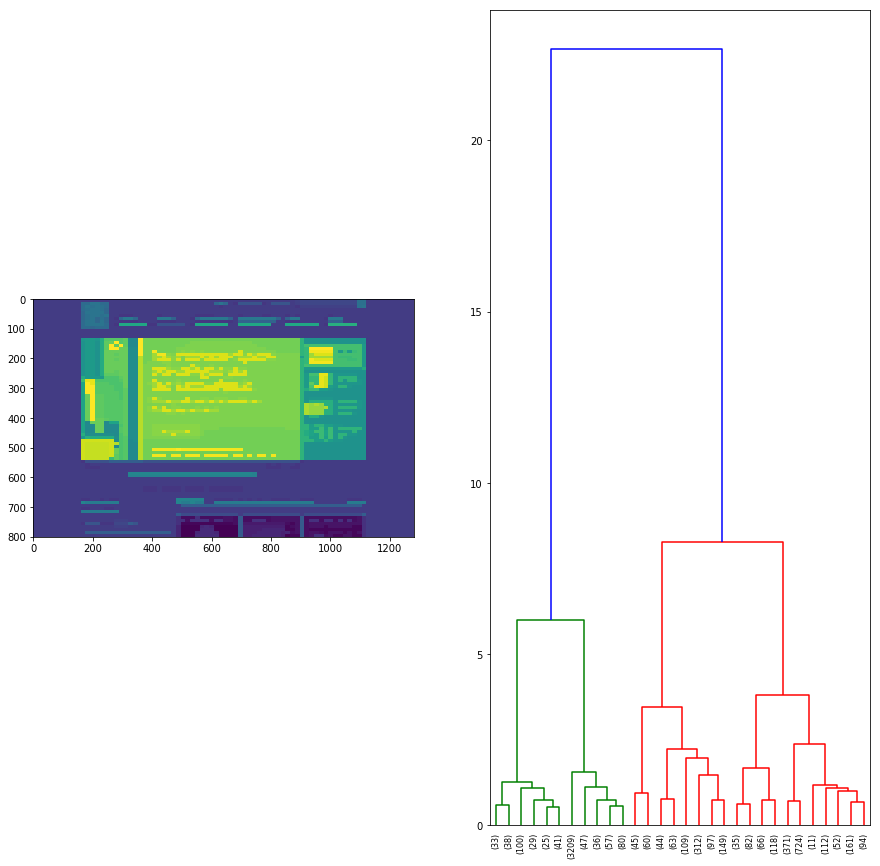

57 3.5334808842953076


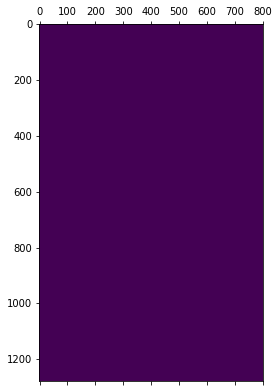

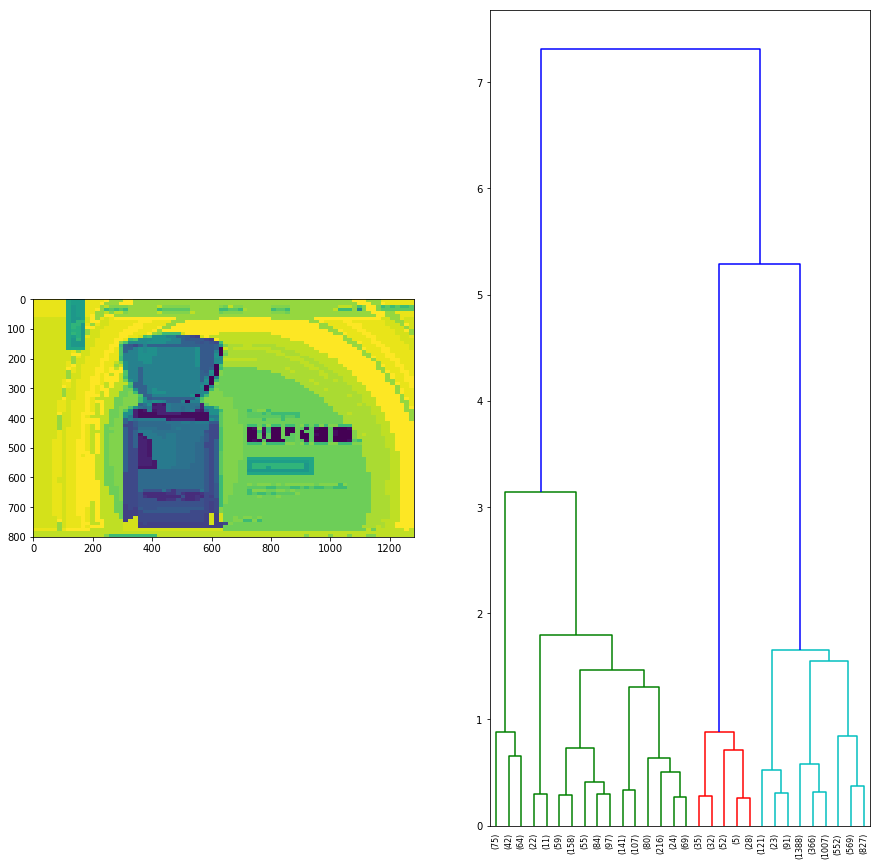

58 4.087751143746801


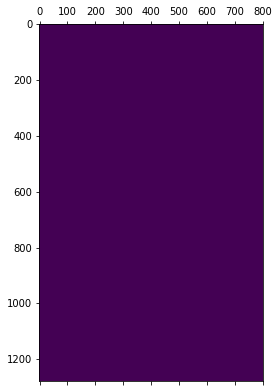

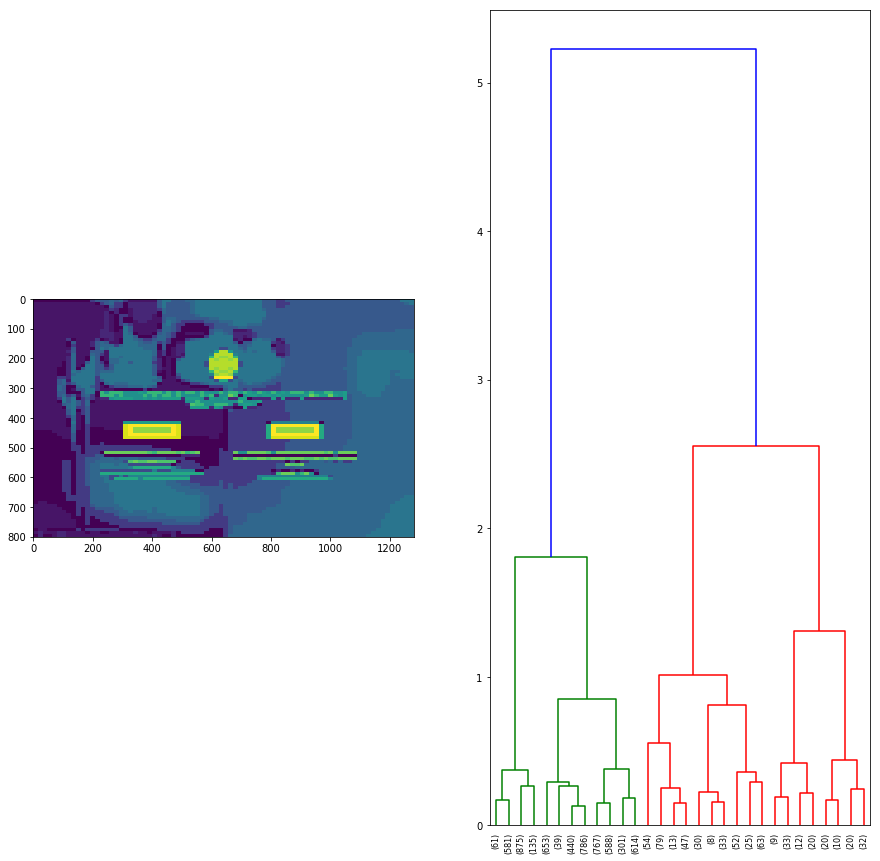

59 3.159260191759843


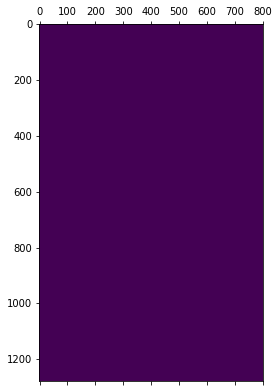

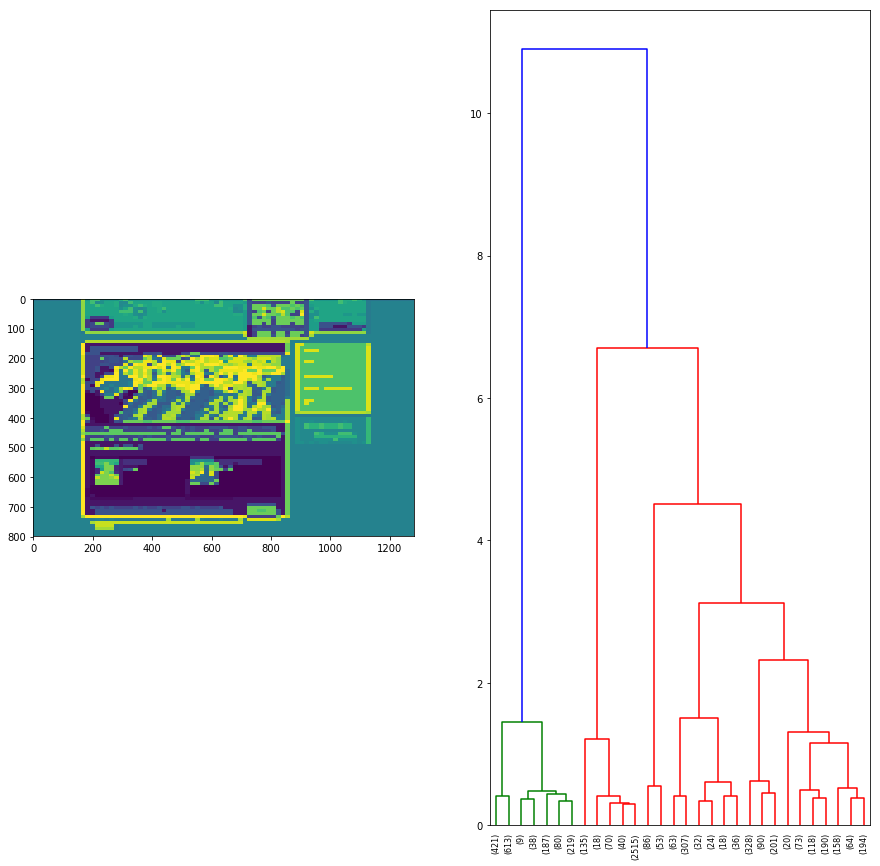

60 3.7888263614230455


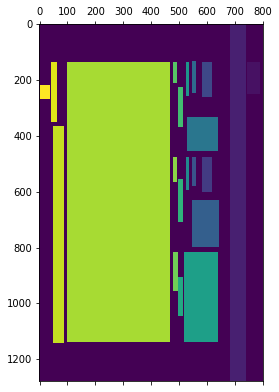

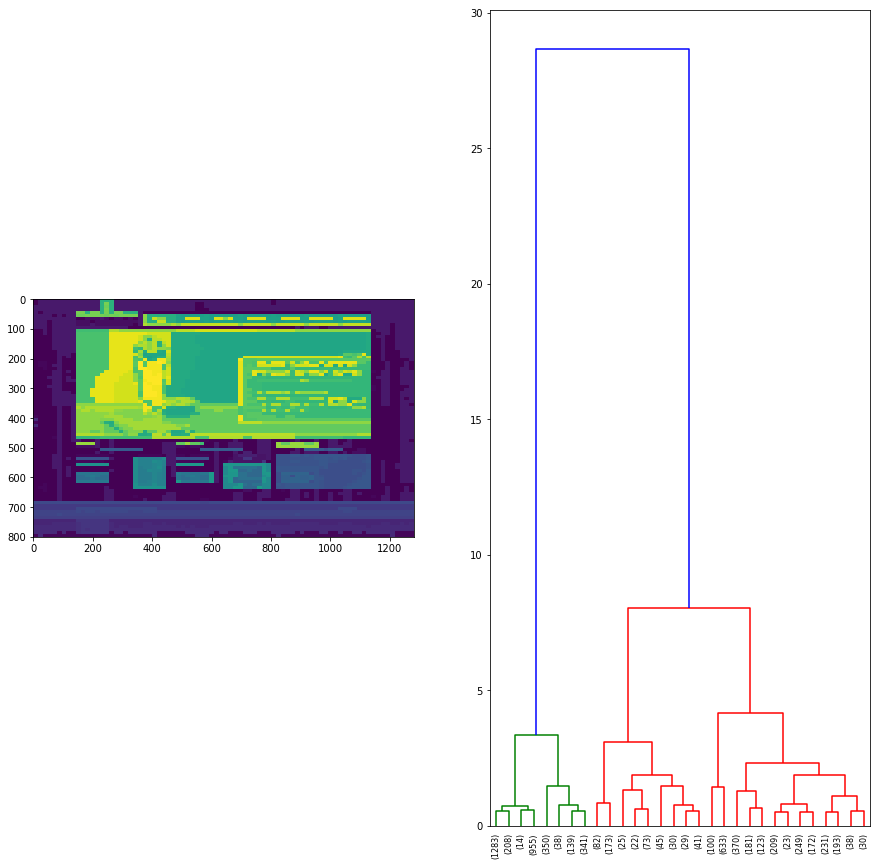

61 4.6475593859747395


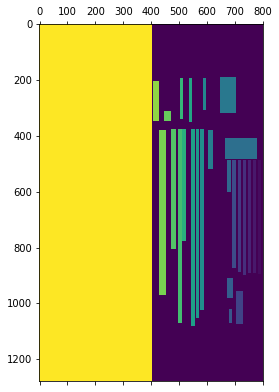

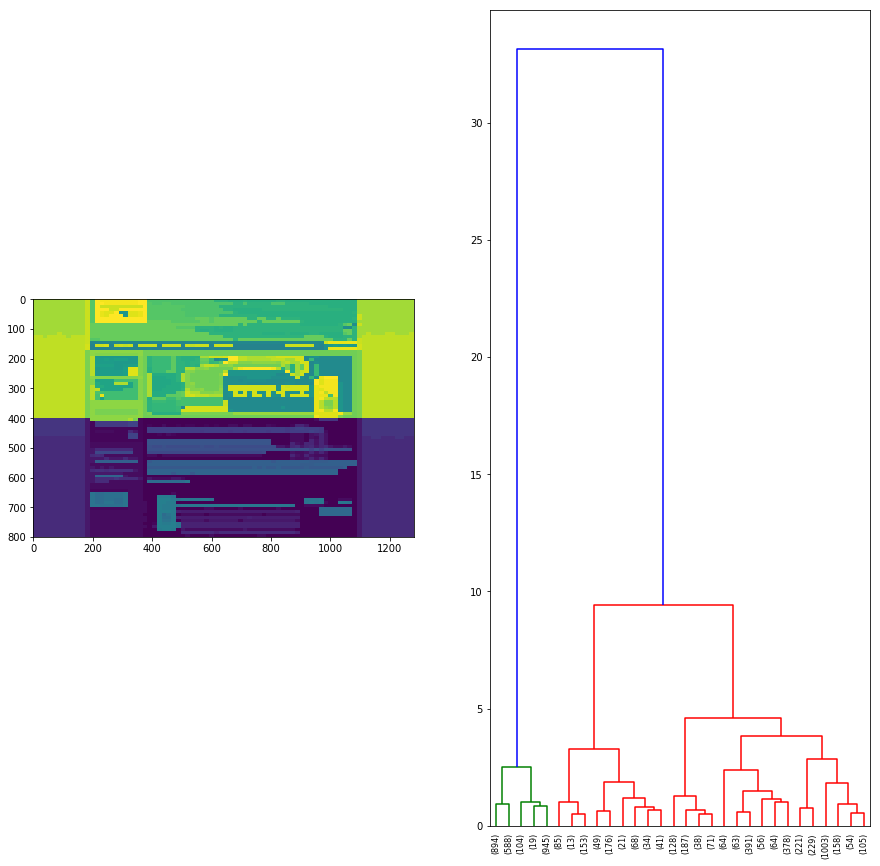

62 4.932312669519166


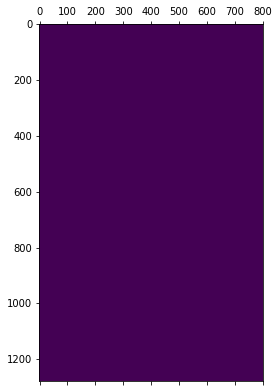

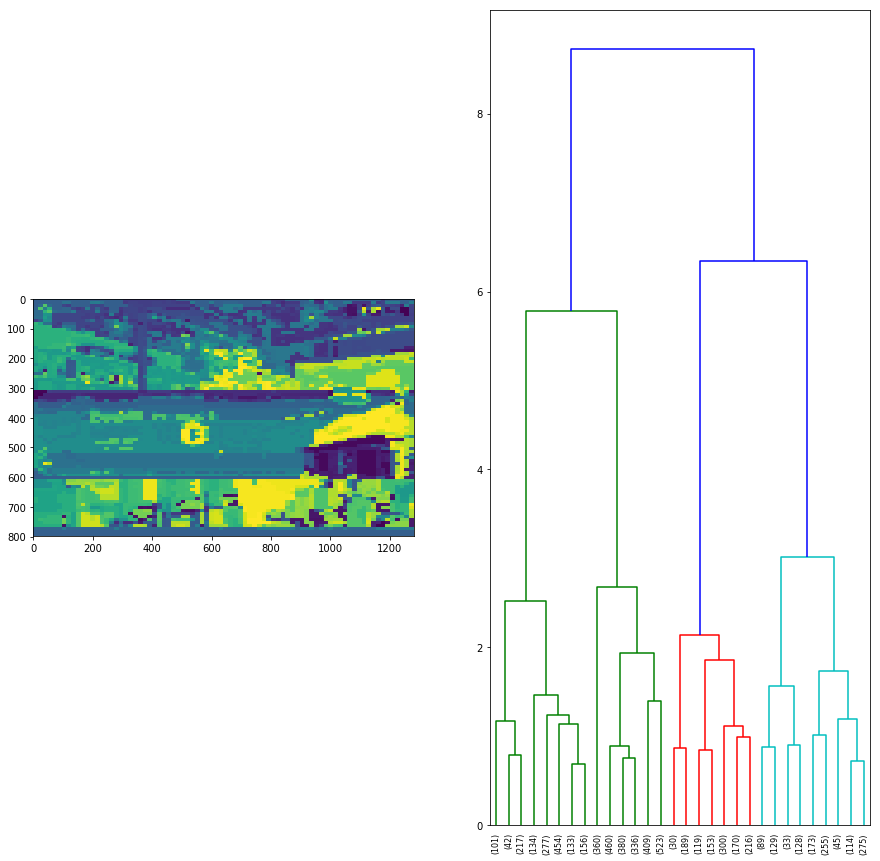

63 6.079070943603174


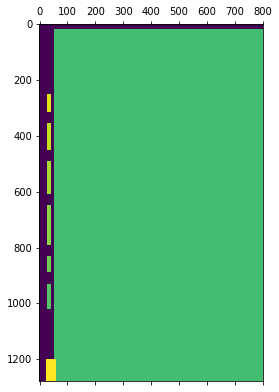

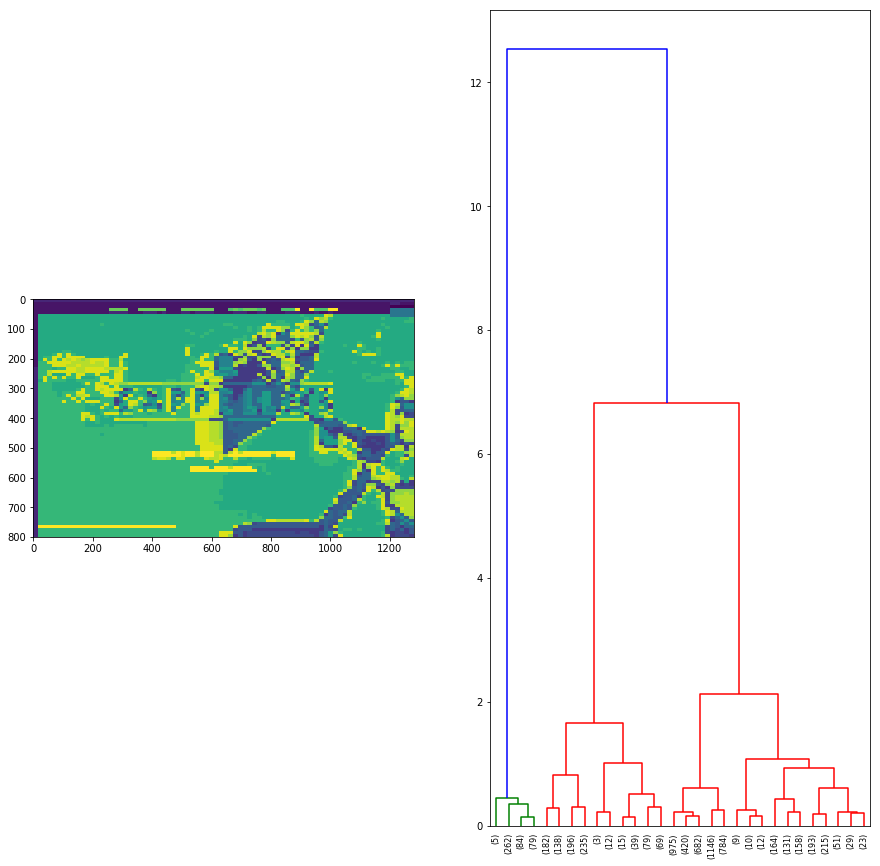

64 2.929915554446156


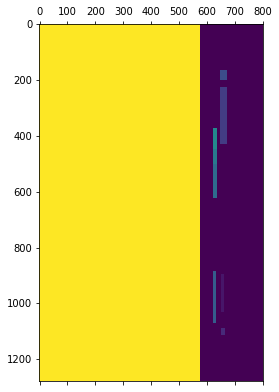

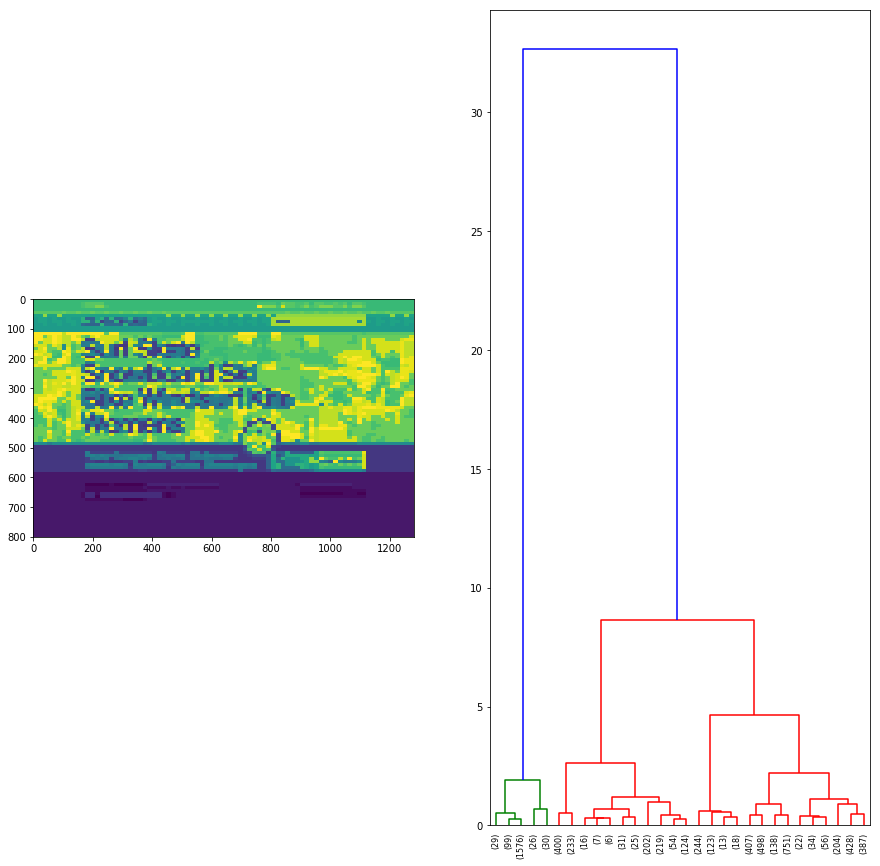

65 3.9294738351724146


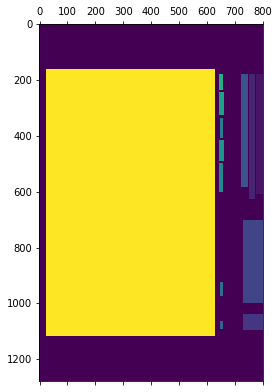

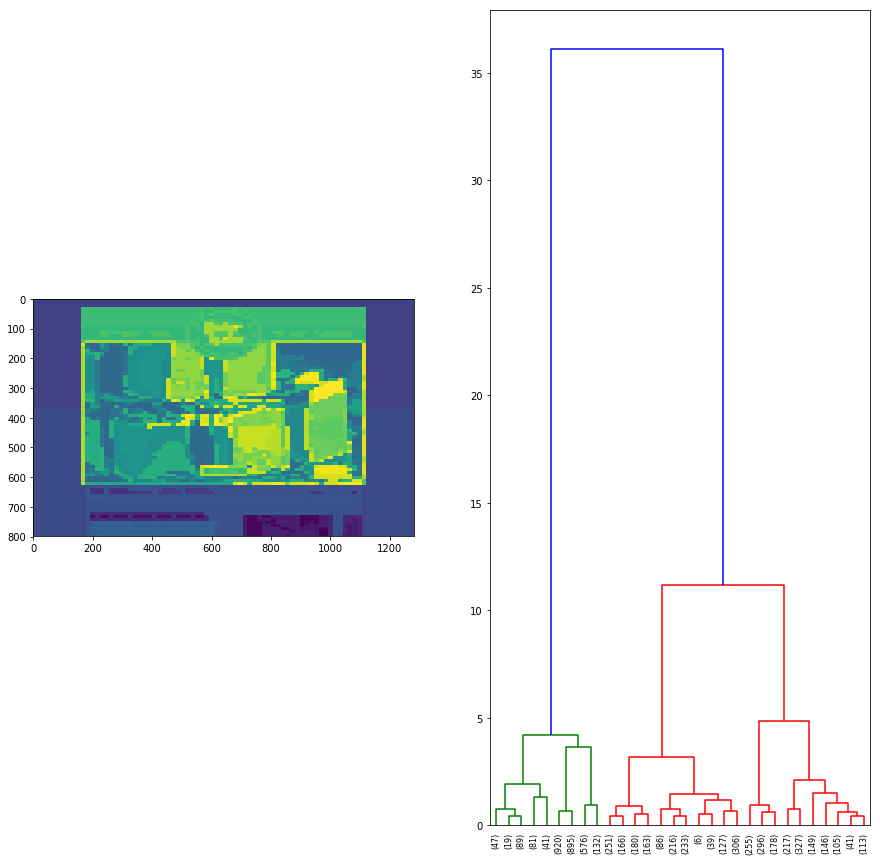

66 4.771324864232569


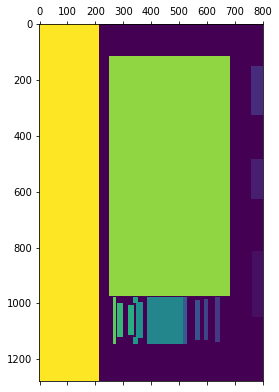

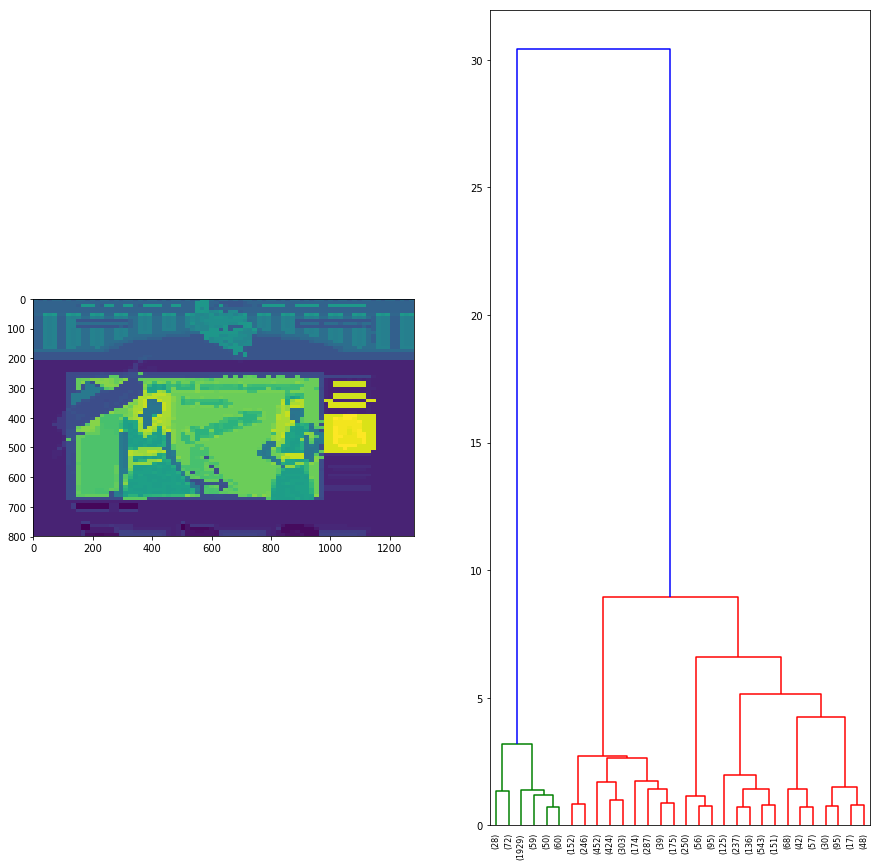

67 4.670909366574968


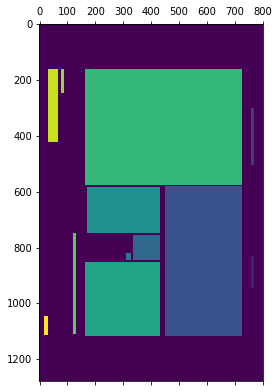

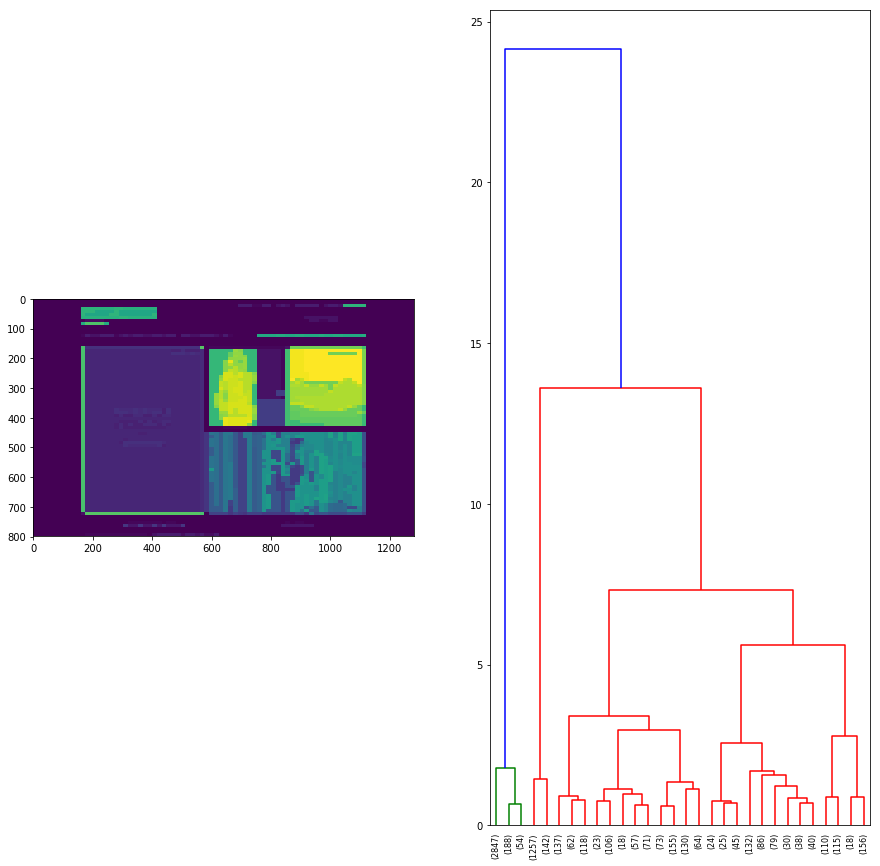

68 3.5778220113946038


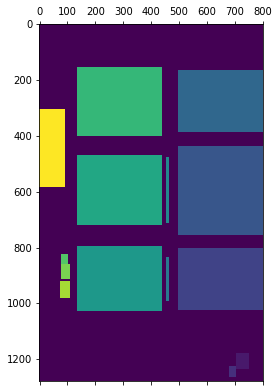

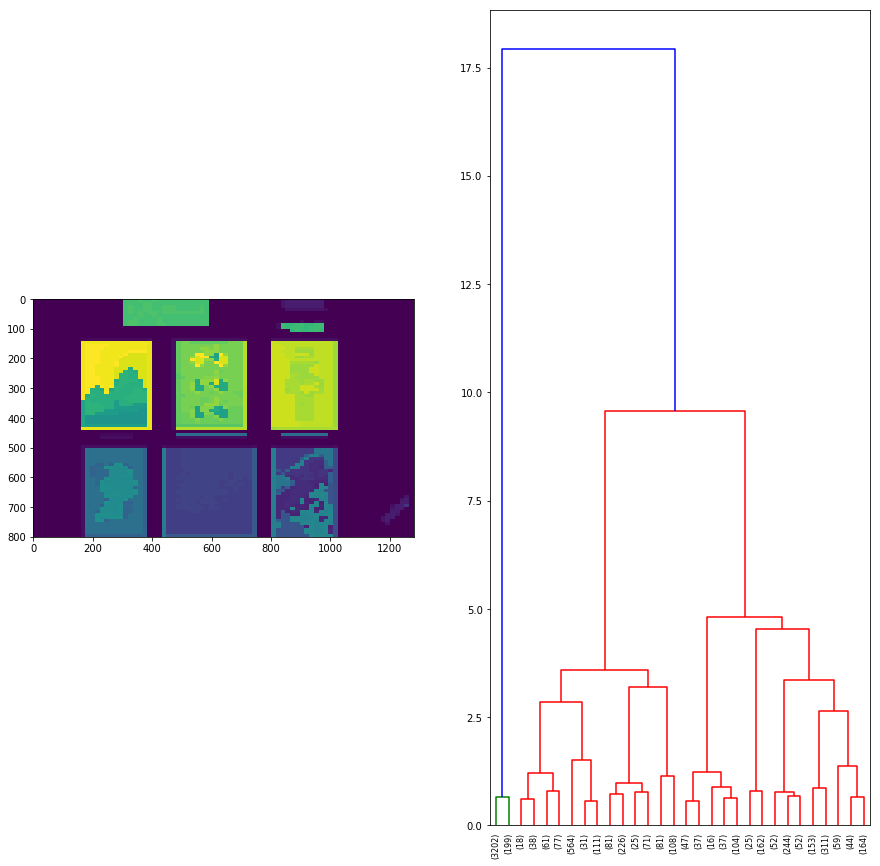

69 3.6162520568621486


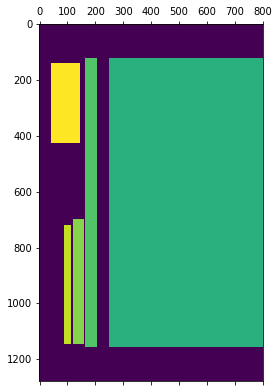

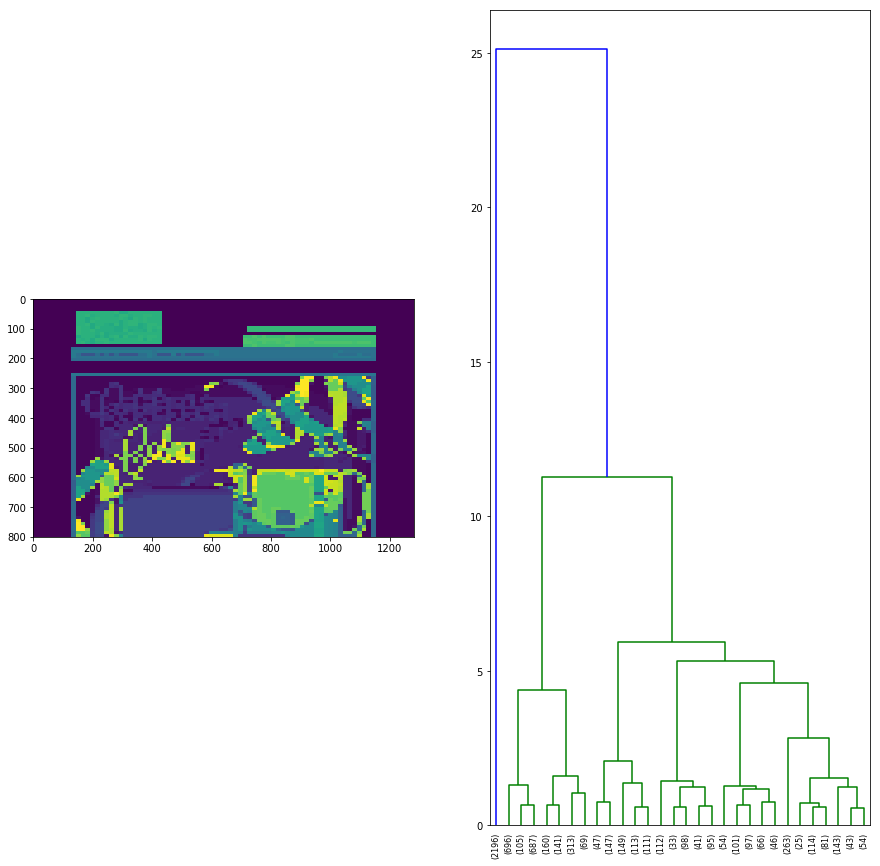

70 4.339837486330192


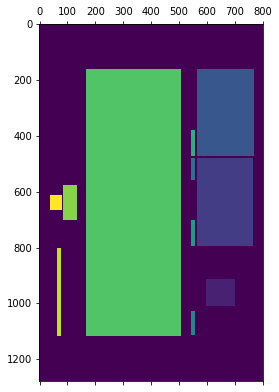

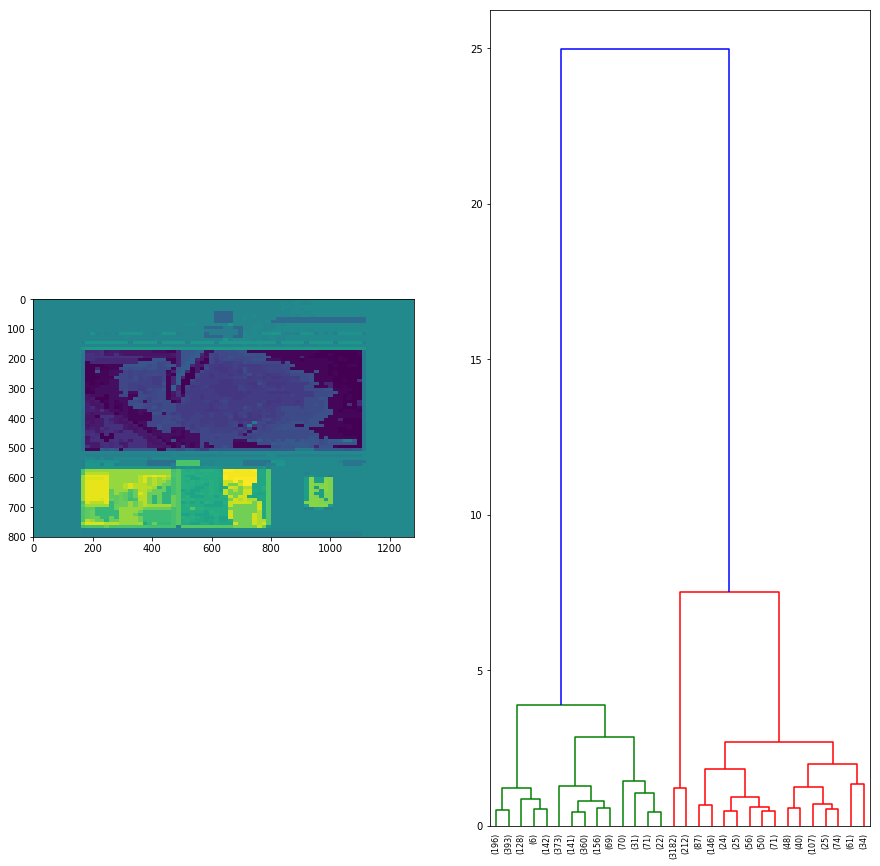

71 4.2403971438290835


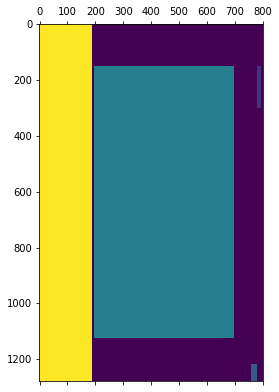

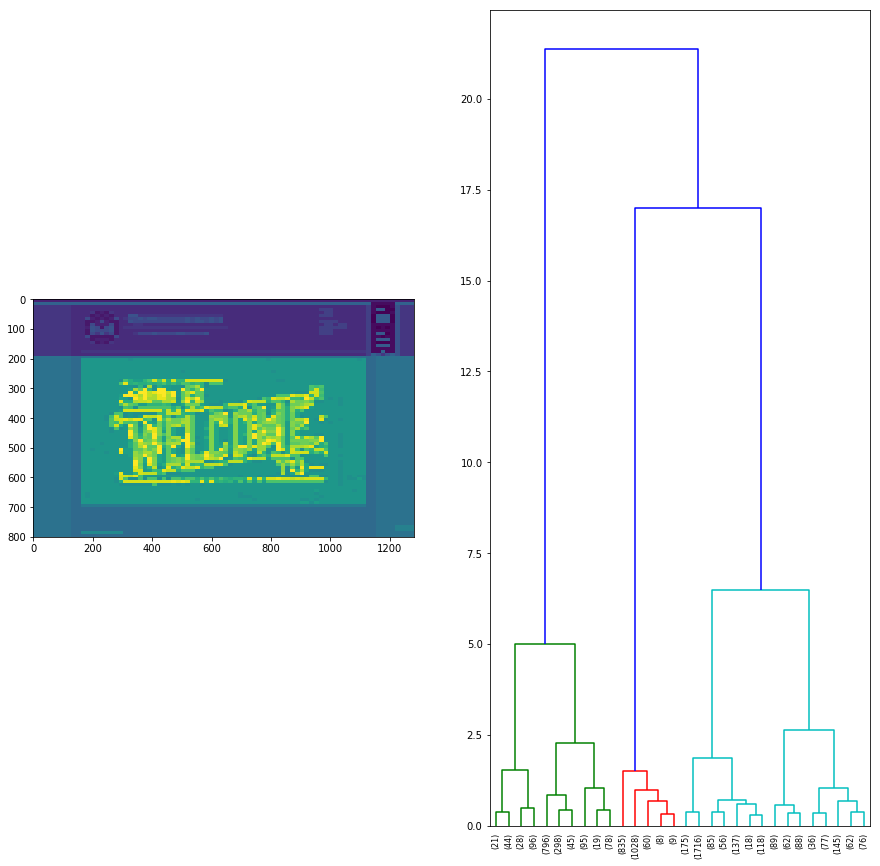

72 3.6407674217731576


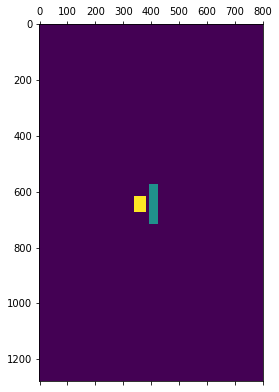

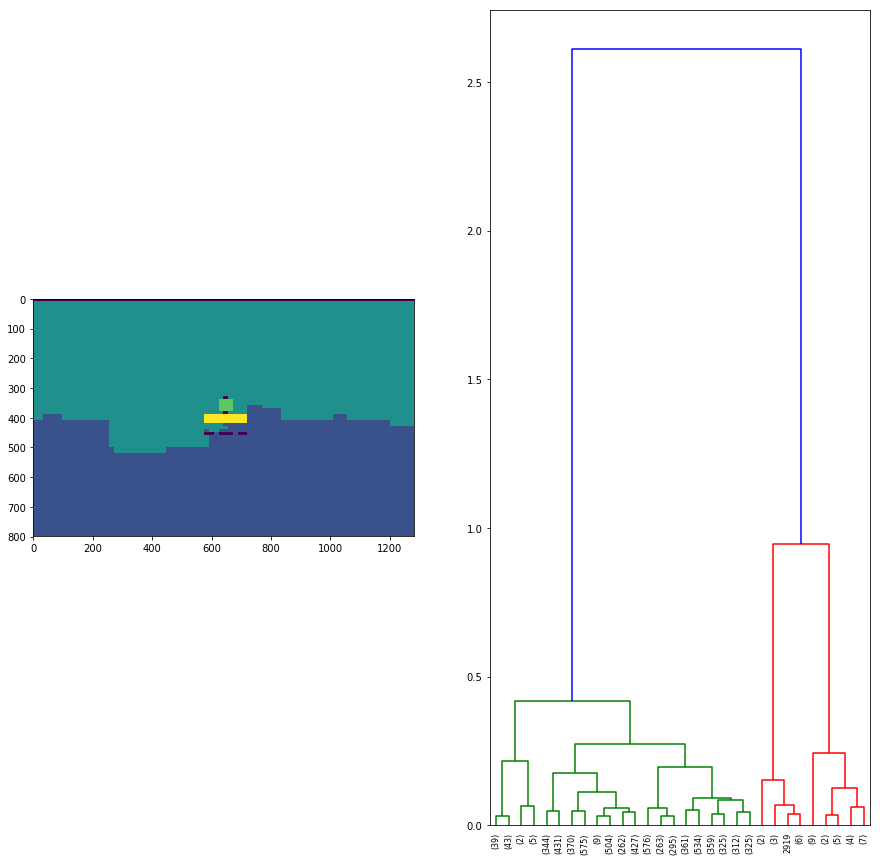

73 1.1412643167340666


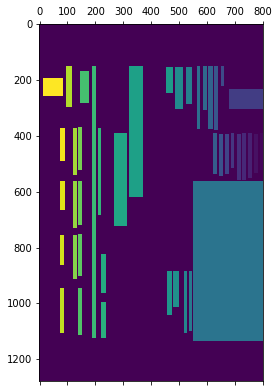

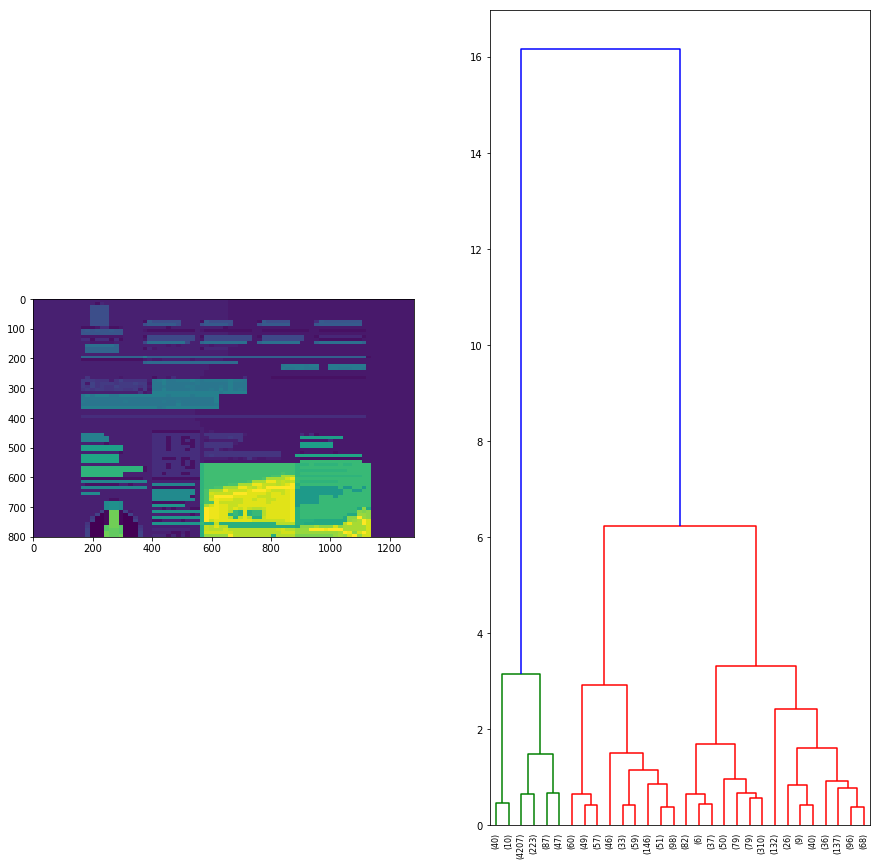

74 3.4589145693692847


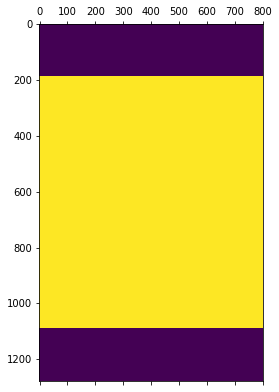

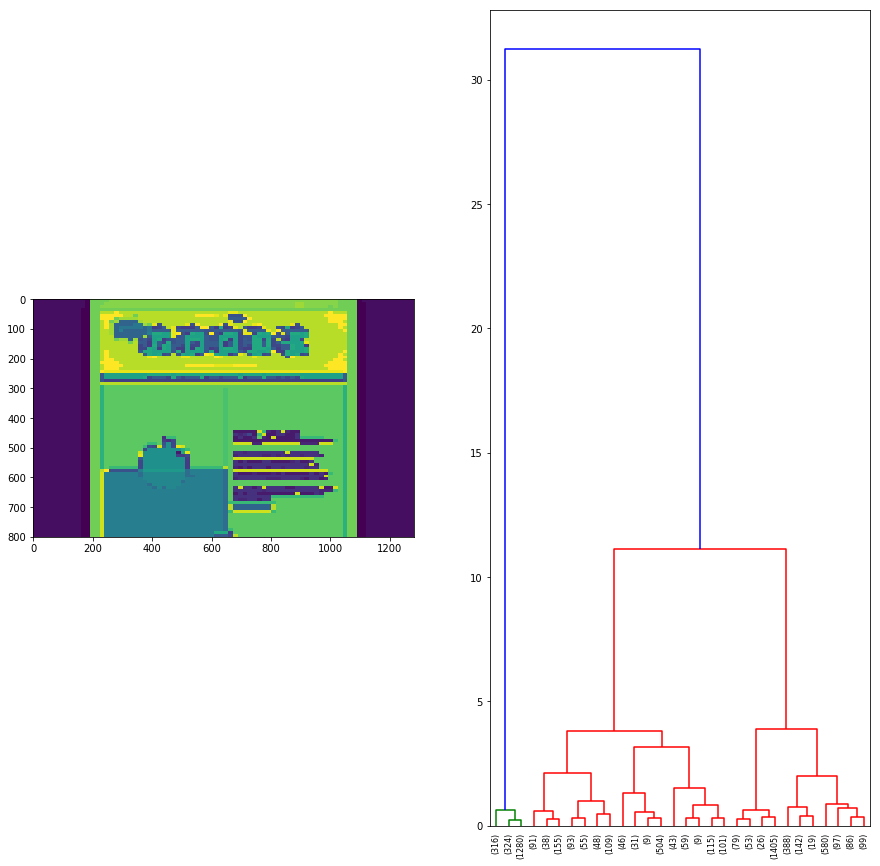

75 3.612245935896814


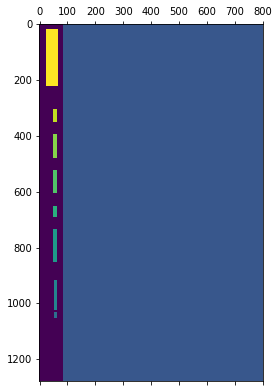

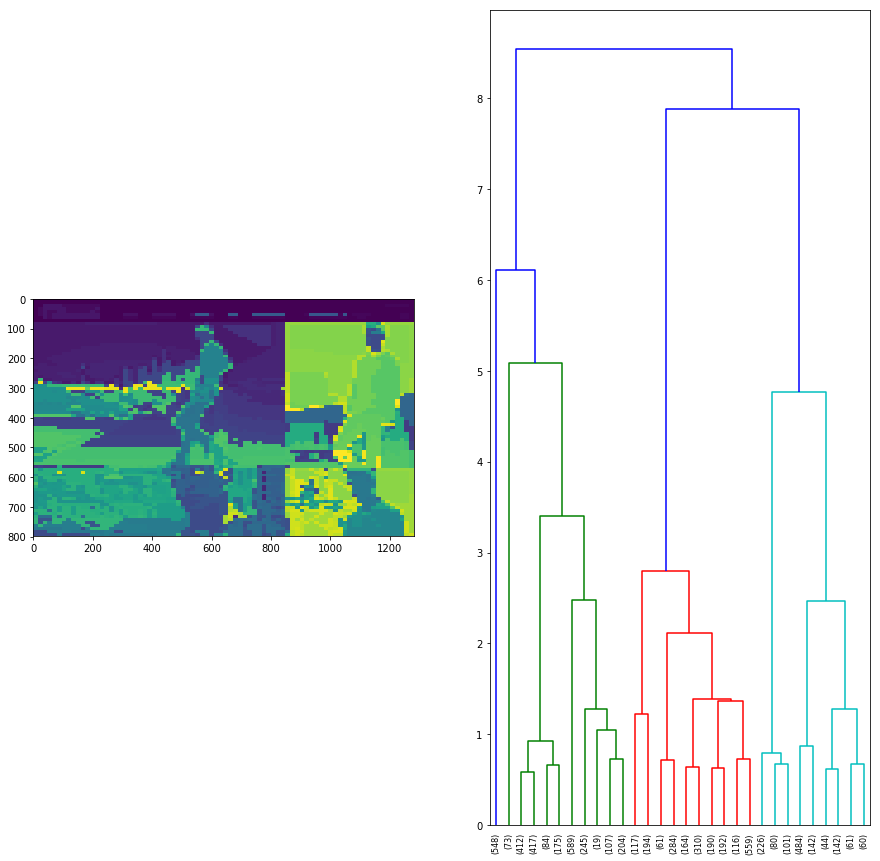

76 5.664872667595458


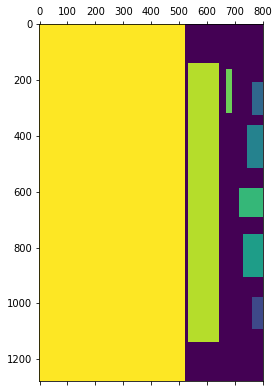

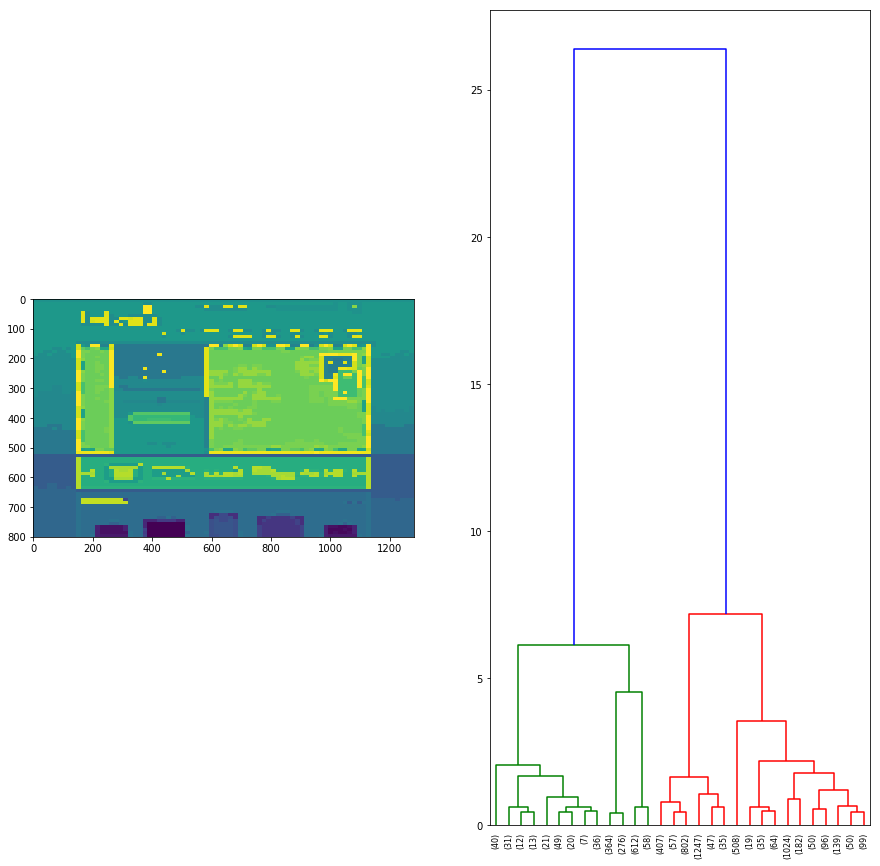

77 4.230656878182301


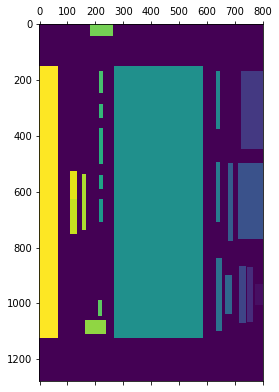

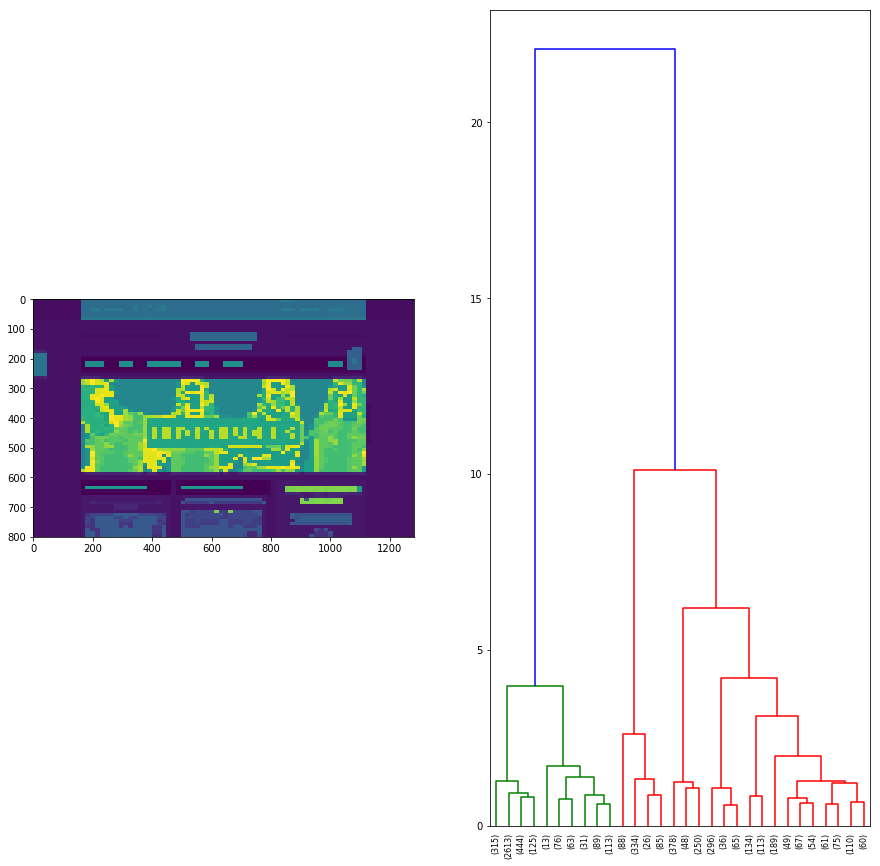

78 4.288769717971748


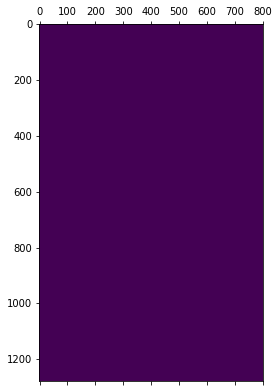

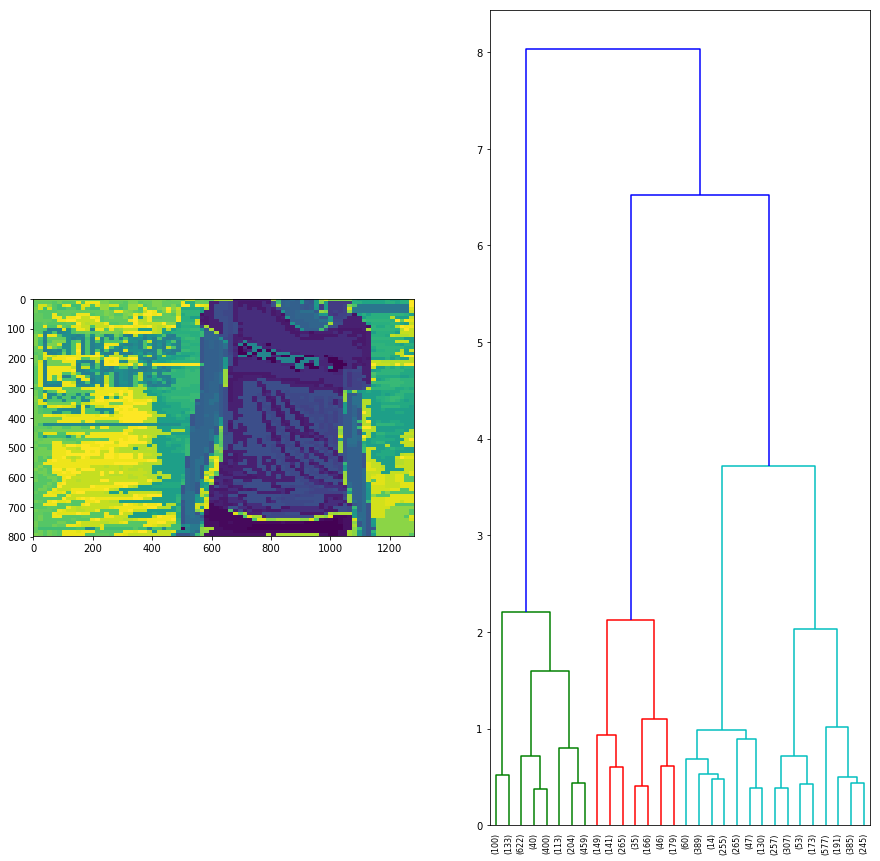

79 5.076084780156533


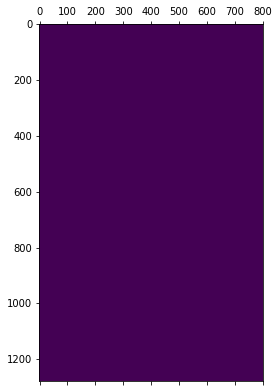

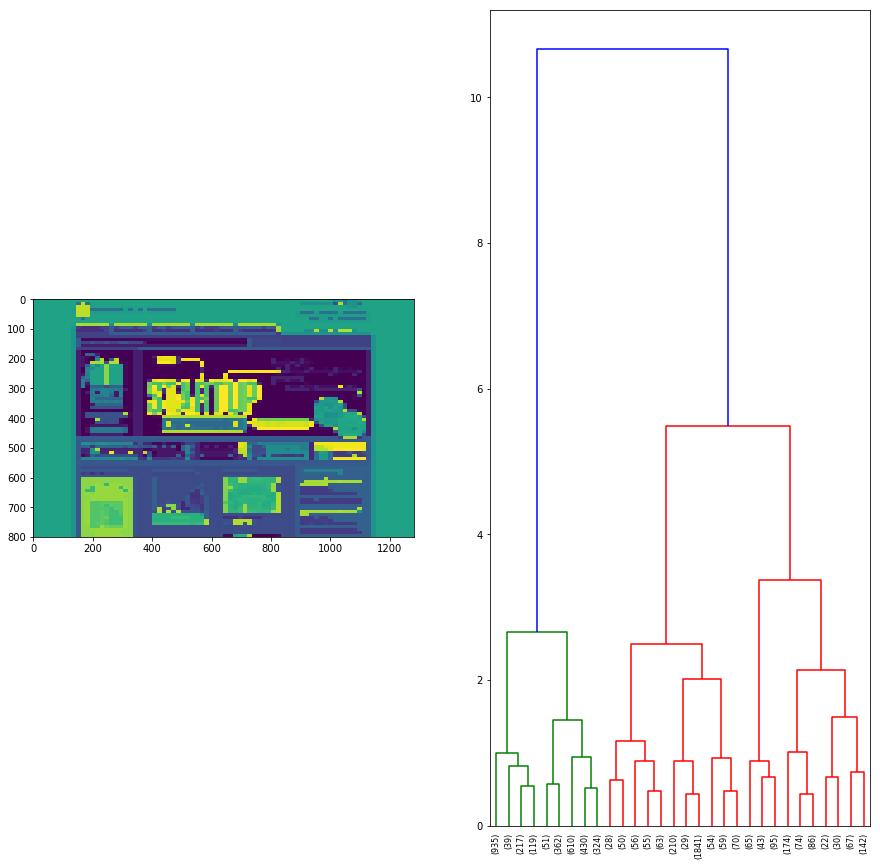

80 4.376556500155788


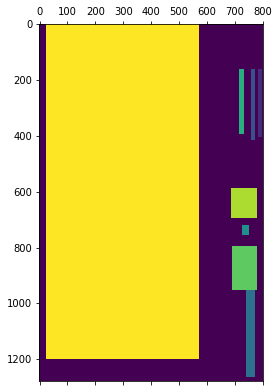

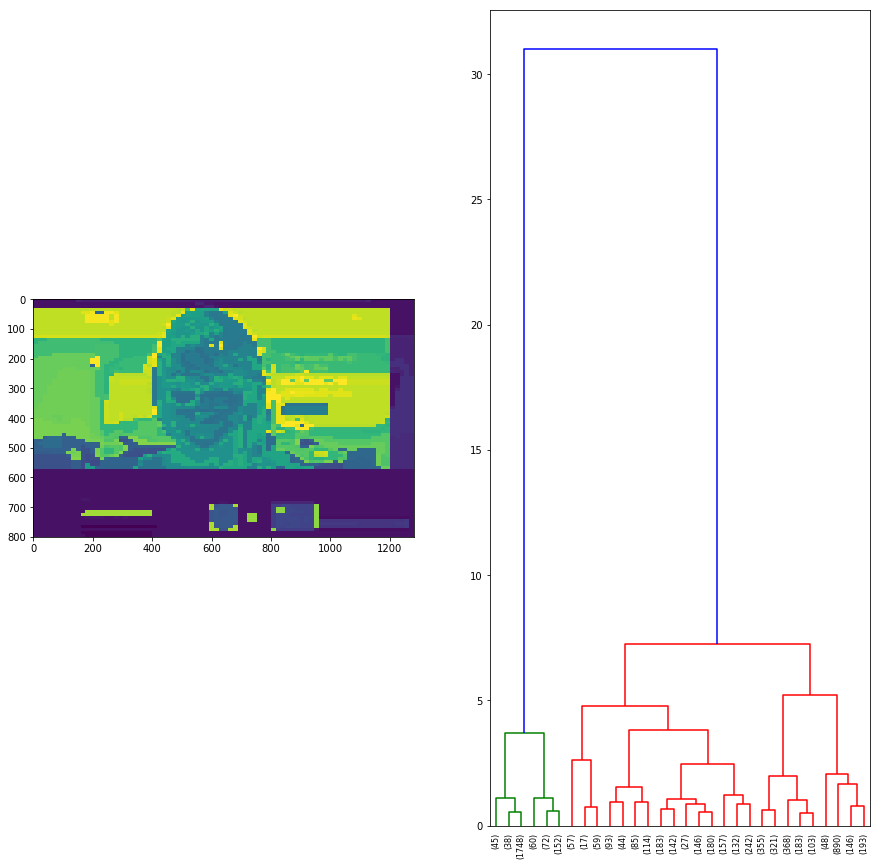

81 4.721040171663783


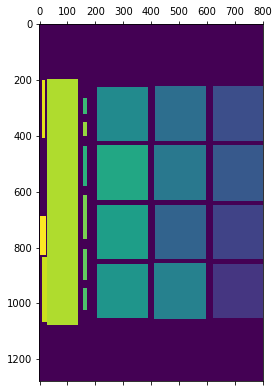

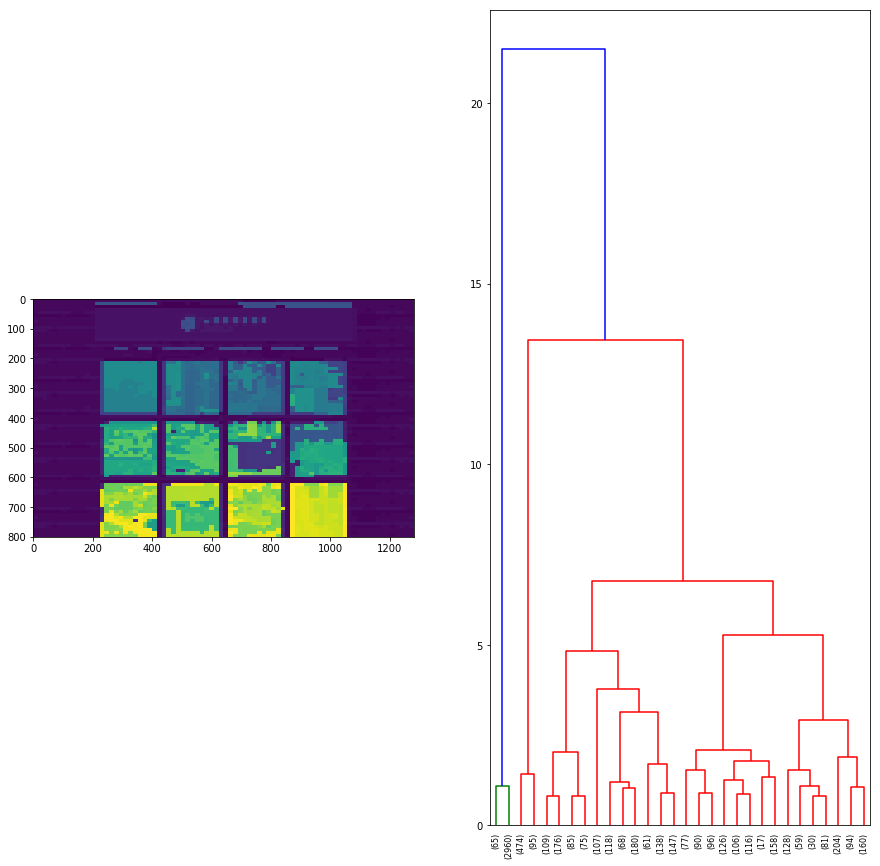

82 4.970159847122939


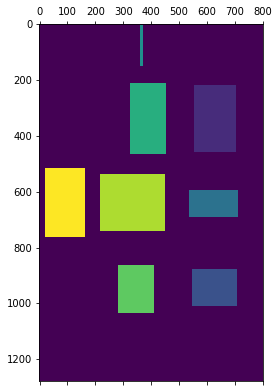

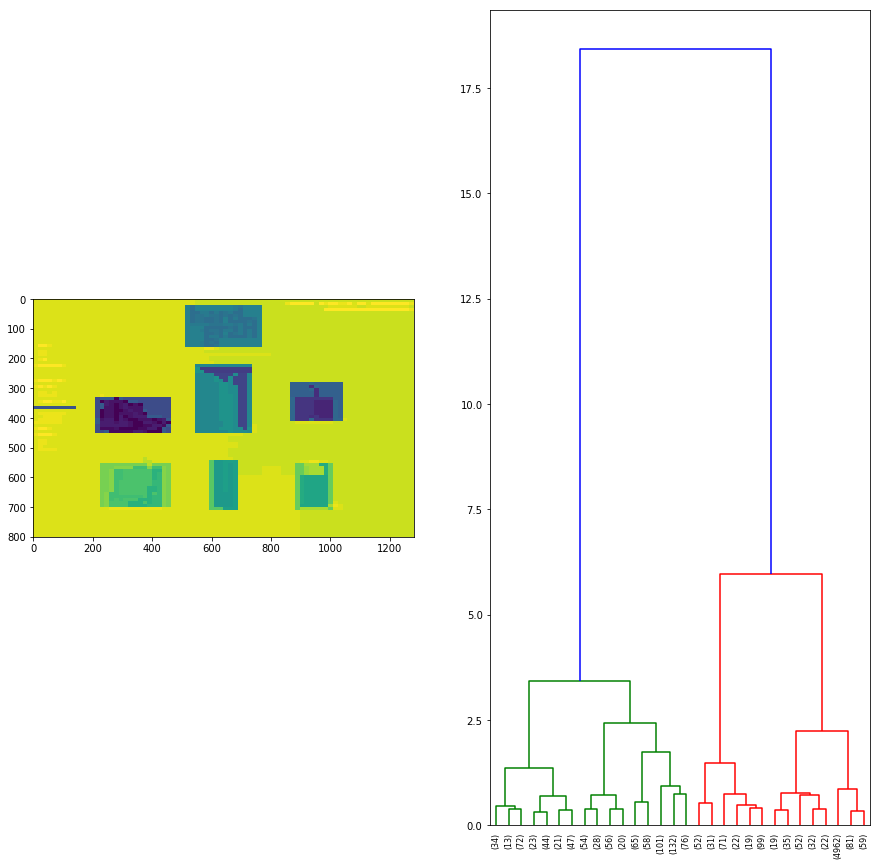

83 2.648649547513359


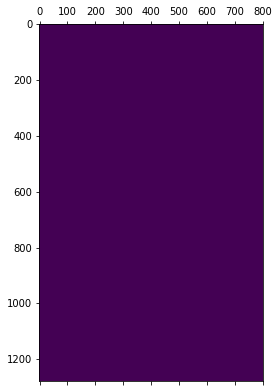

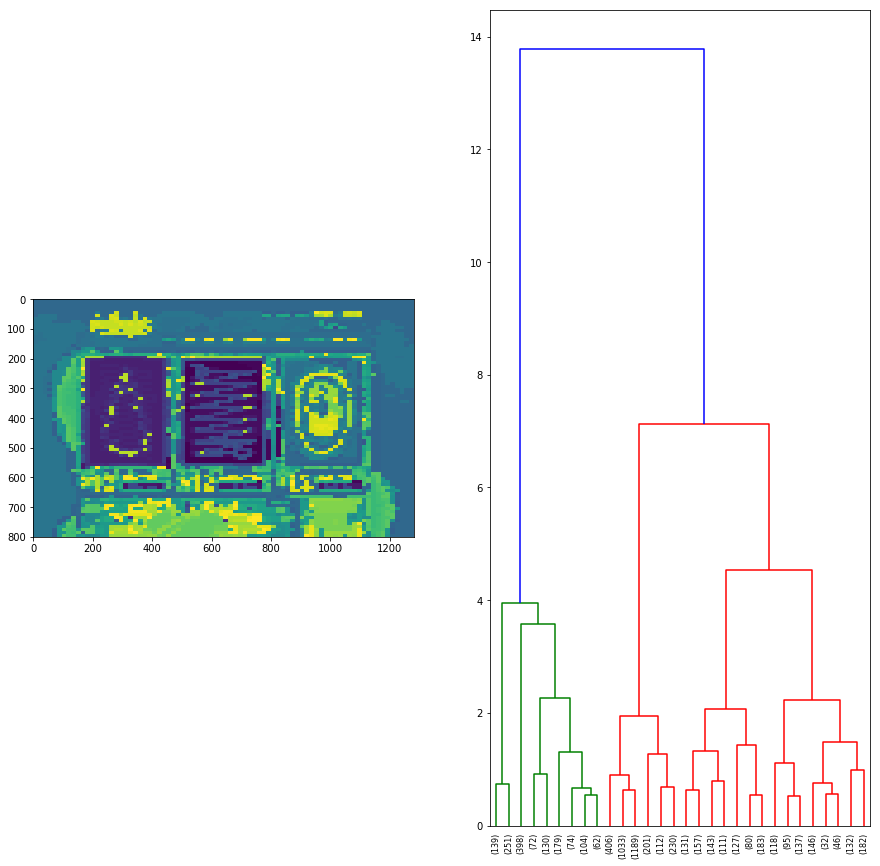

84 5.148730322023728


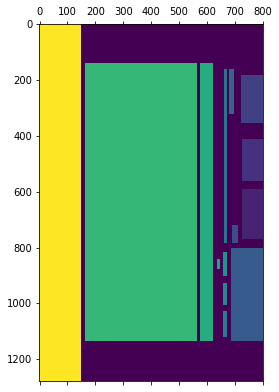

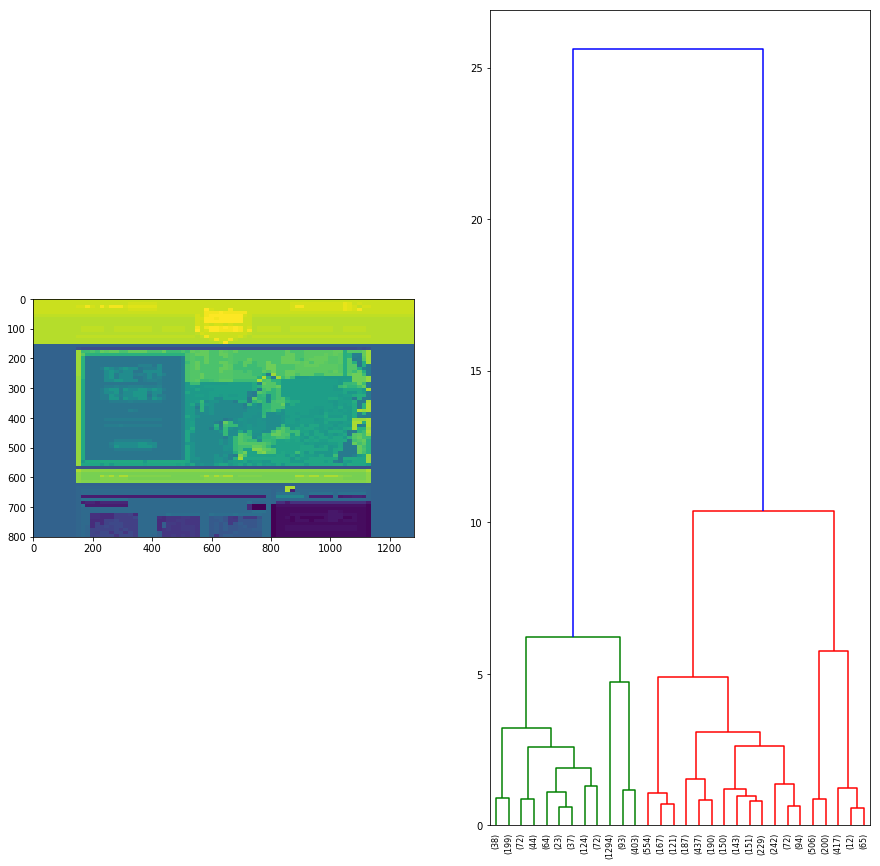

85 4.883034952622735


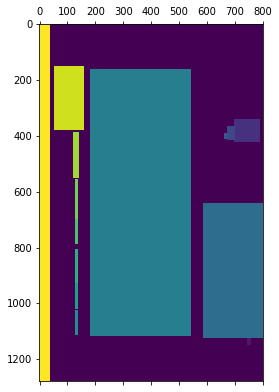

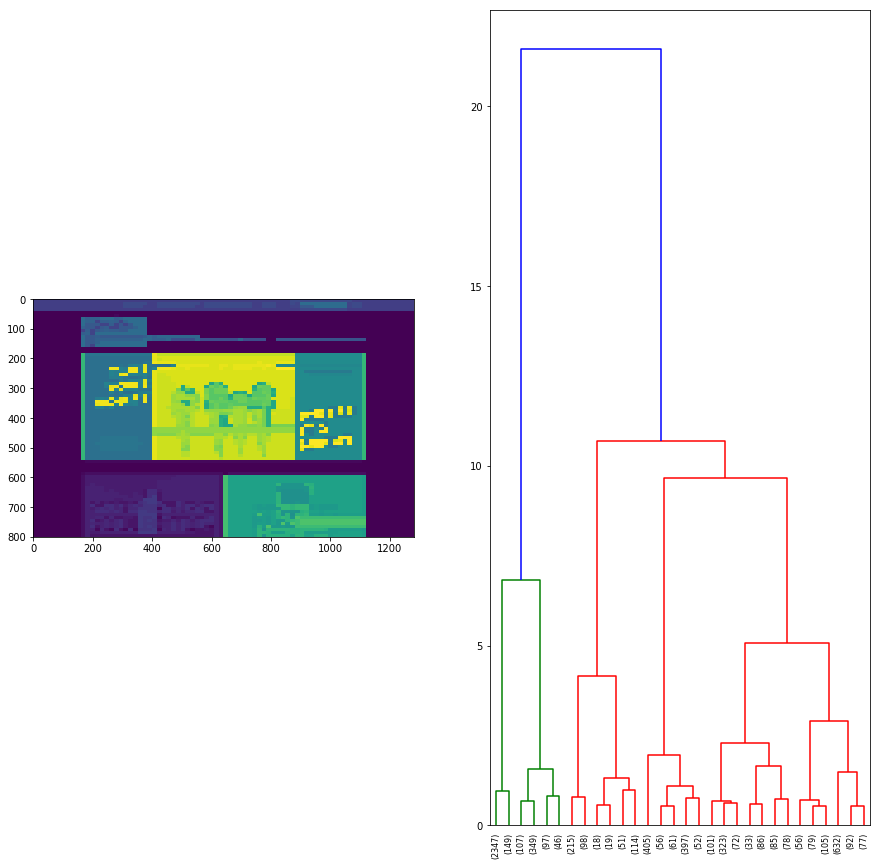

86 4.140376769450139


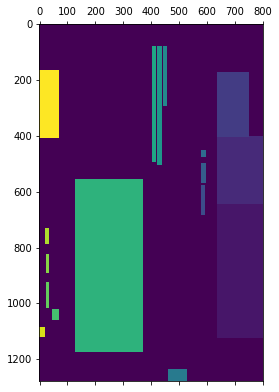

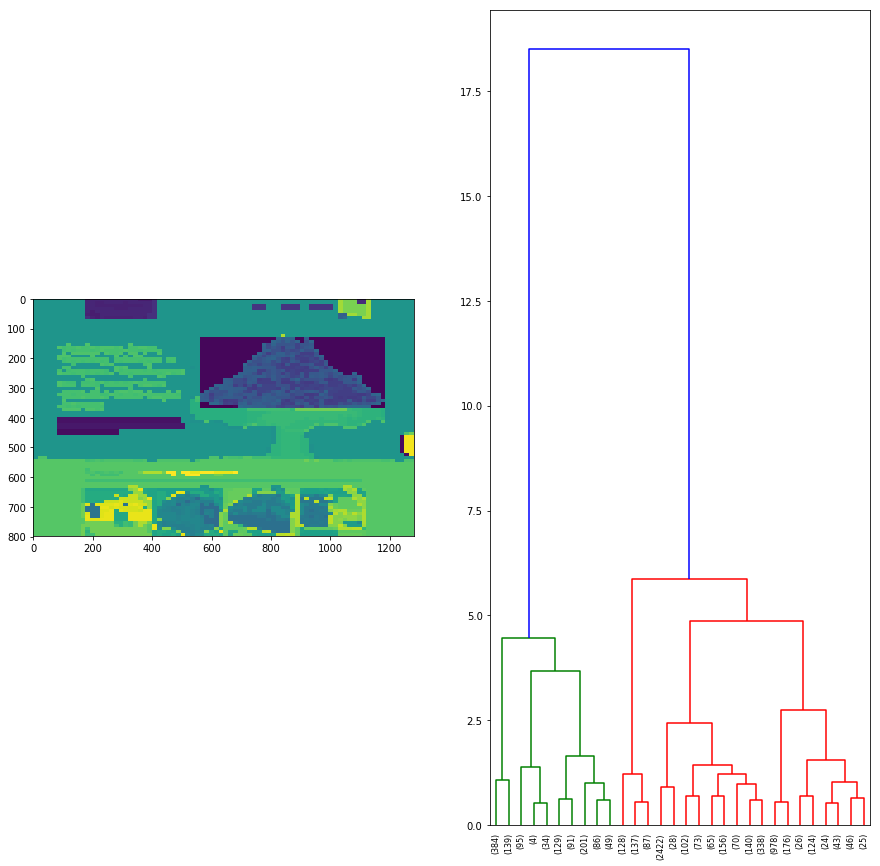

87 4.039258984469799


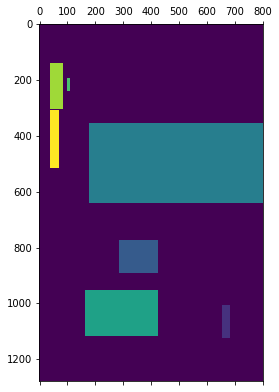

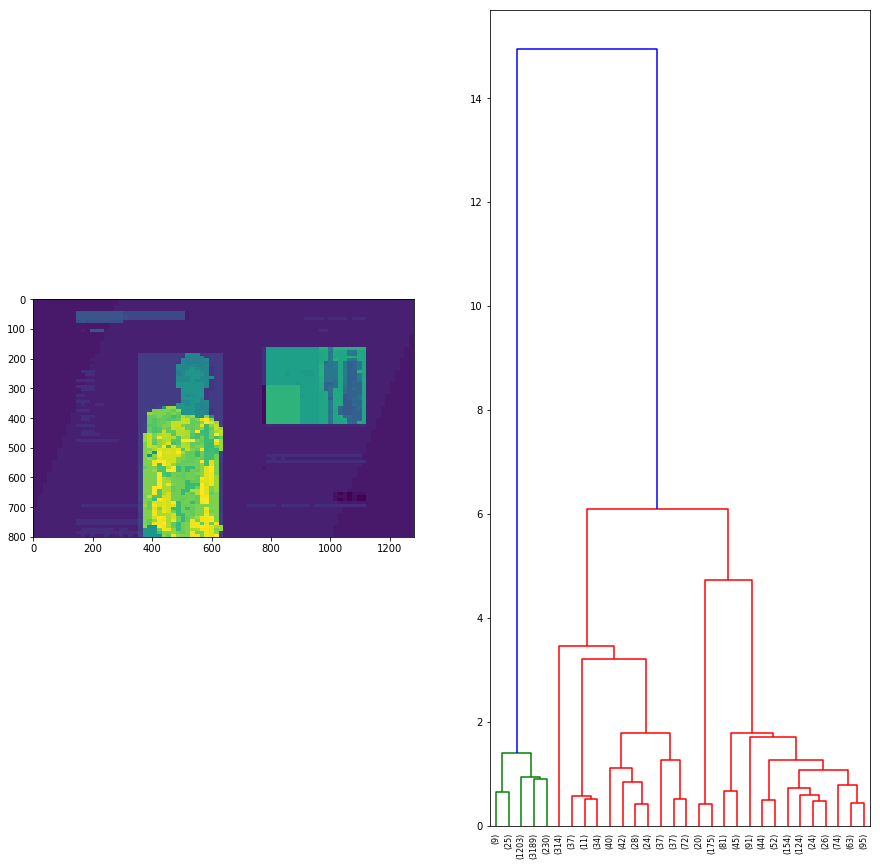

88 2.9918032523524745


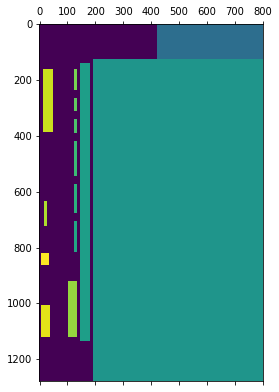

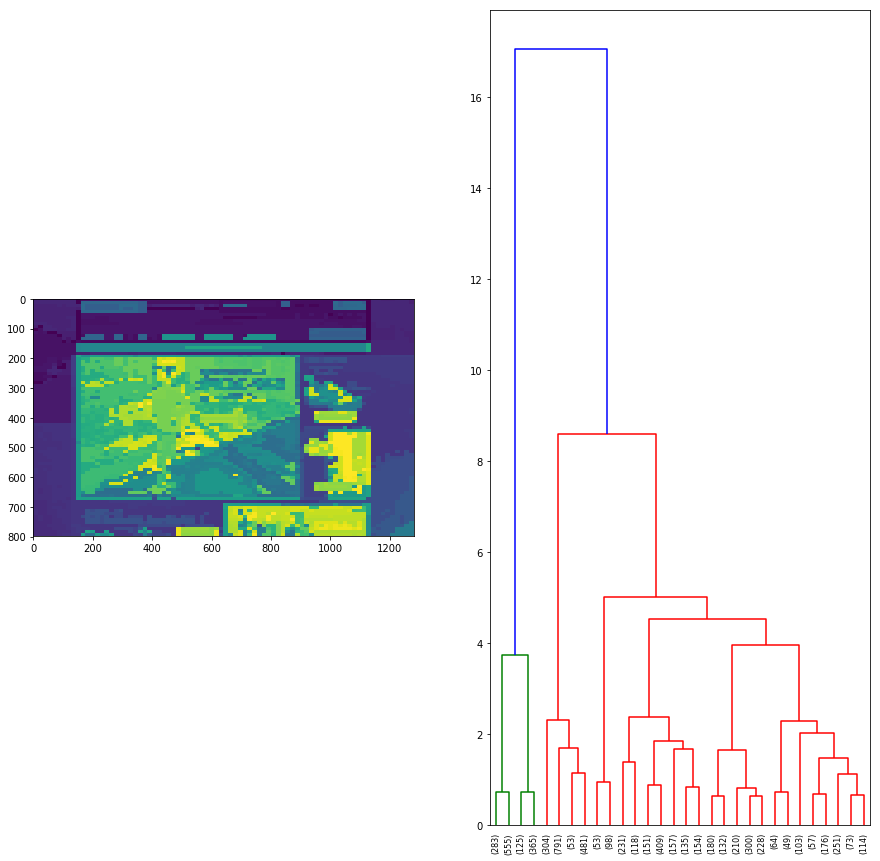

89 5.889910039965671


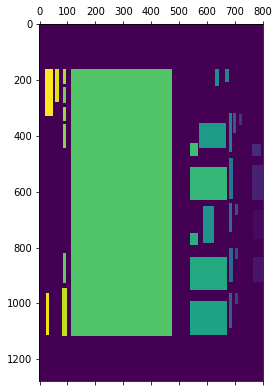

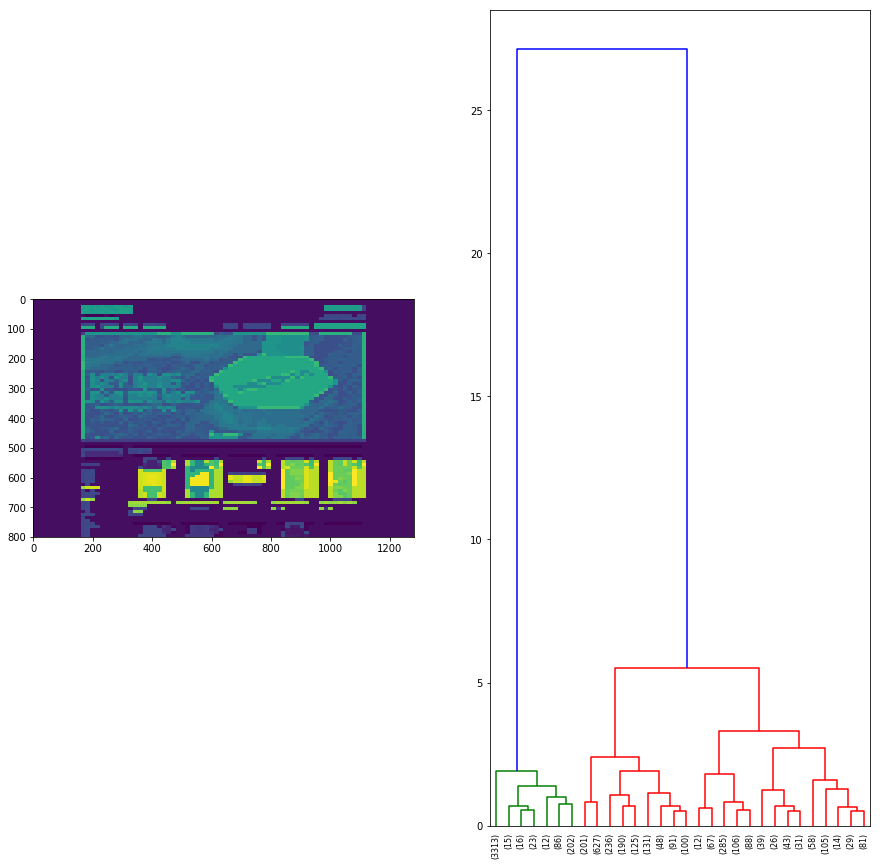

90 3.6338309071756396


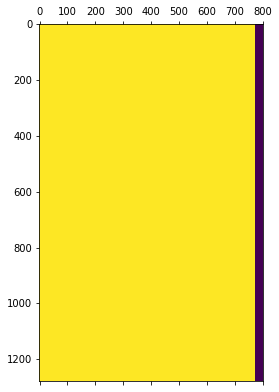

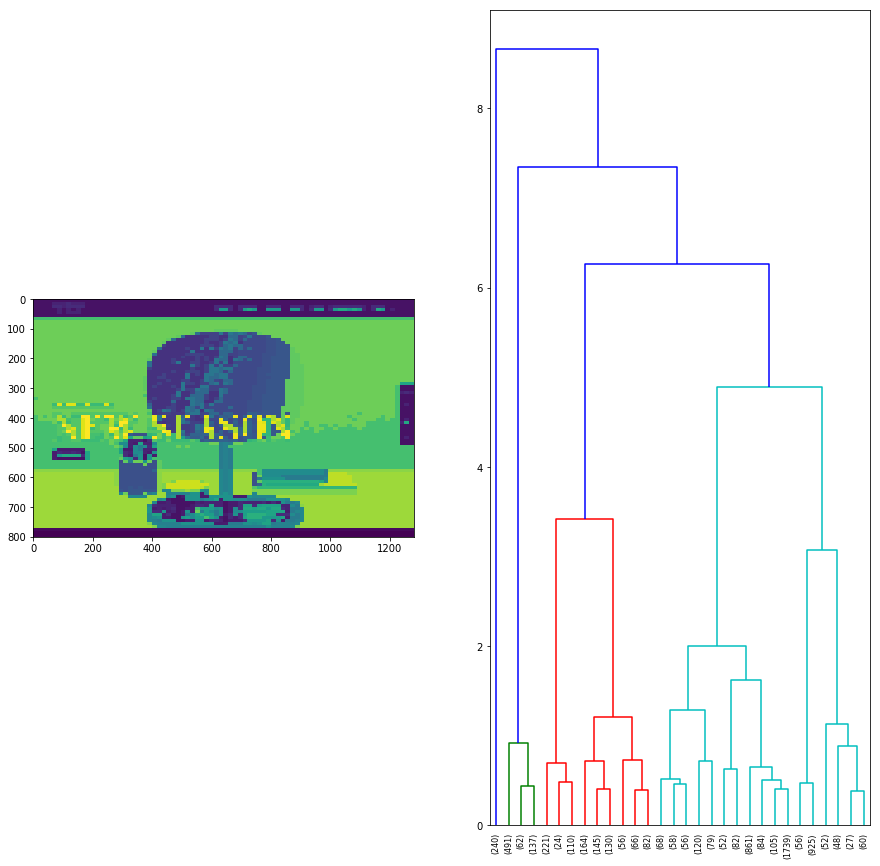

91 3.9876599915062587


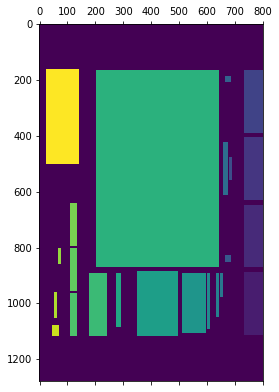

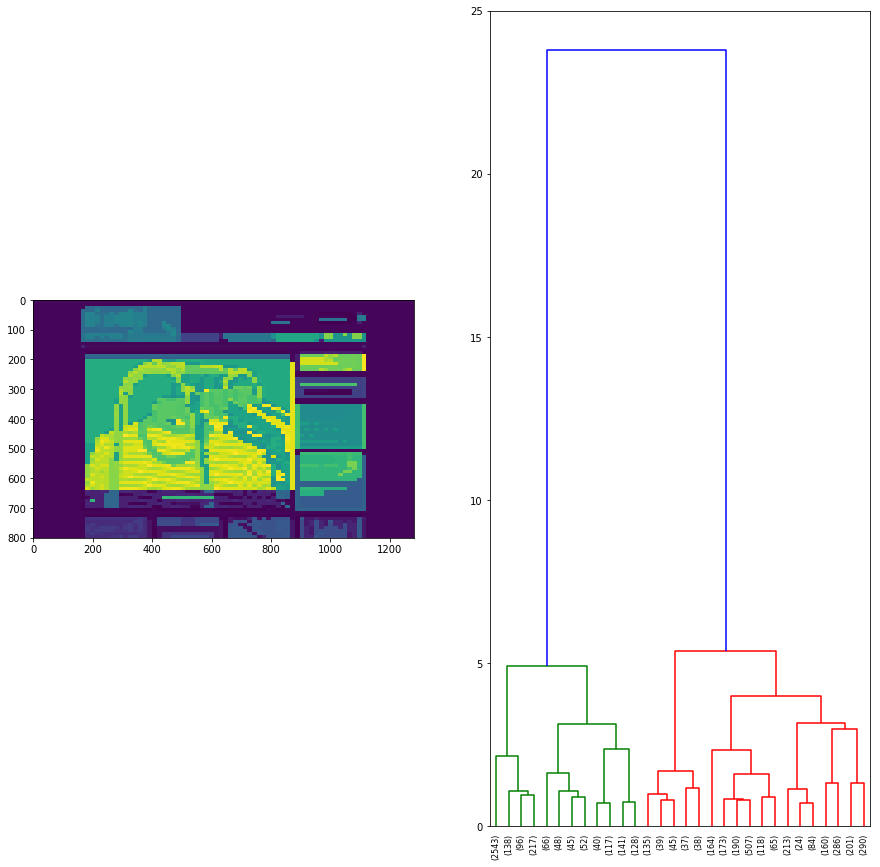

92 4.646559812177476


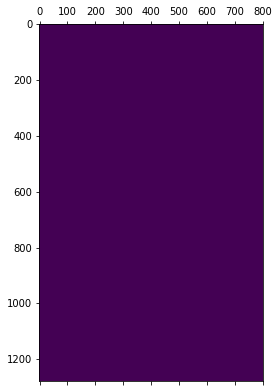

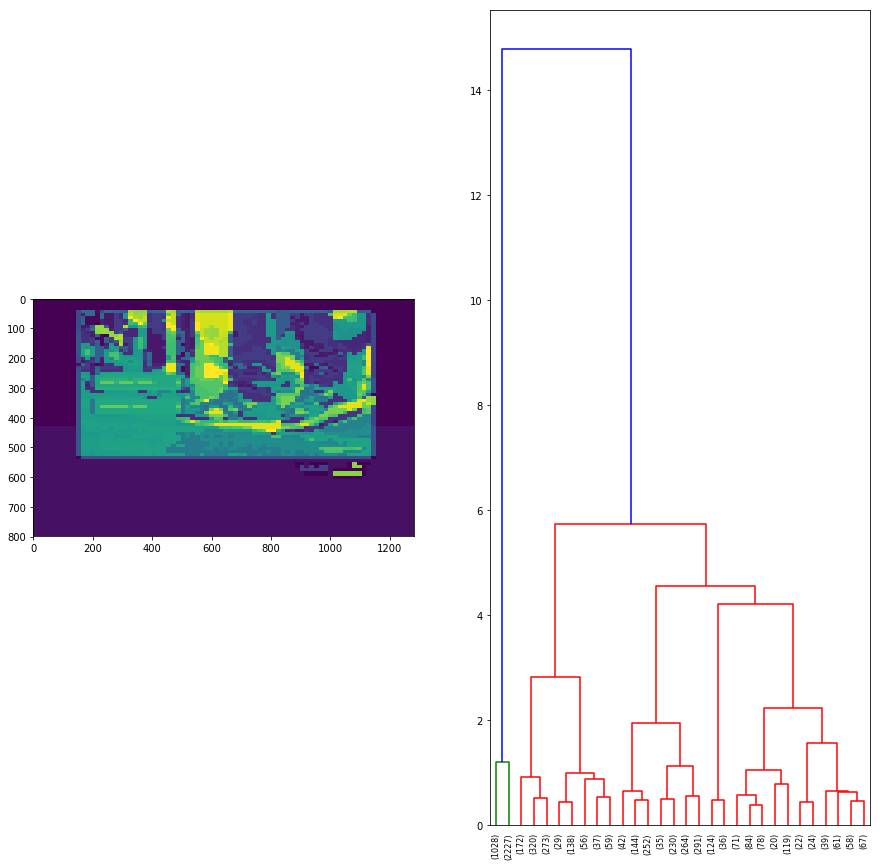

93 3.855906927878965


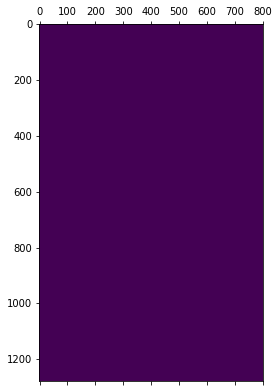

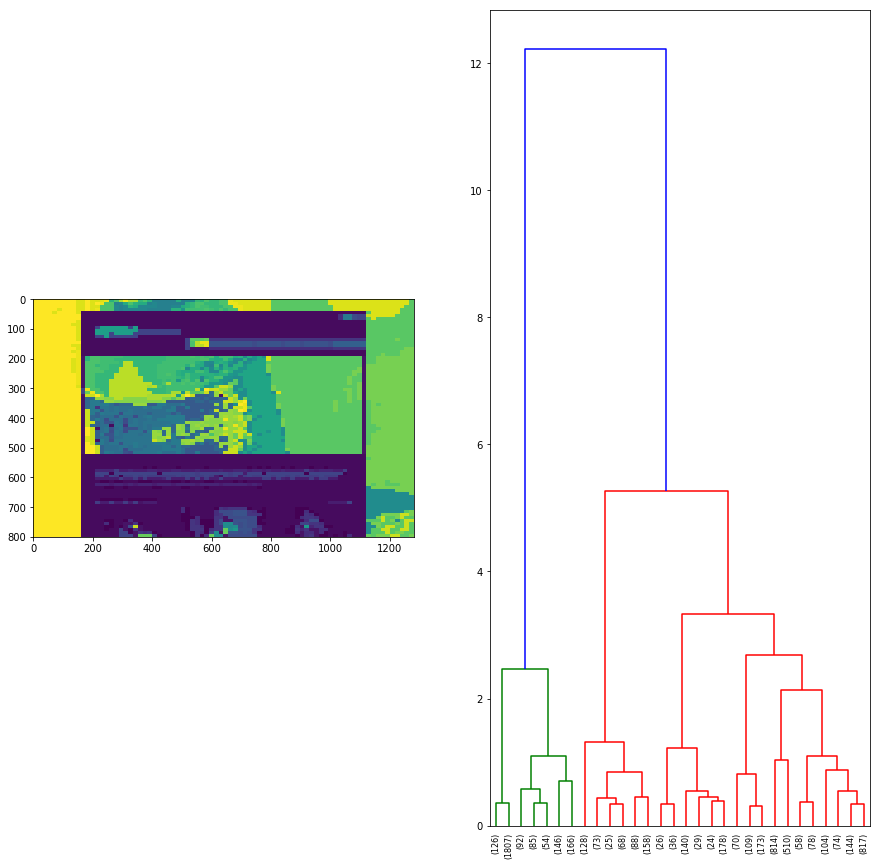

94 4.01252199195525


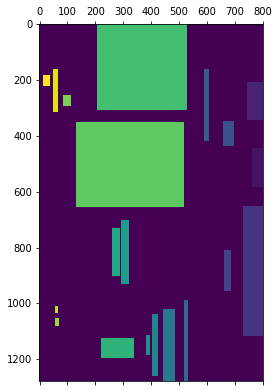

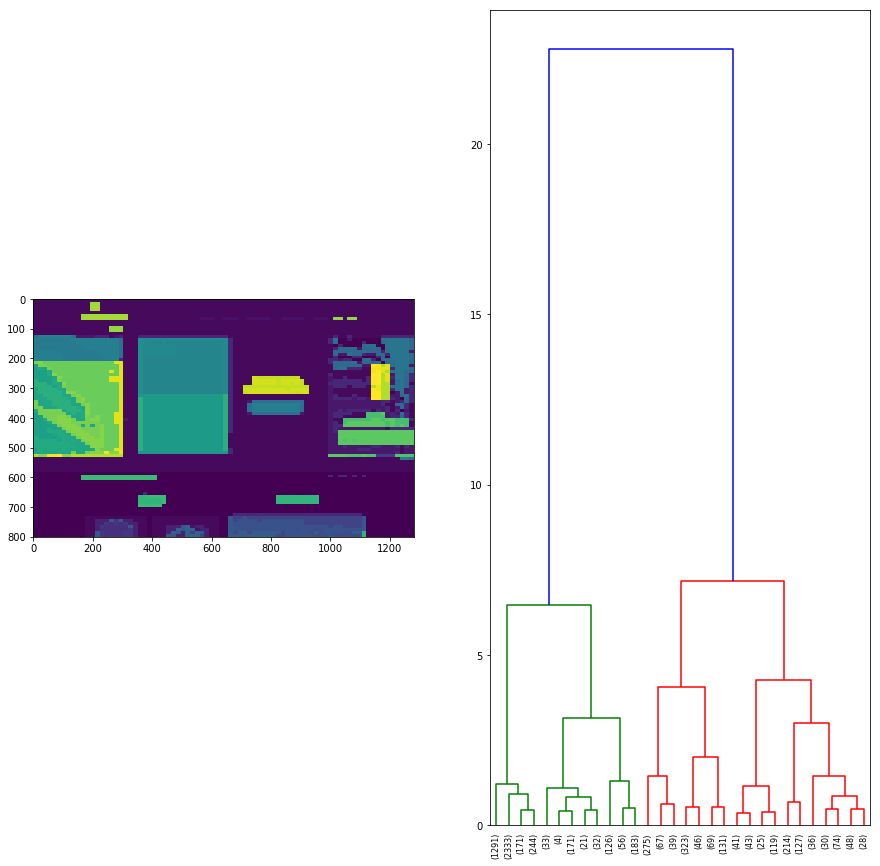

95 3.59960803165173


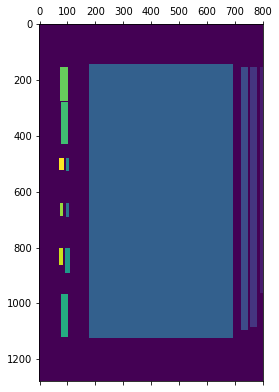

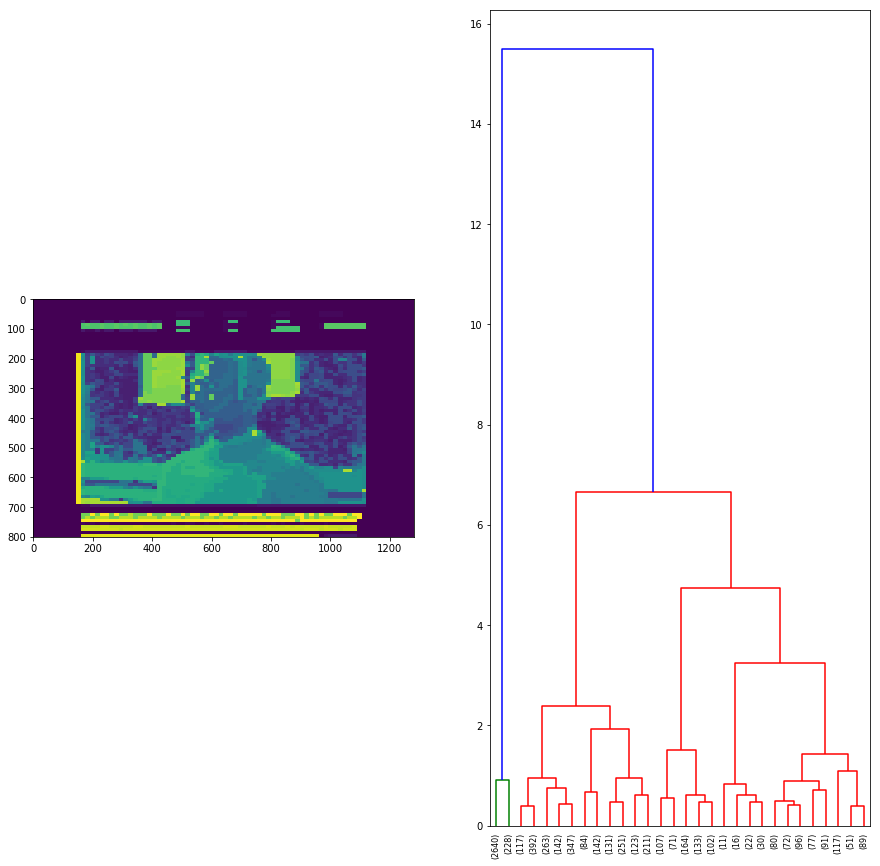

96 4.081913430275001


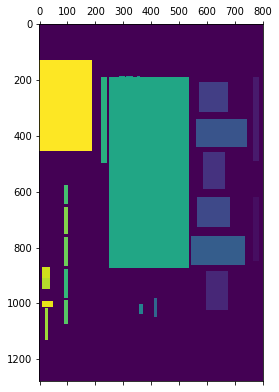

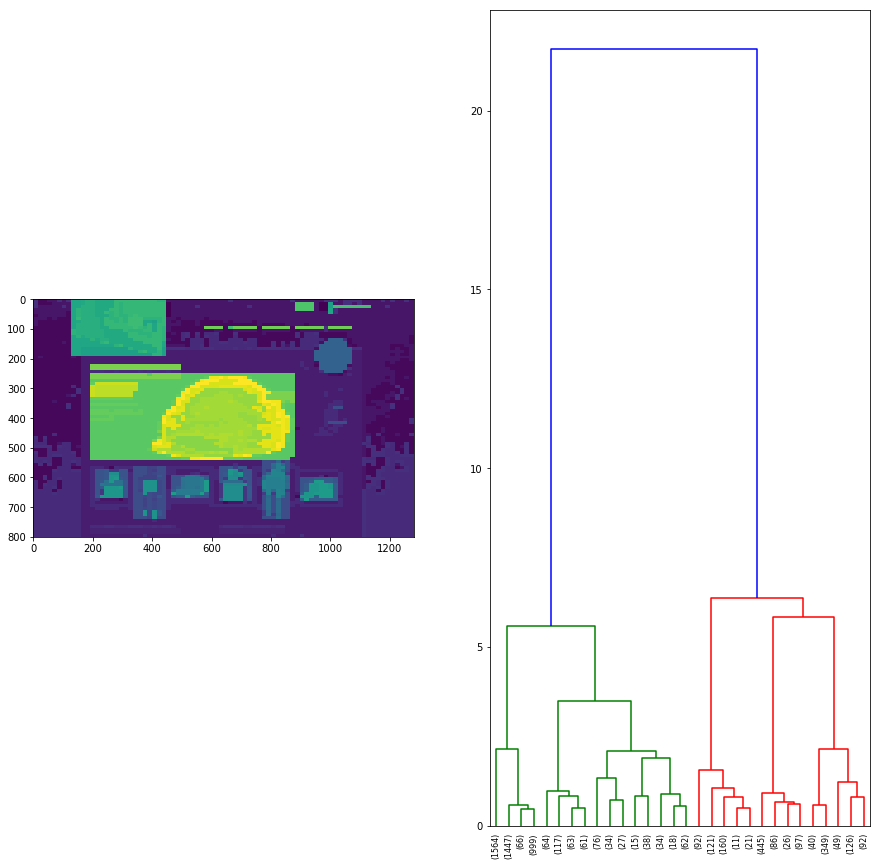

97 4.110430624749356


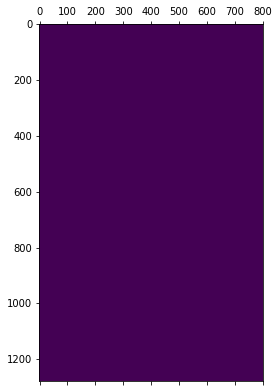

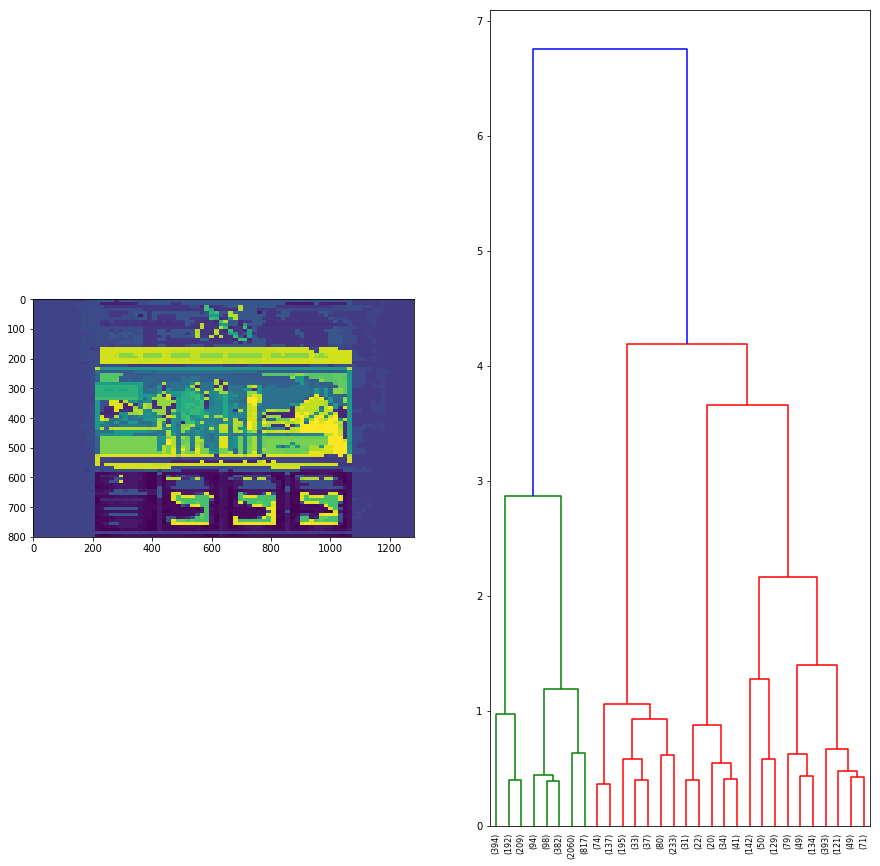

98 4.55533315069786


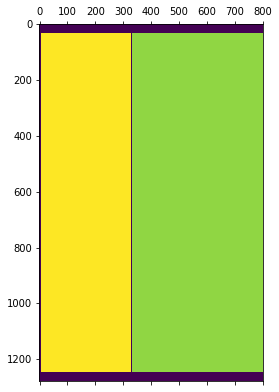

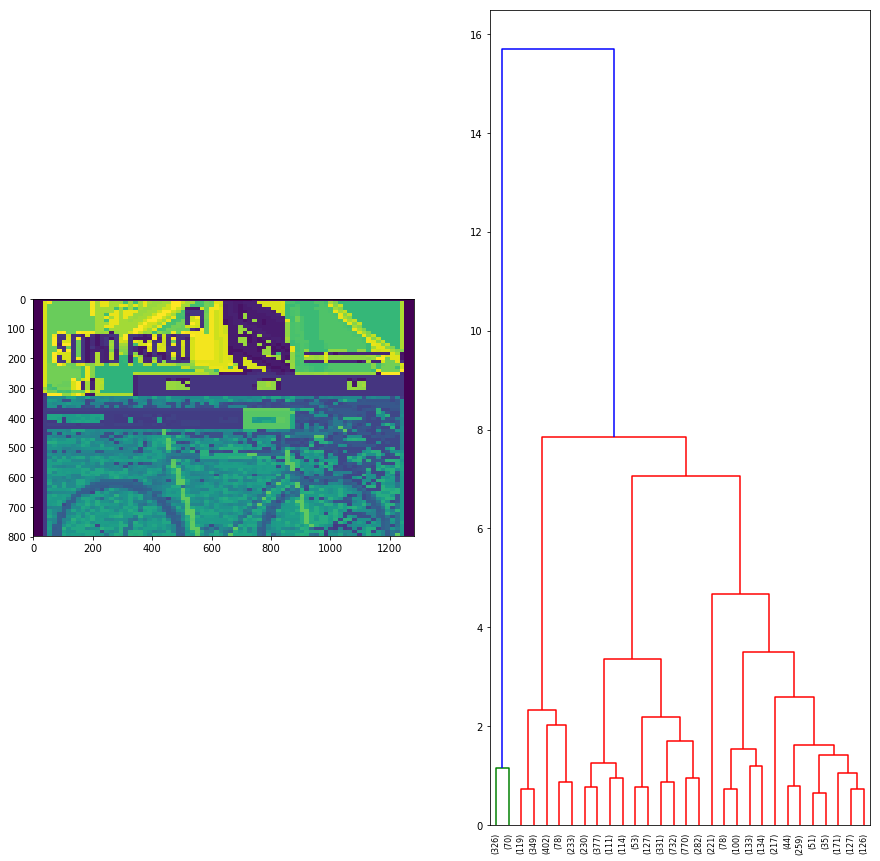

99 5.654021506768438


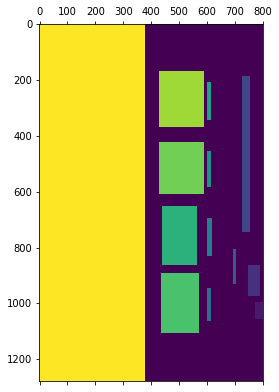

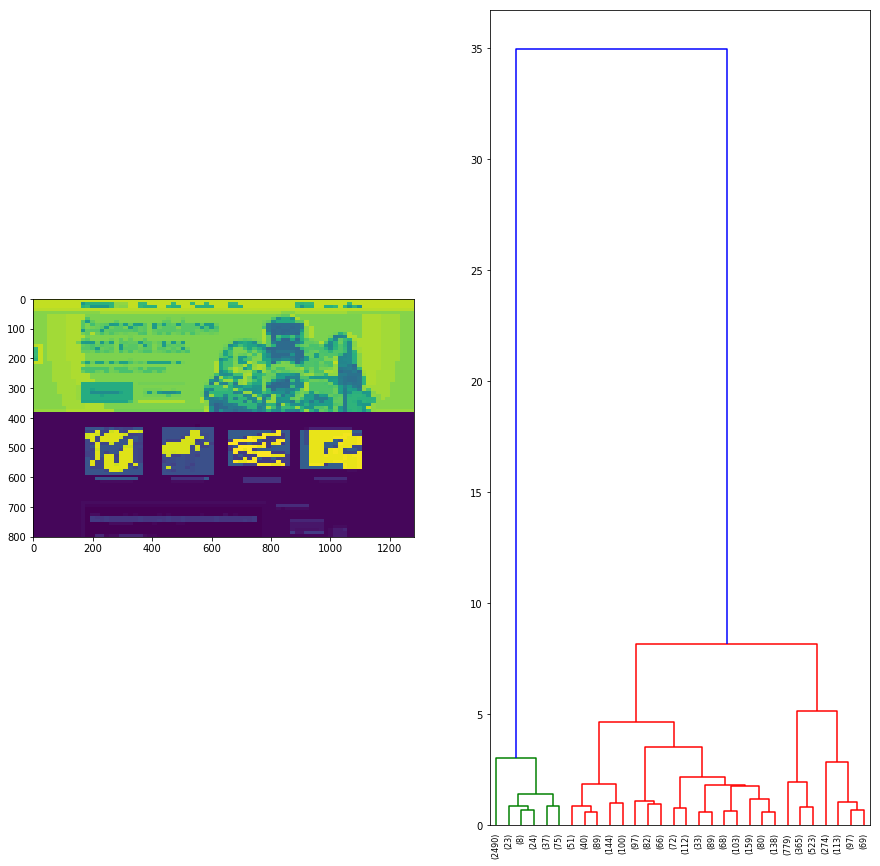

100 4.361028985755473


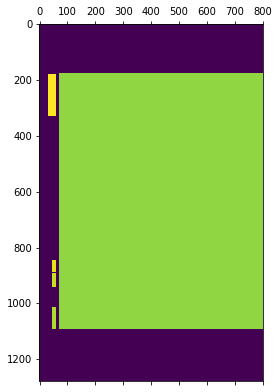

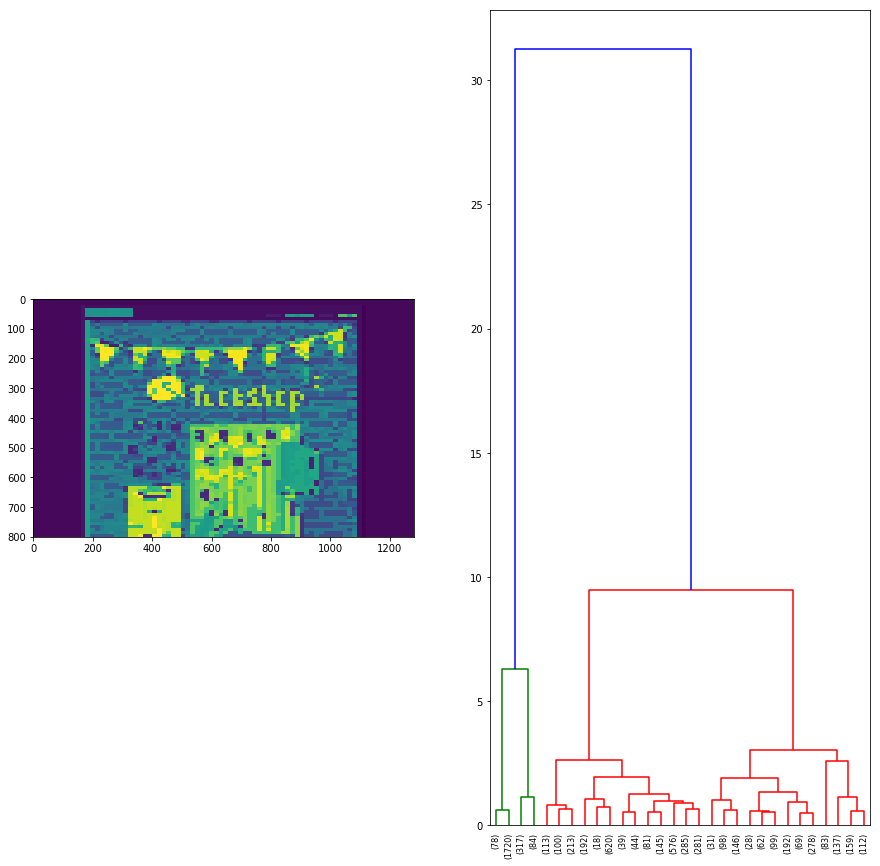

101 4.678598620905298


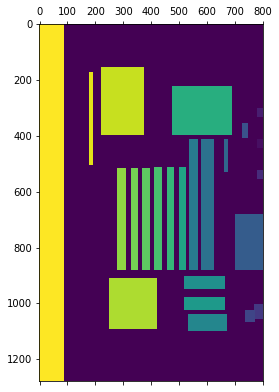

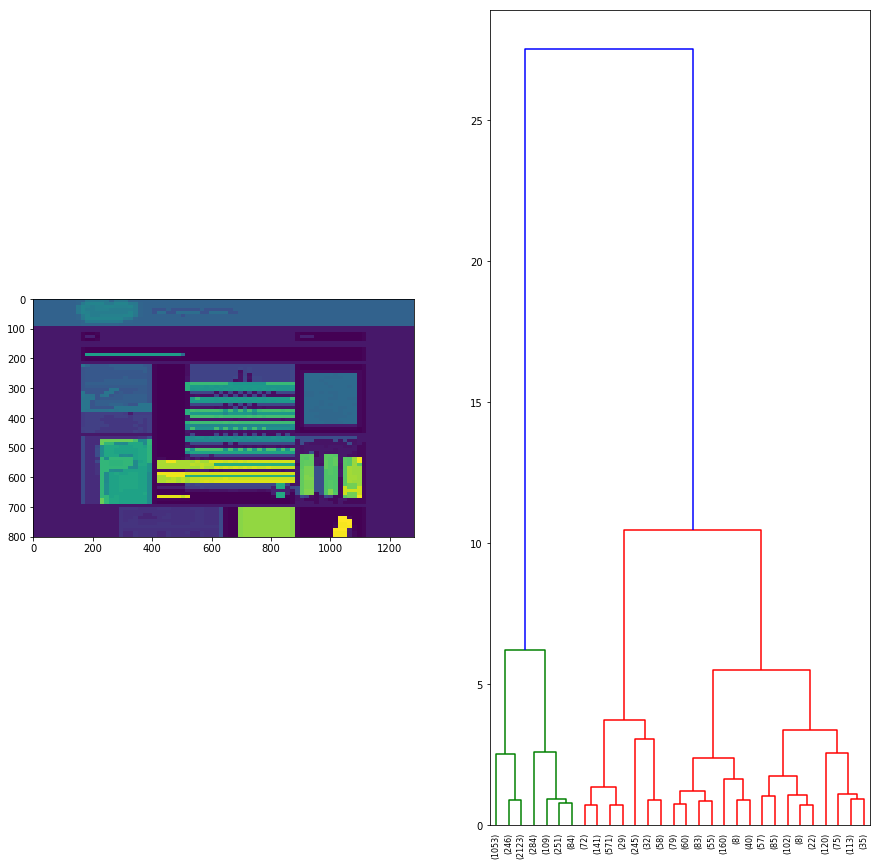

102 4.406842738784689


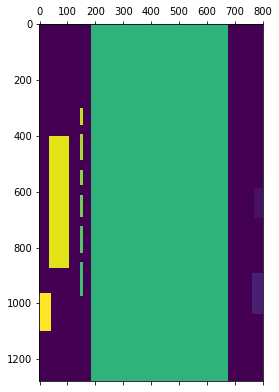

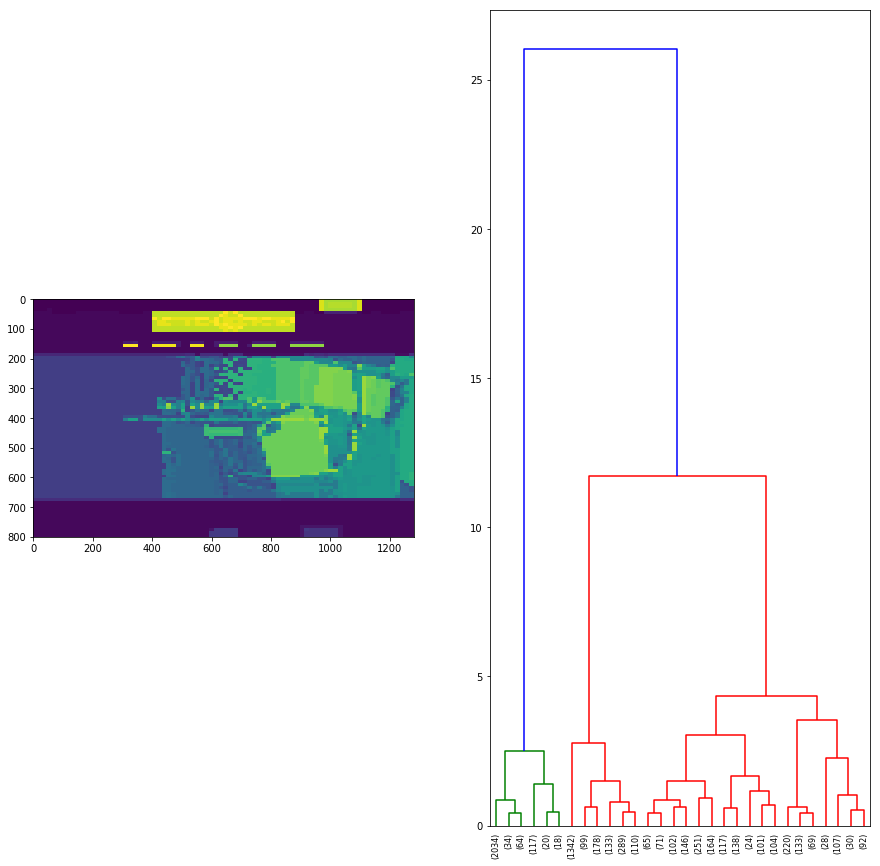

103 4.178020619446043


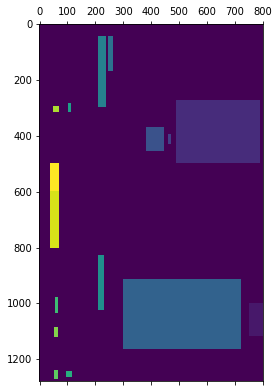

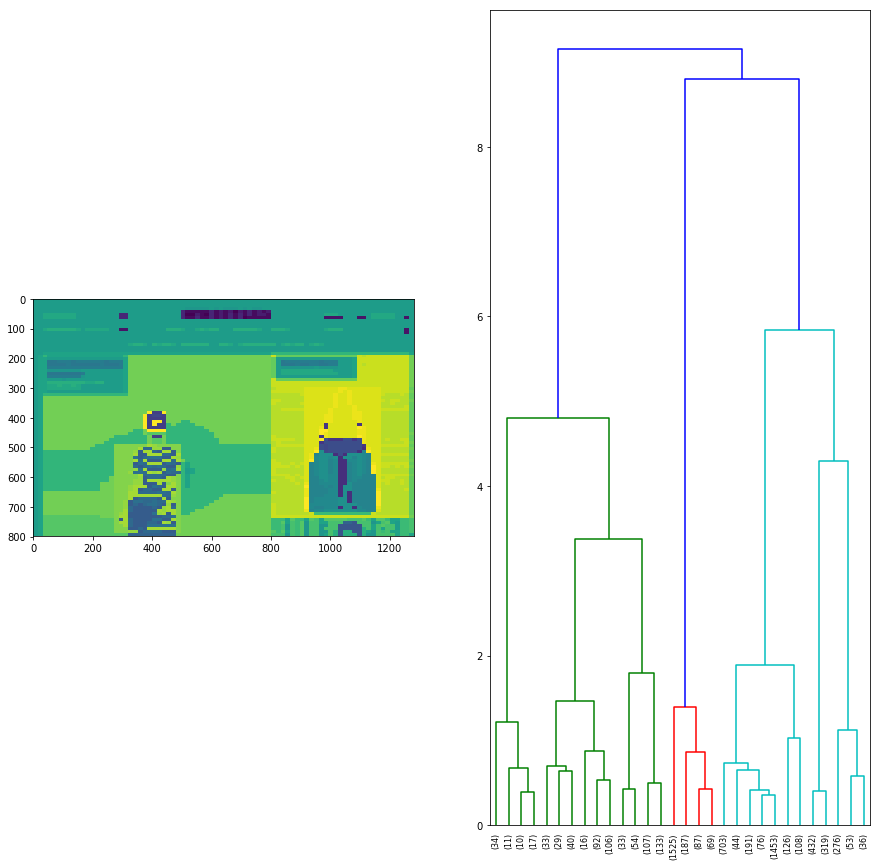

104 3.7704872889091594


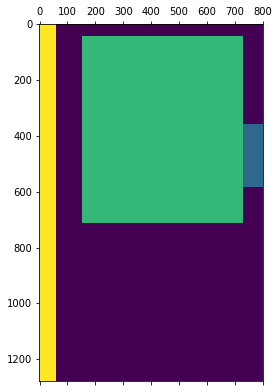

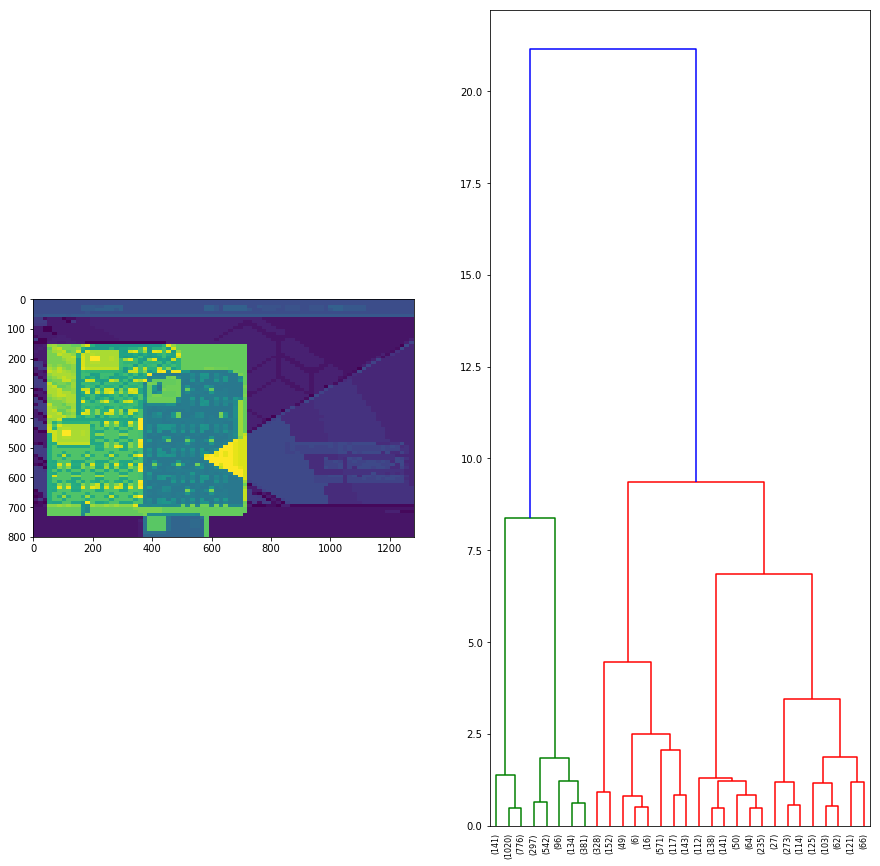

105 4.836847880777581


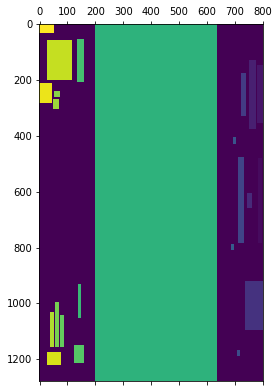

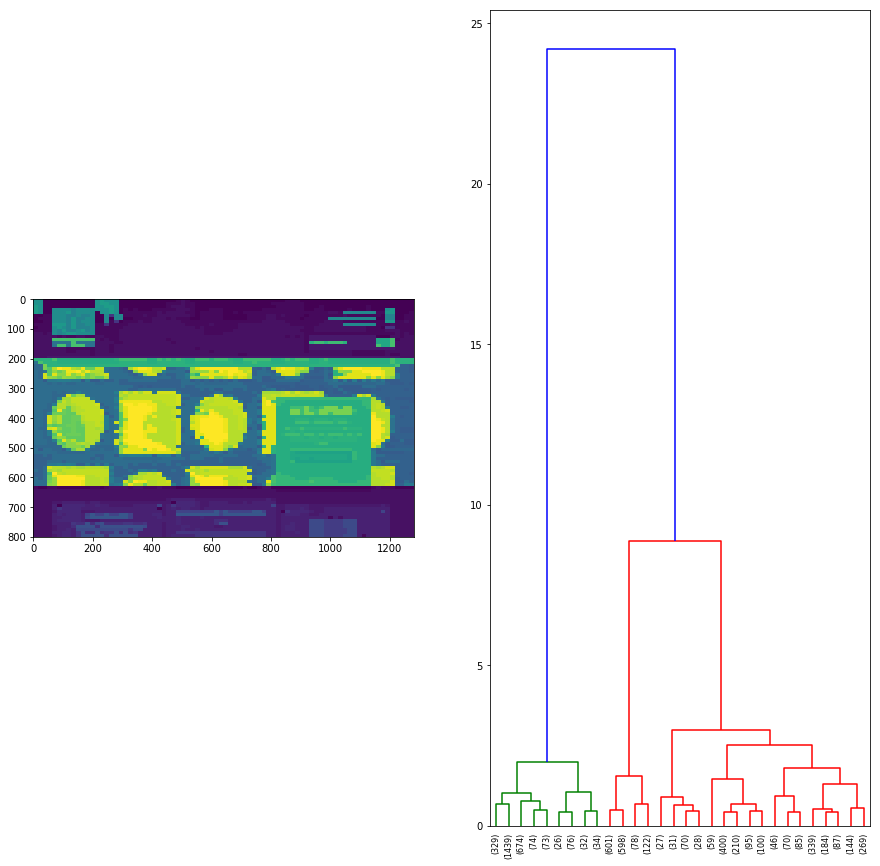

106 4.6387062863513595


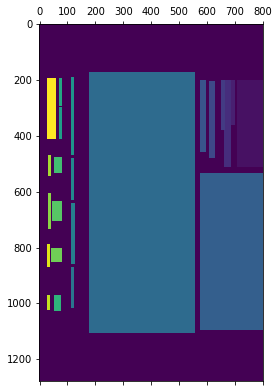

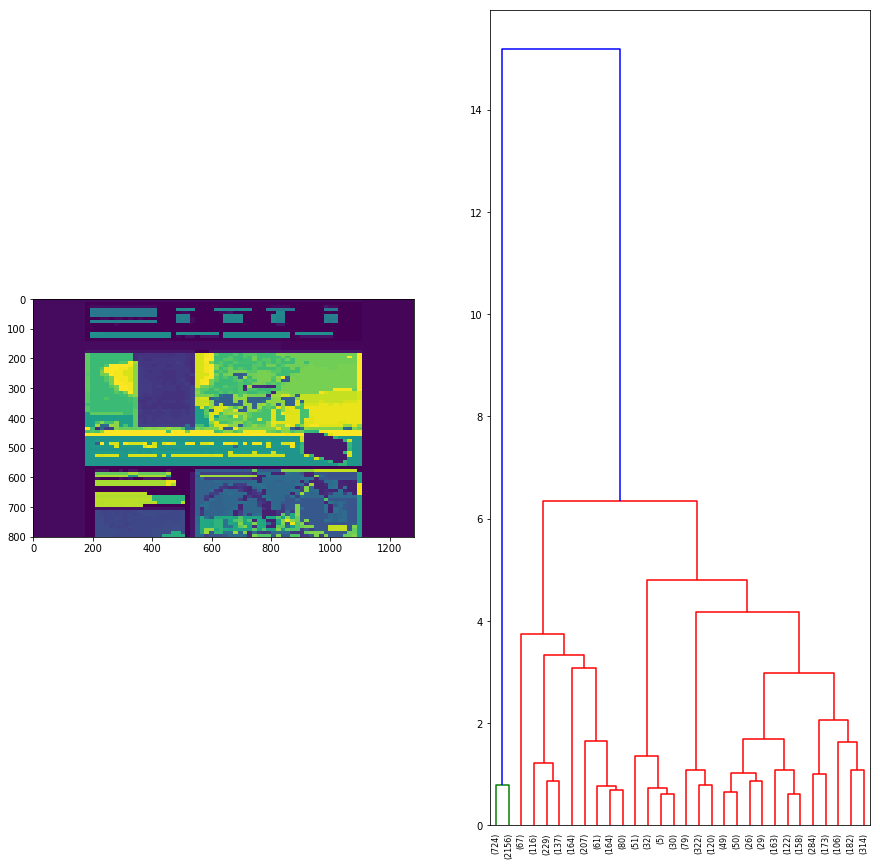

107 4.874179013431447


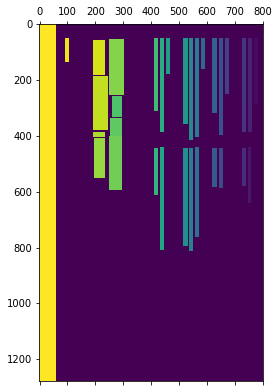

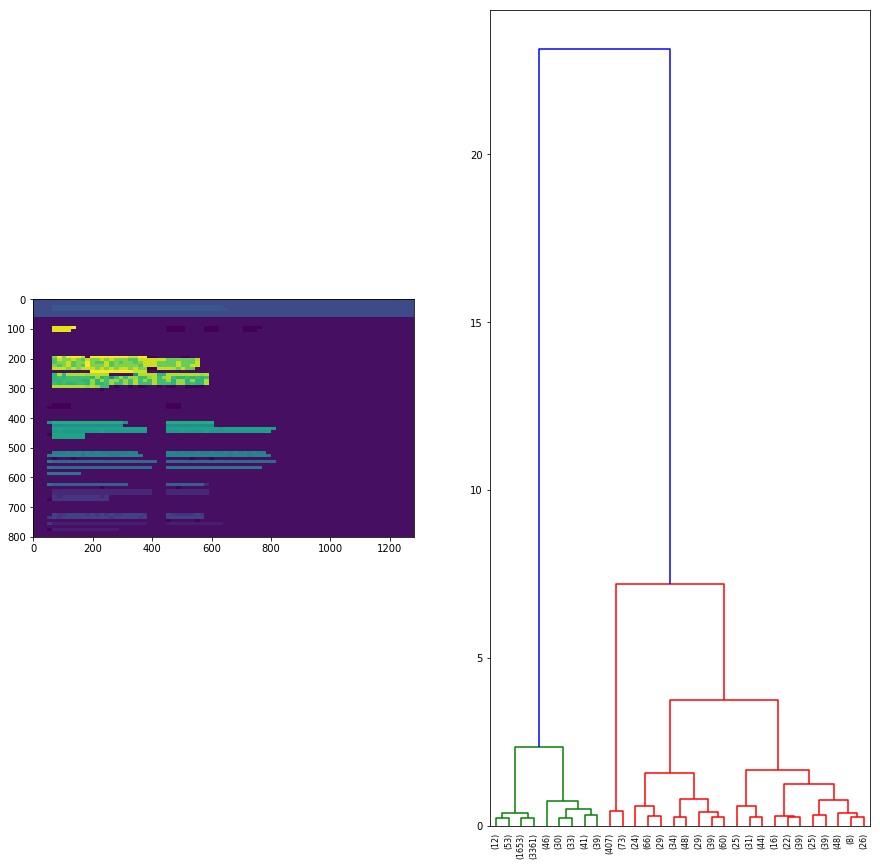

108 1.6336078145535529


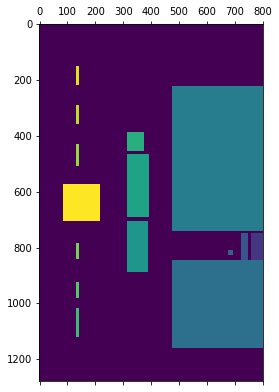

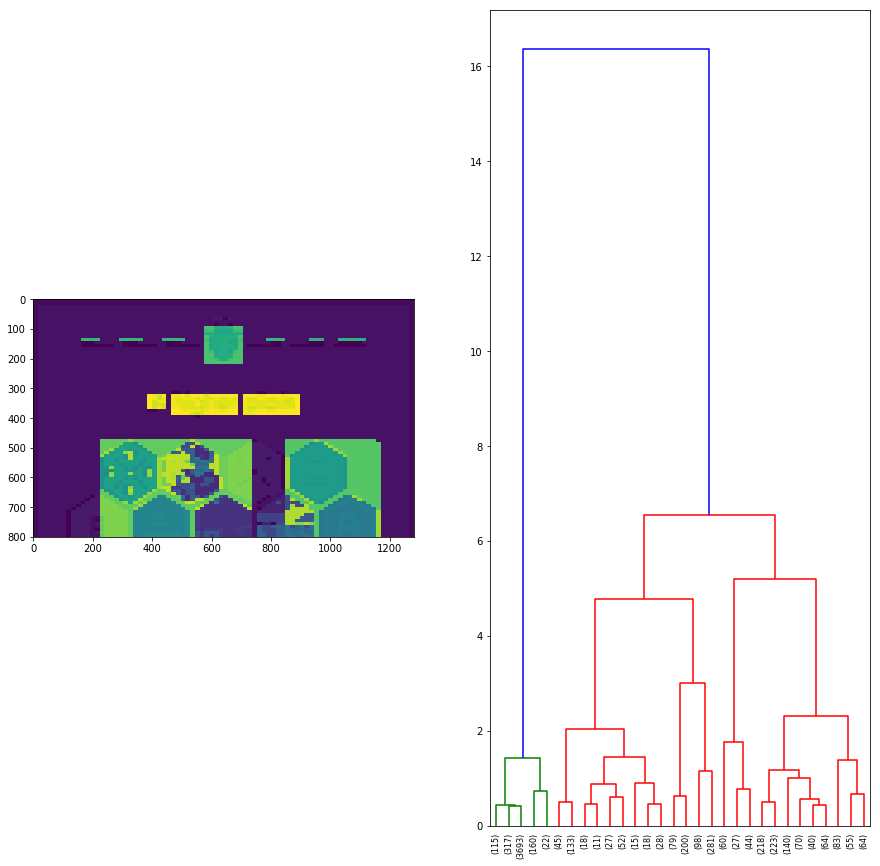

109 3.027844426260532


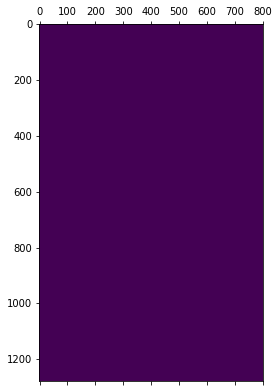

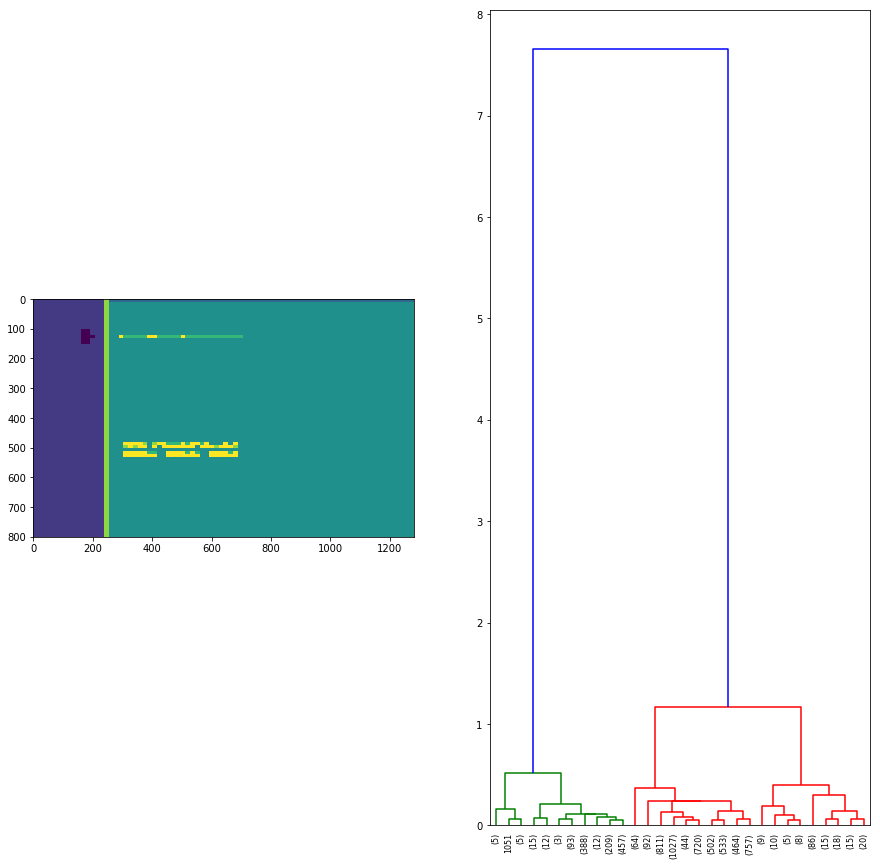

110 1.0113931350842482


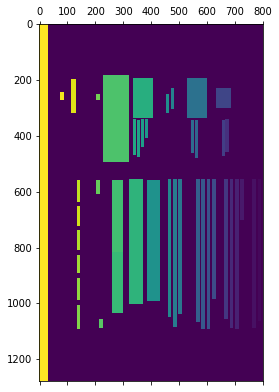

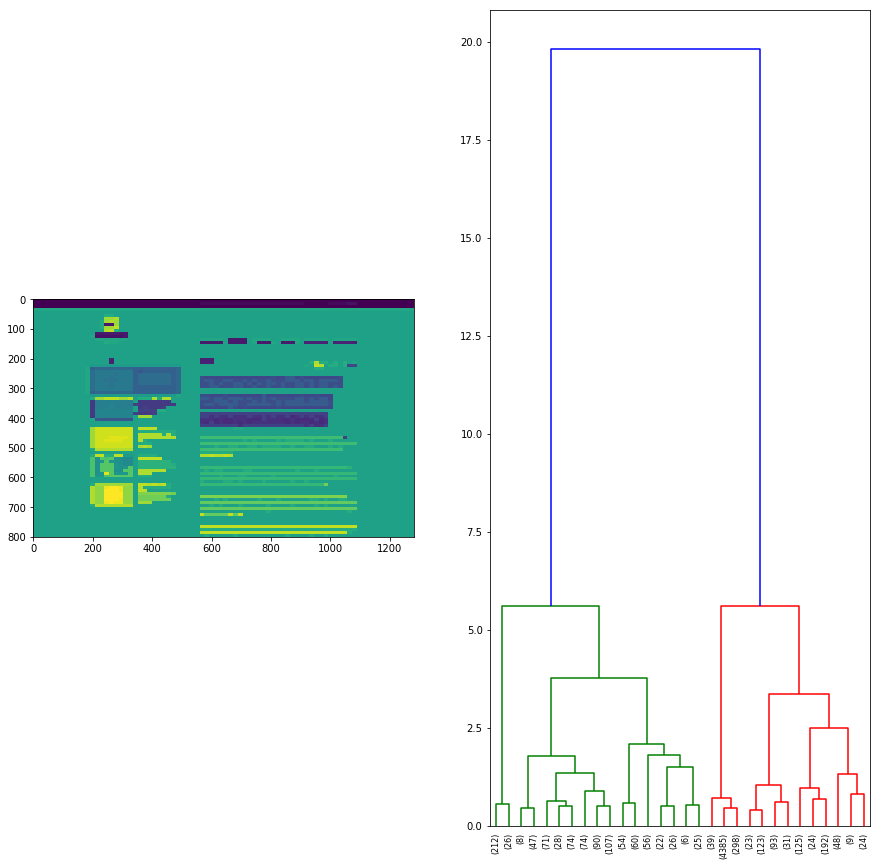

111 2.426177040971257


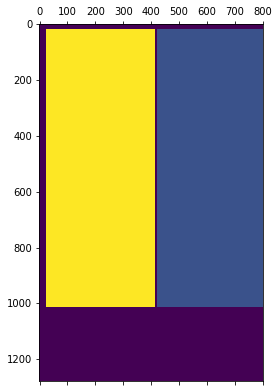

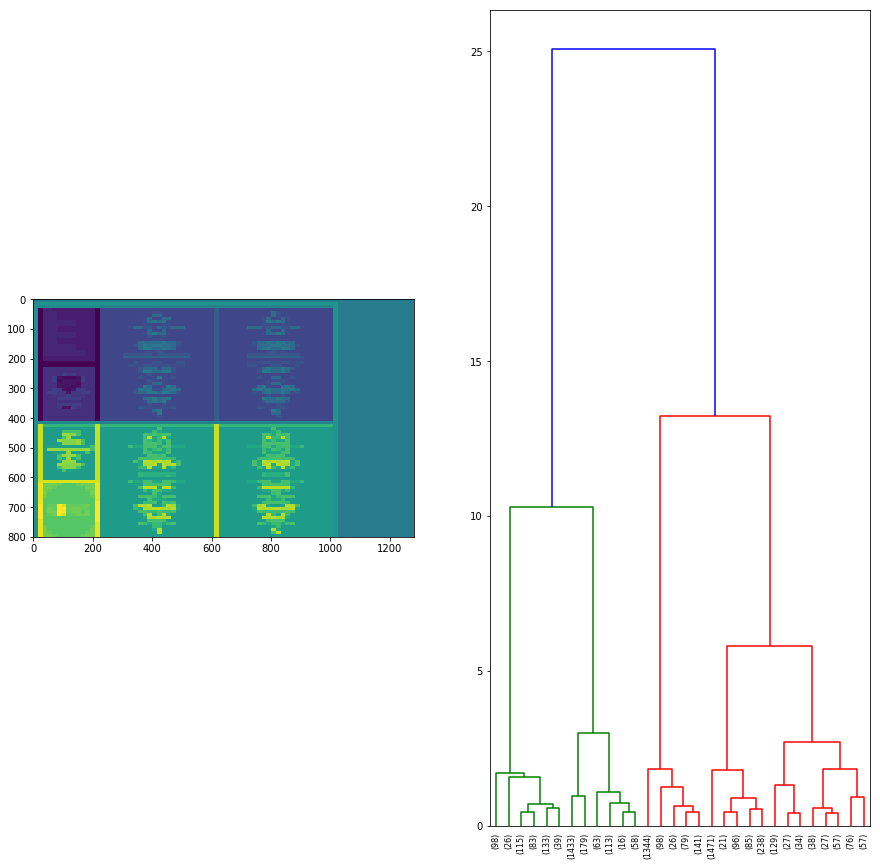

112 3.585551554173448


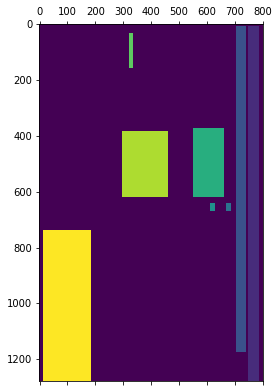

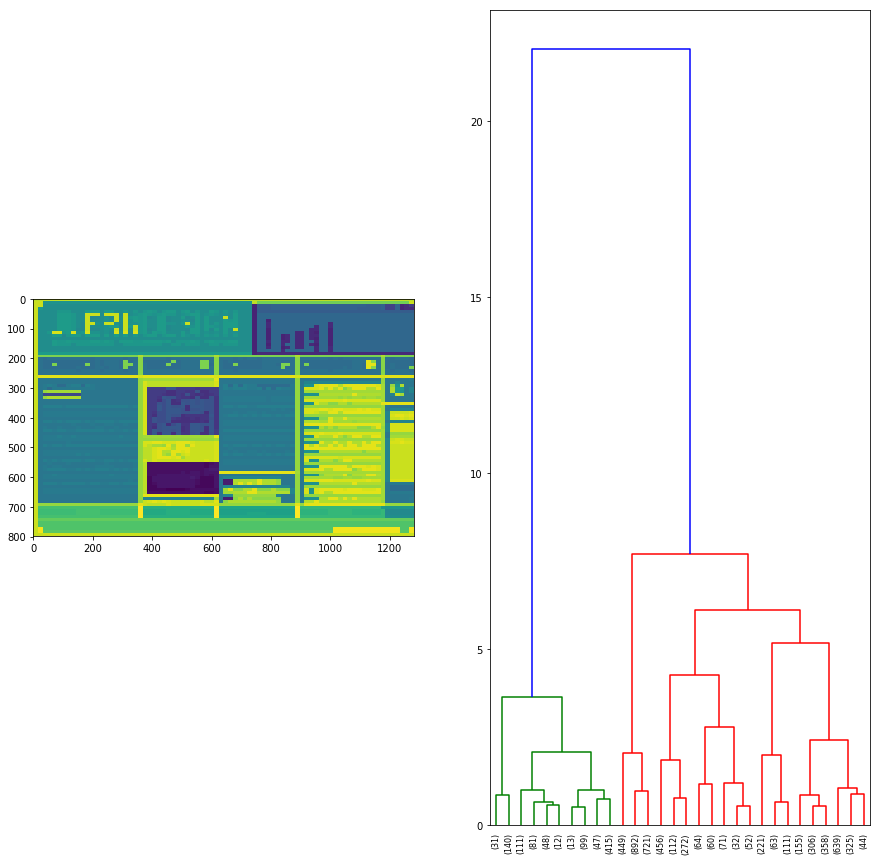

113 4.890990448850185


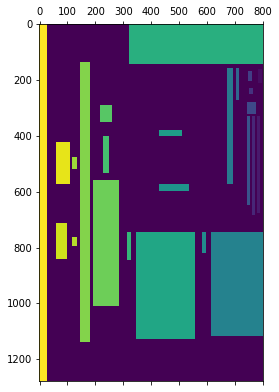

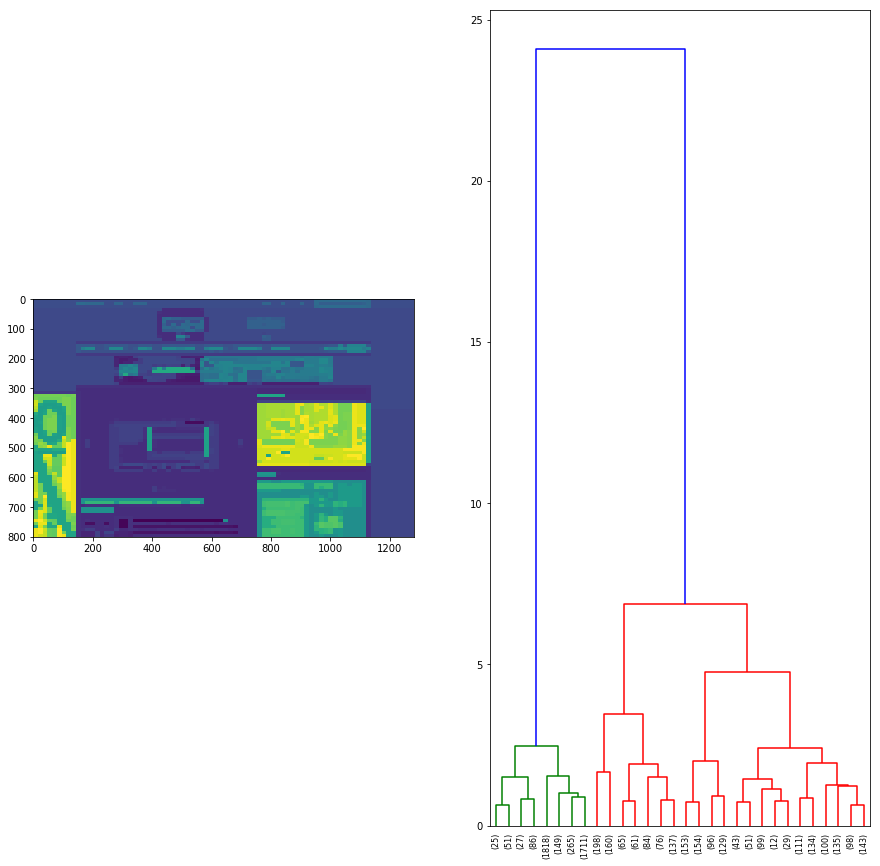

114 4.52369023327661


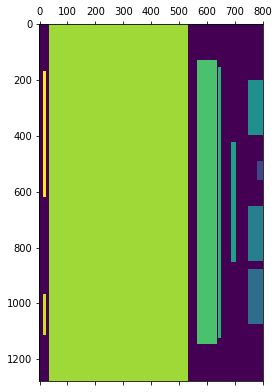

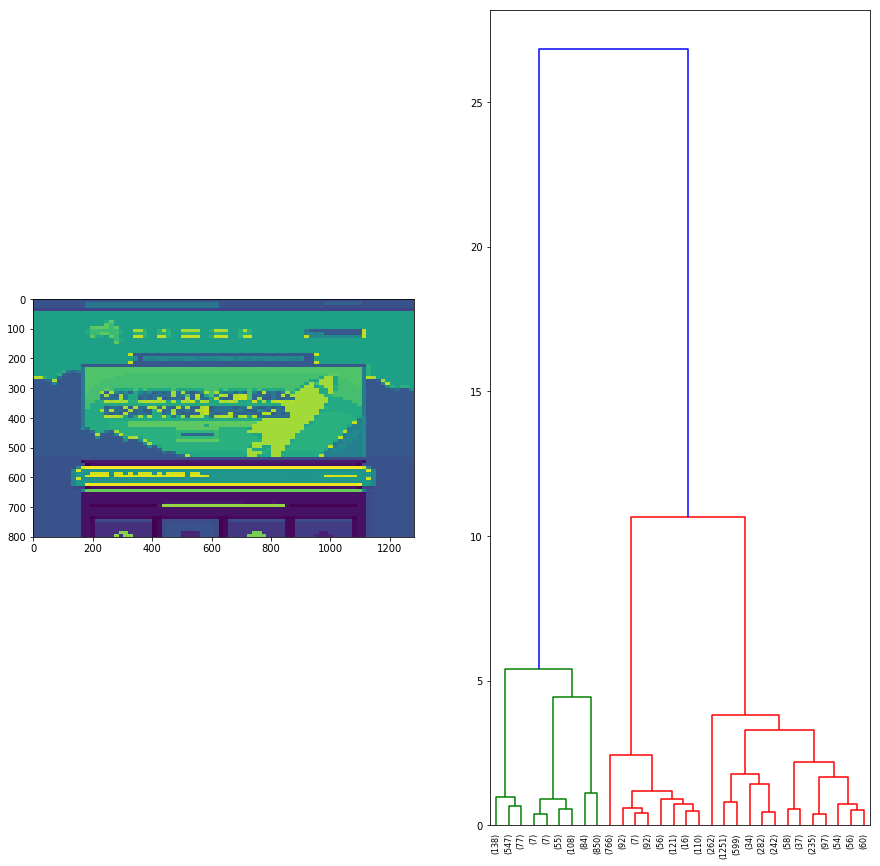

115 4.335122999411124


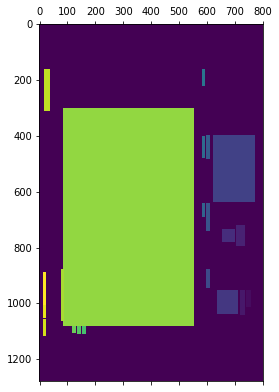

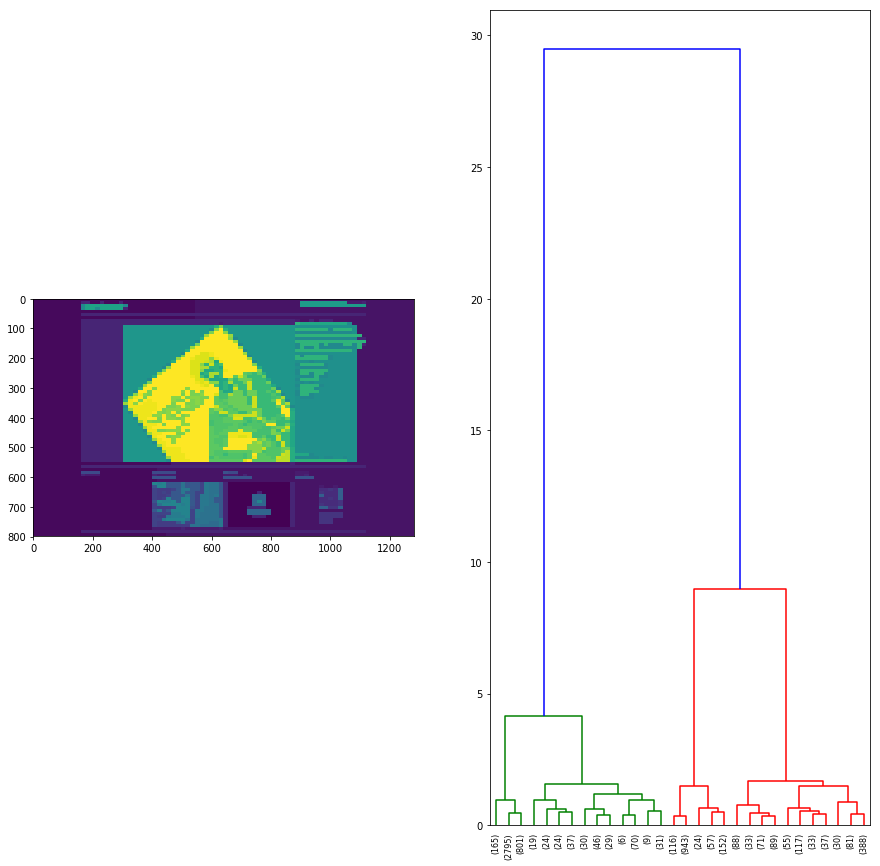

116 3.7299373111109766


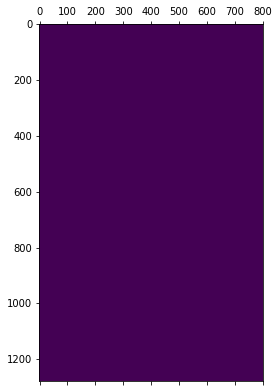

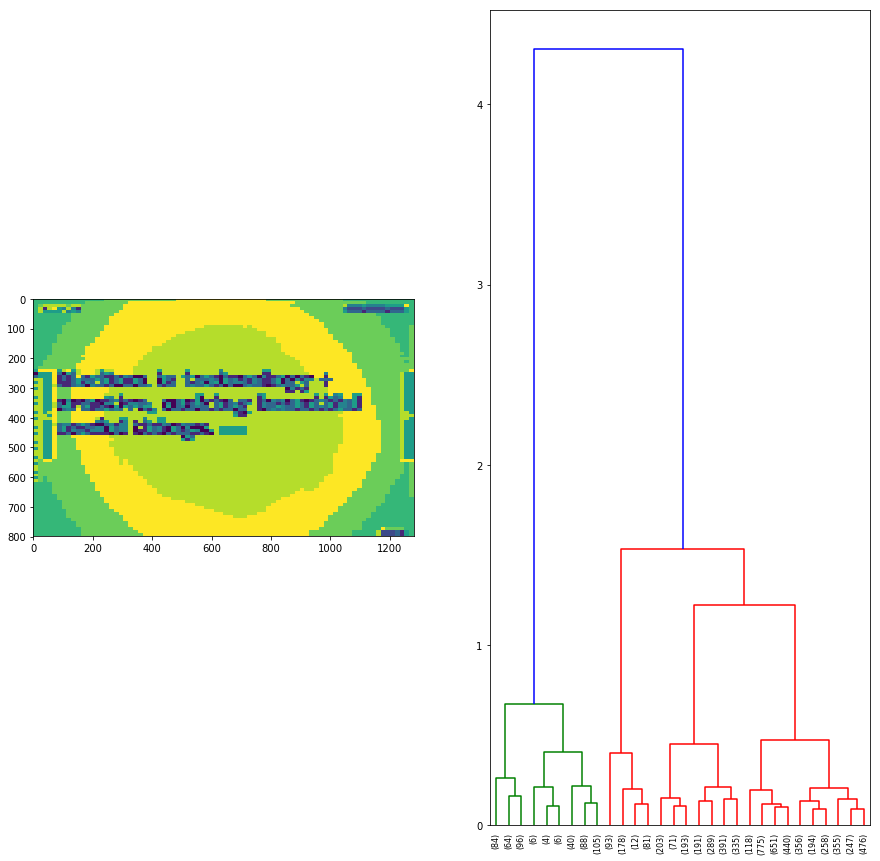

117 2.4653001125548624


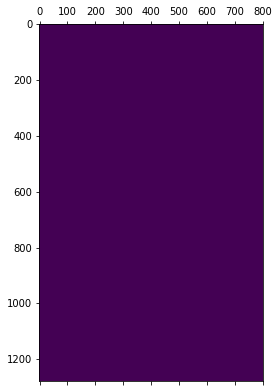

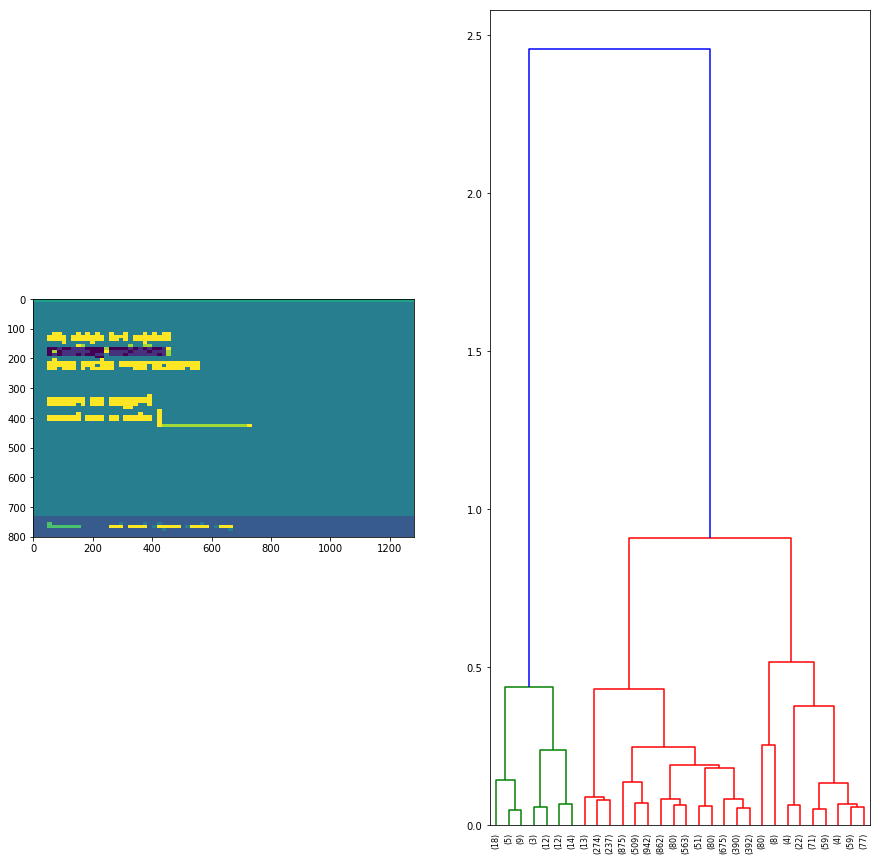

118 0.8996884186568556


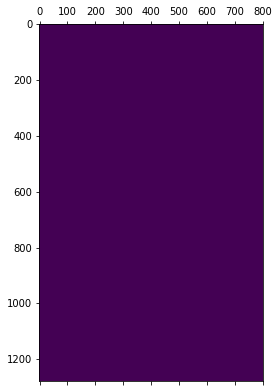

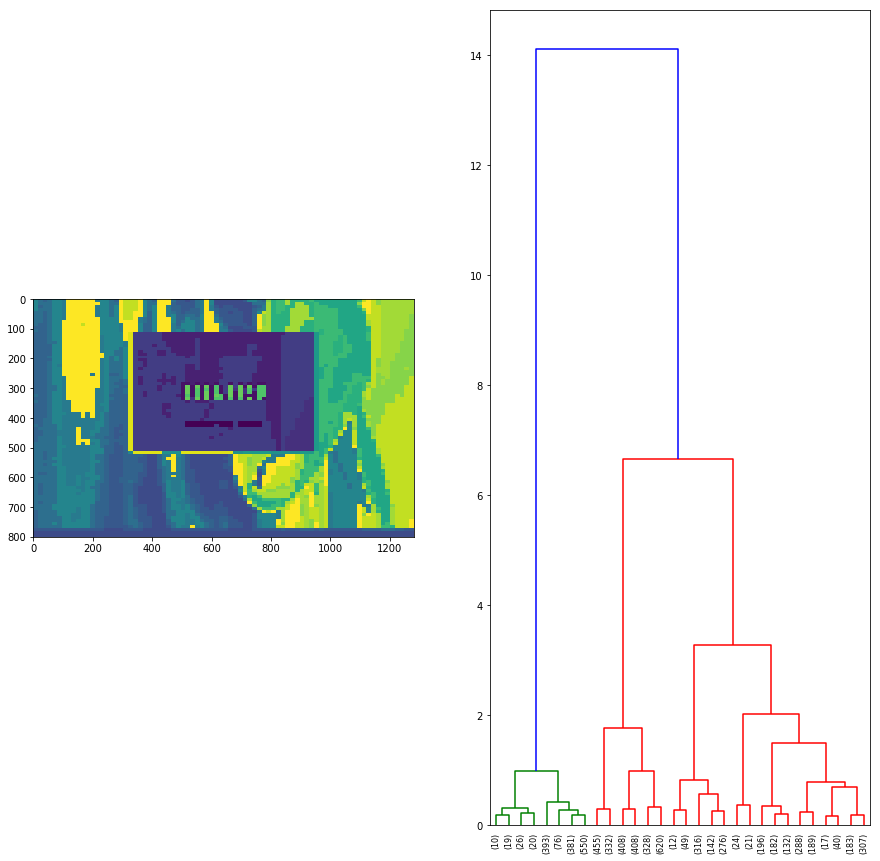

119 4.010432040536665


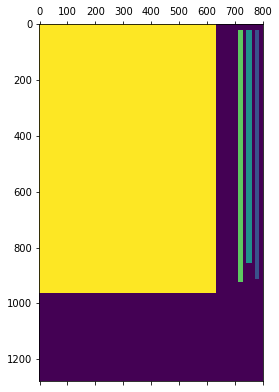

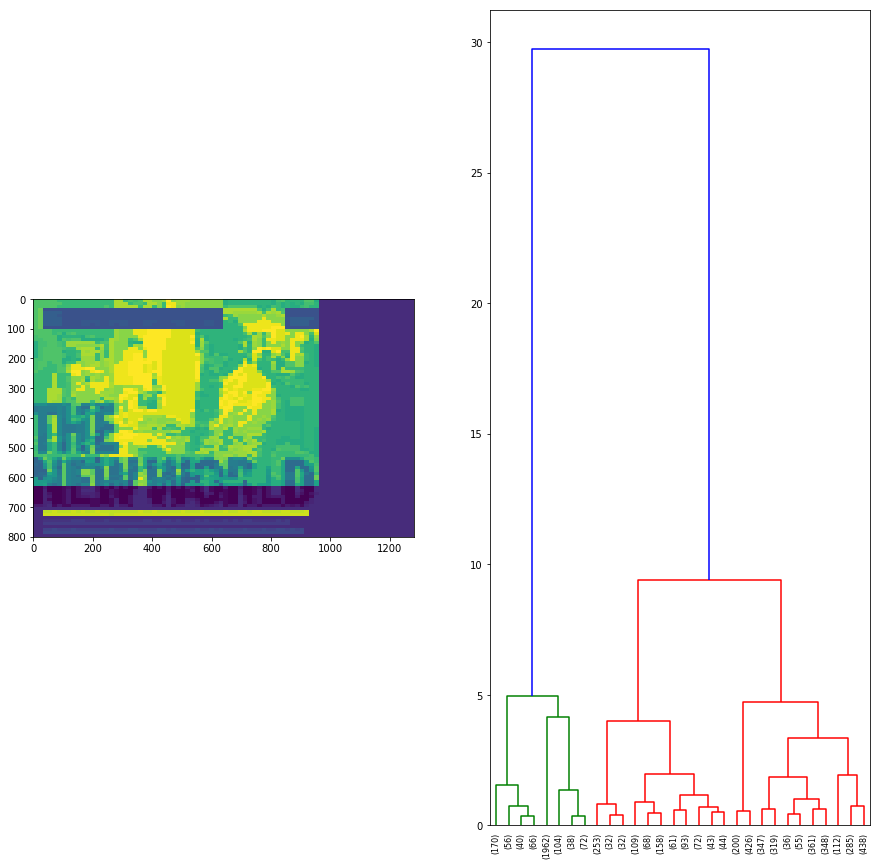

120 4.23853934088497


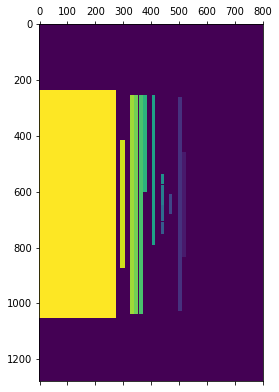

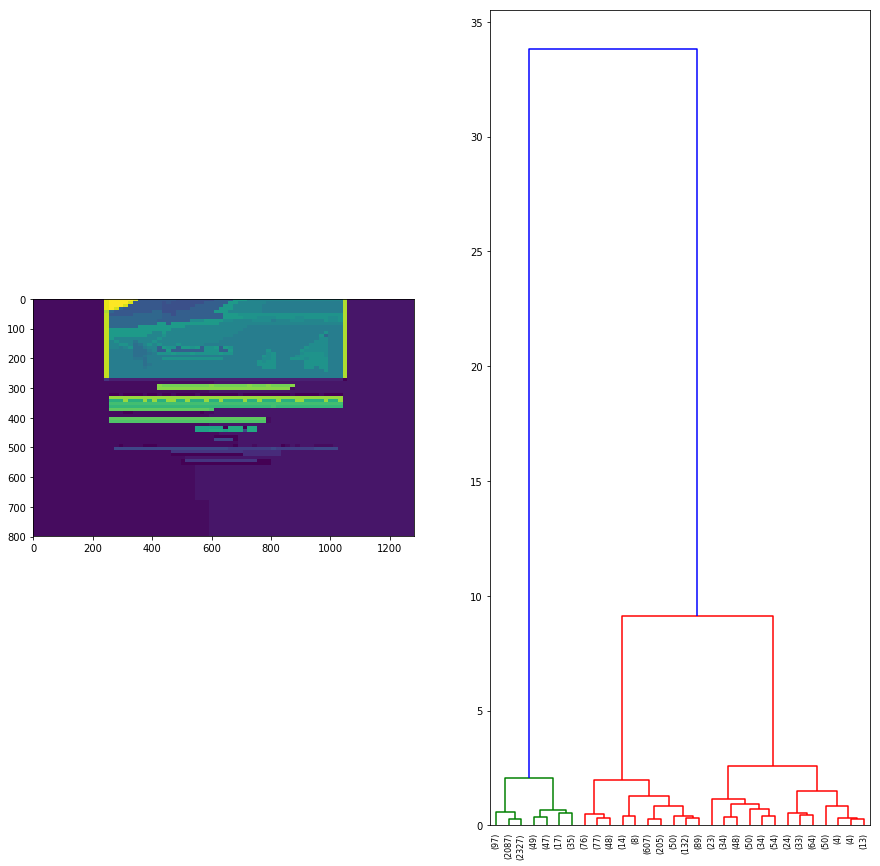

121 2.8207042991990576


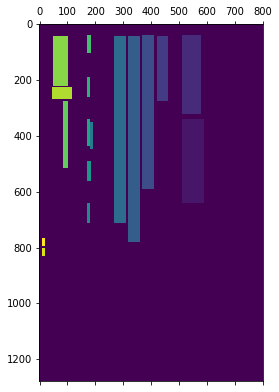

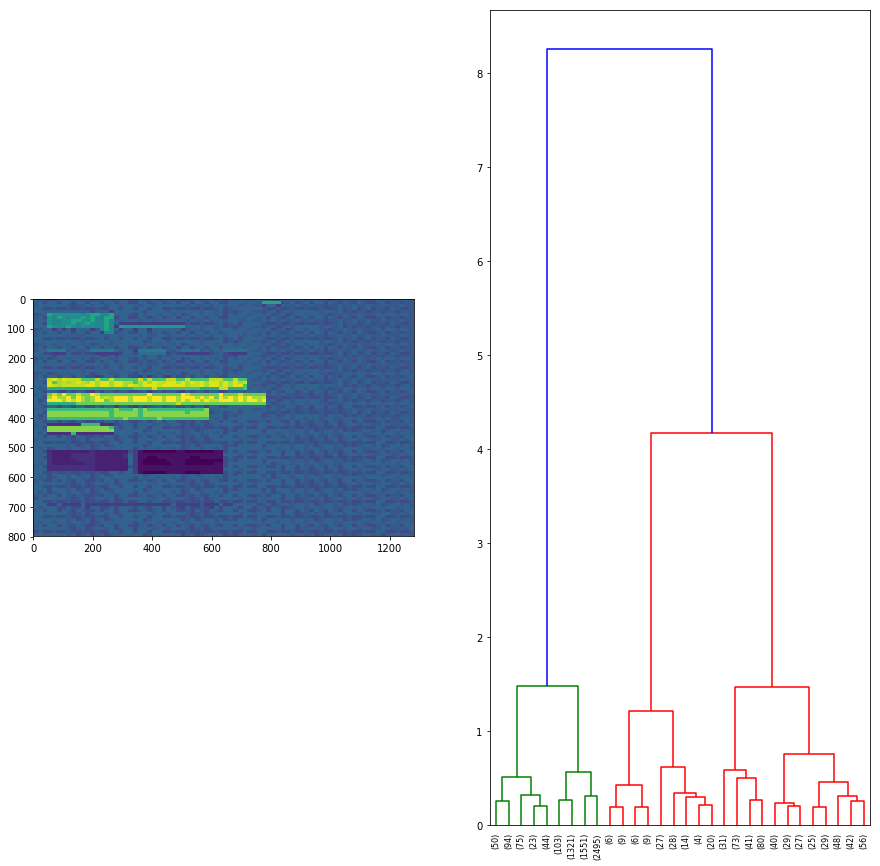

122 2.58345437269618


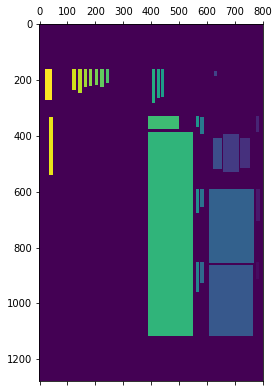

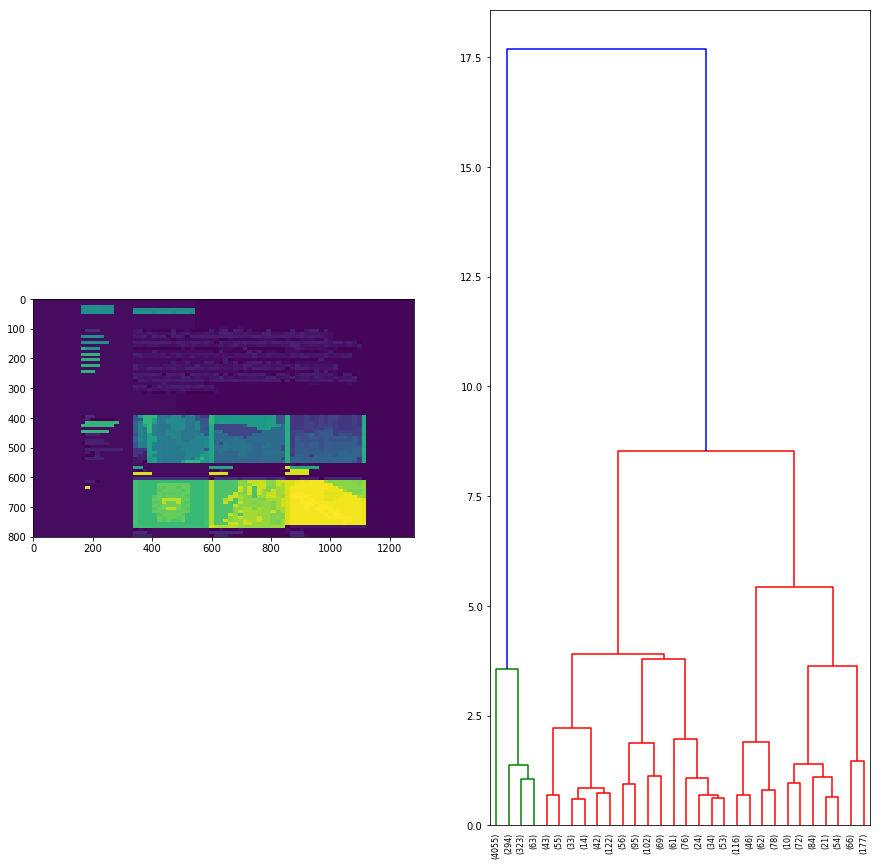

123 3.6928510571820388


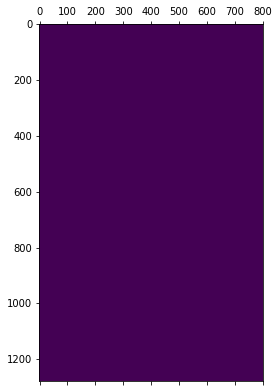

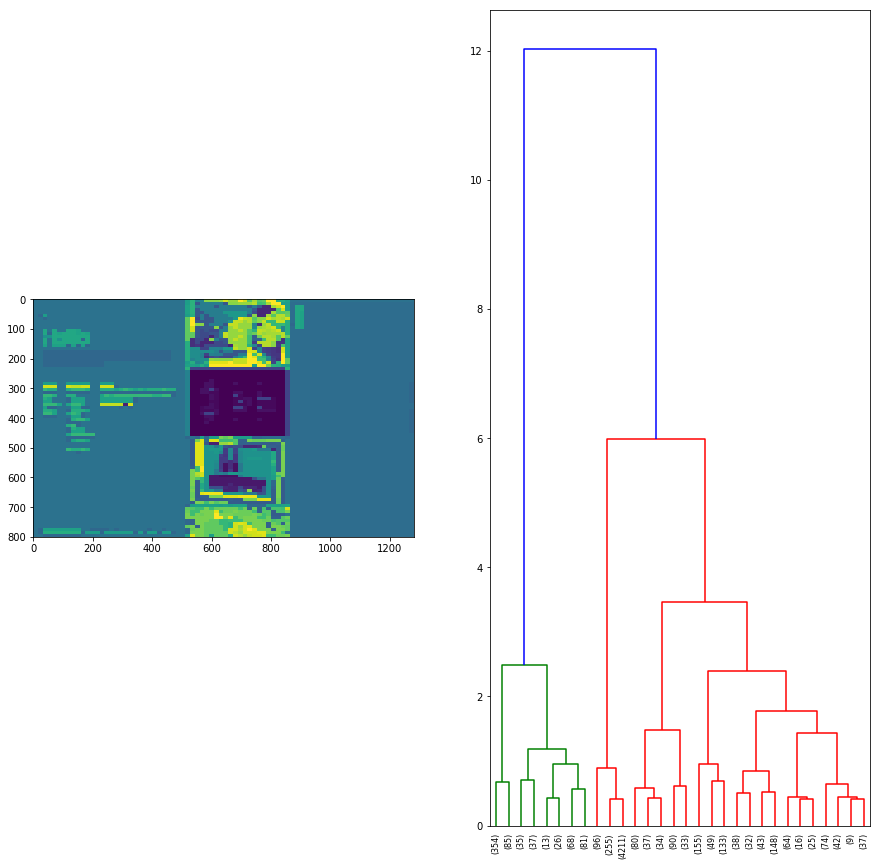

124 3.234688965916796


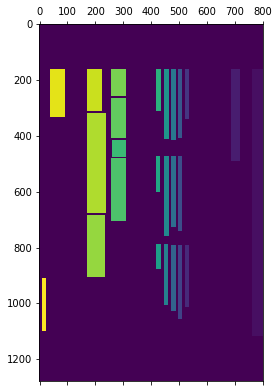

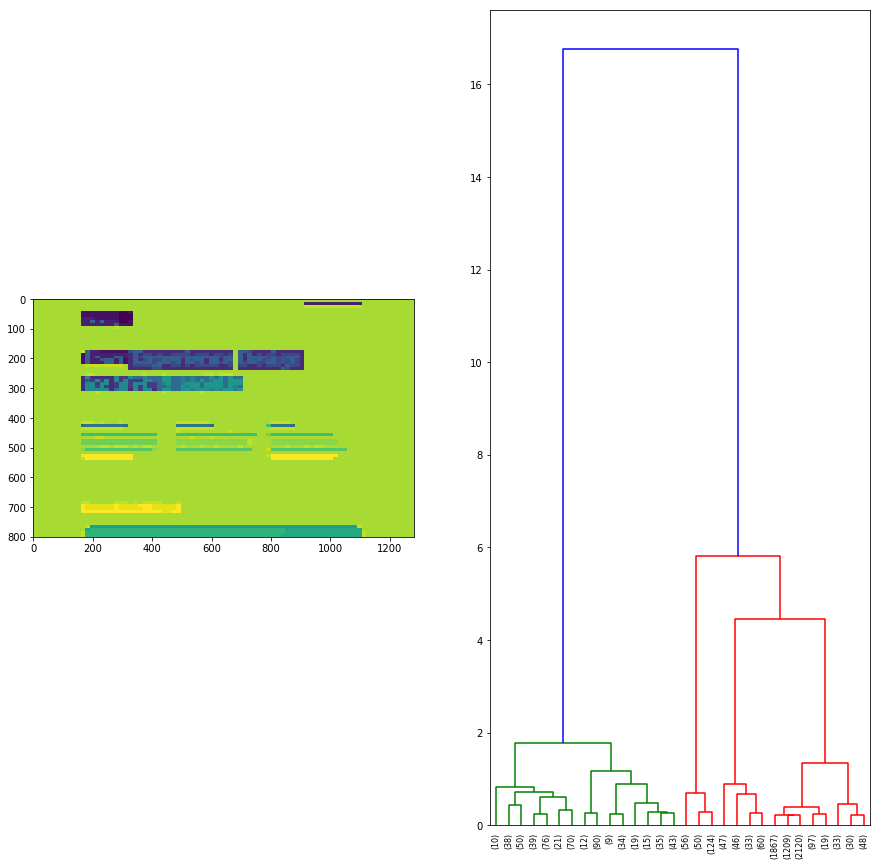

125 1.4986562753322914


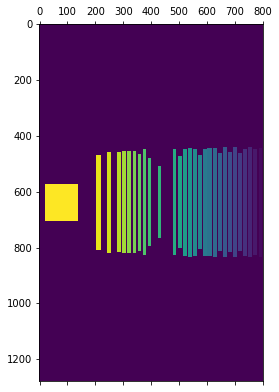

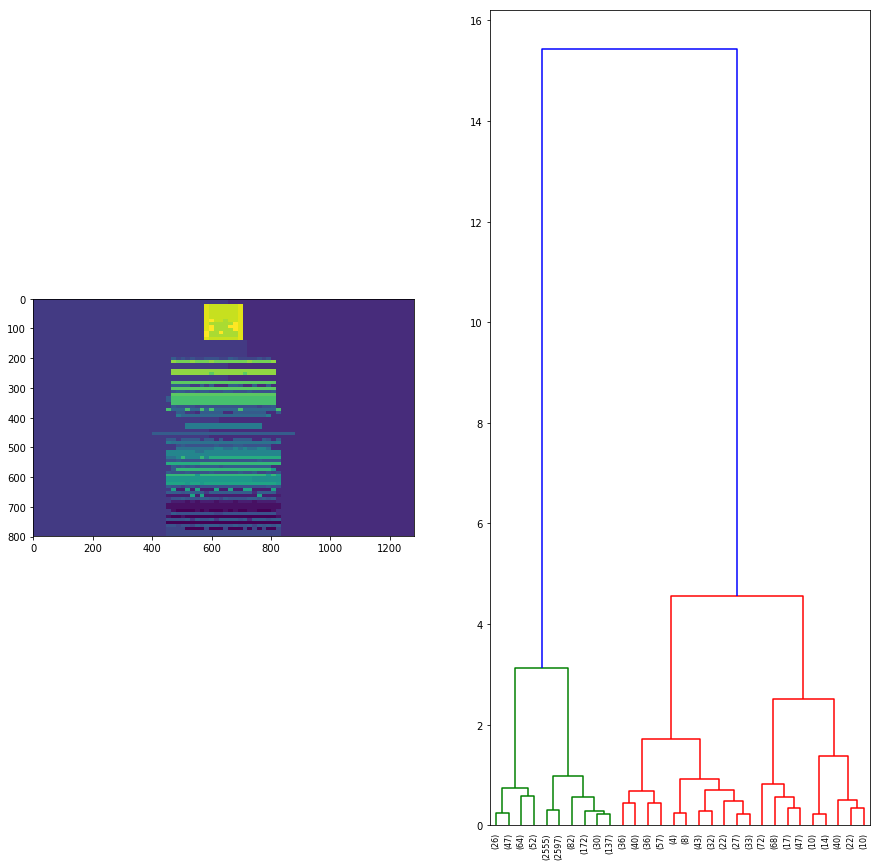

126 2.3329702530391367


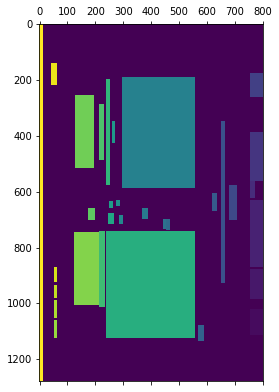

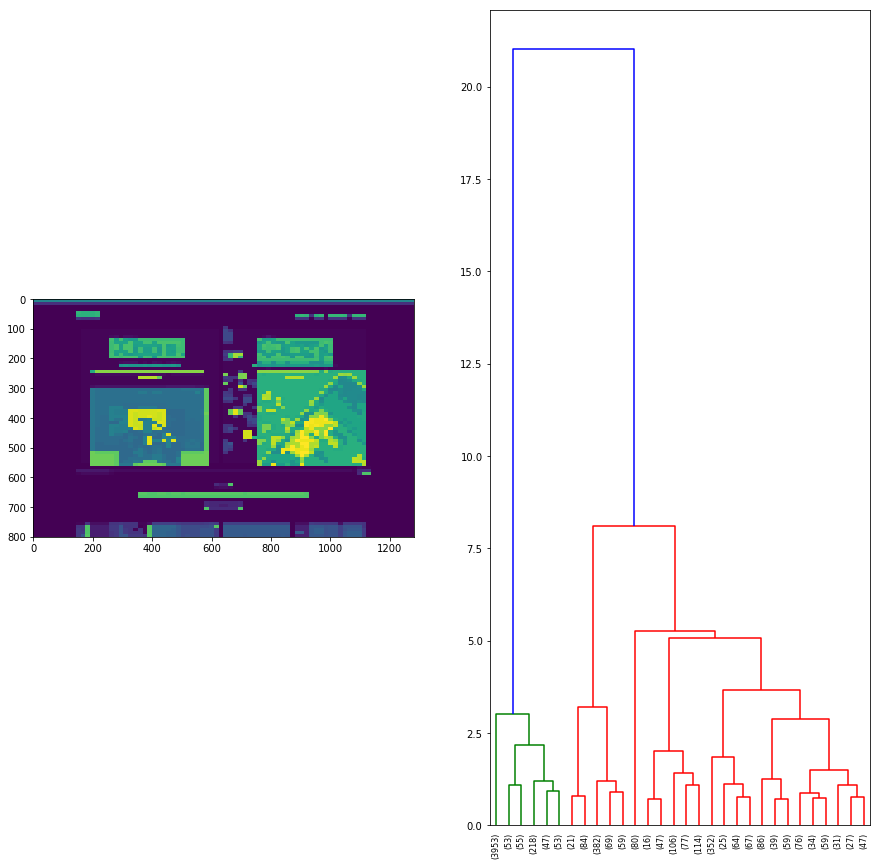

127 3.613196541900712


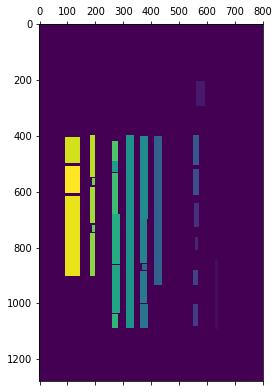

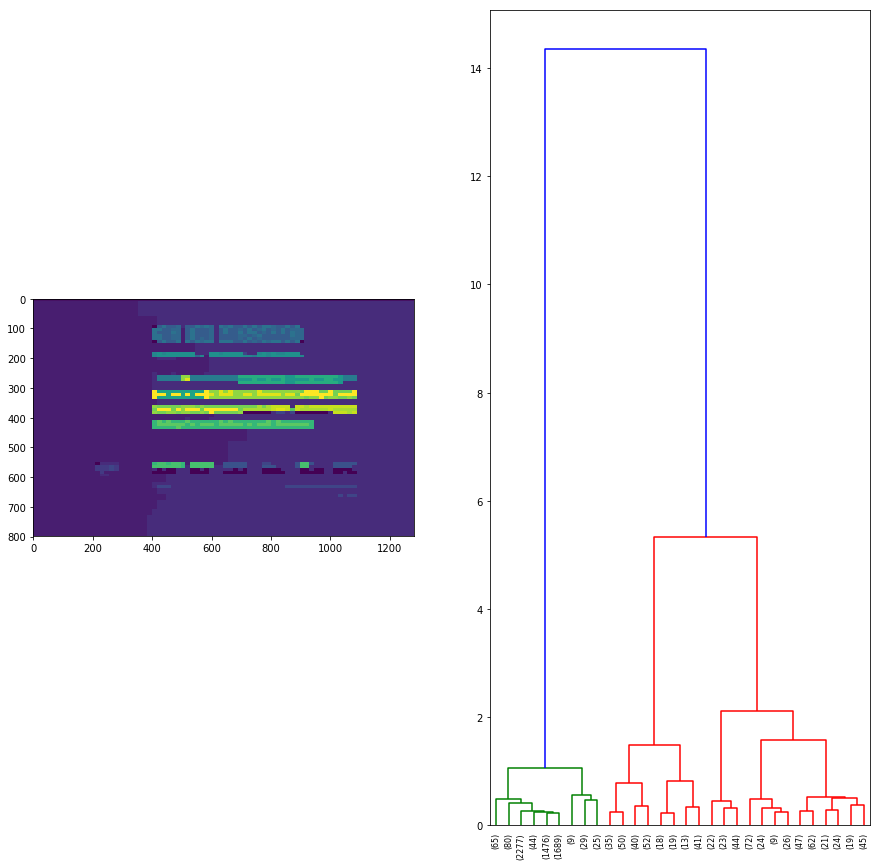

128 2.0490803062902674


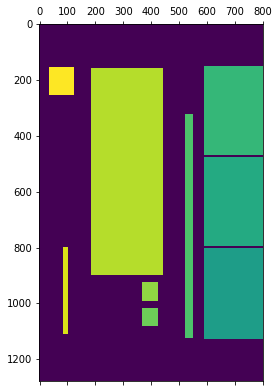

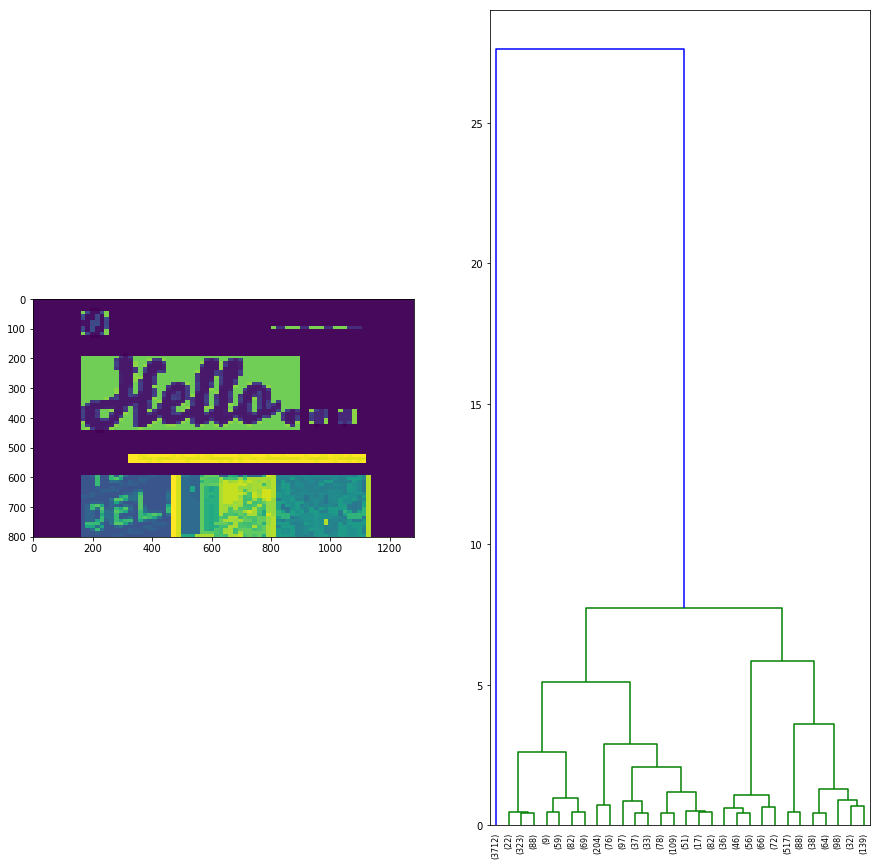

129 2.9670655241427797


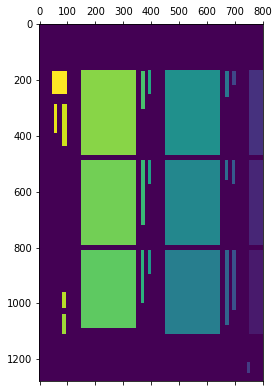

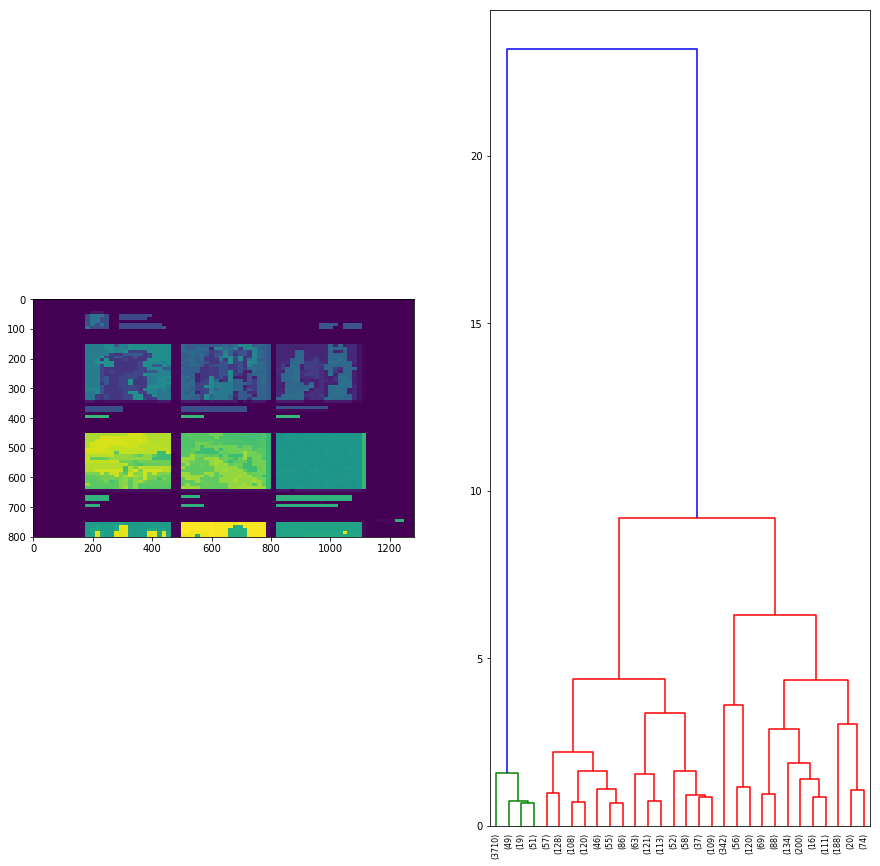

130 3.7115159339399835


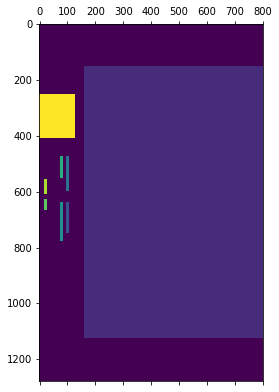

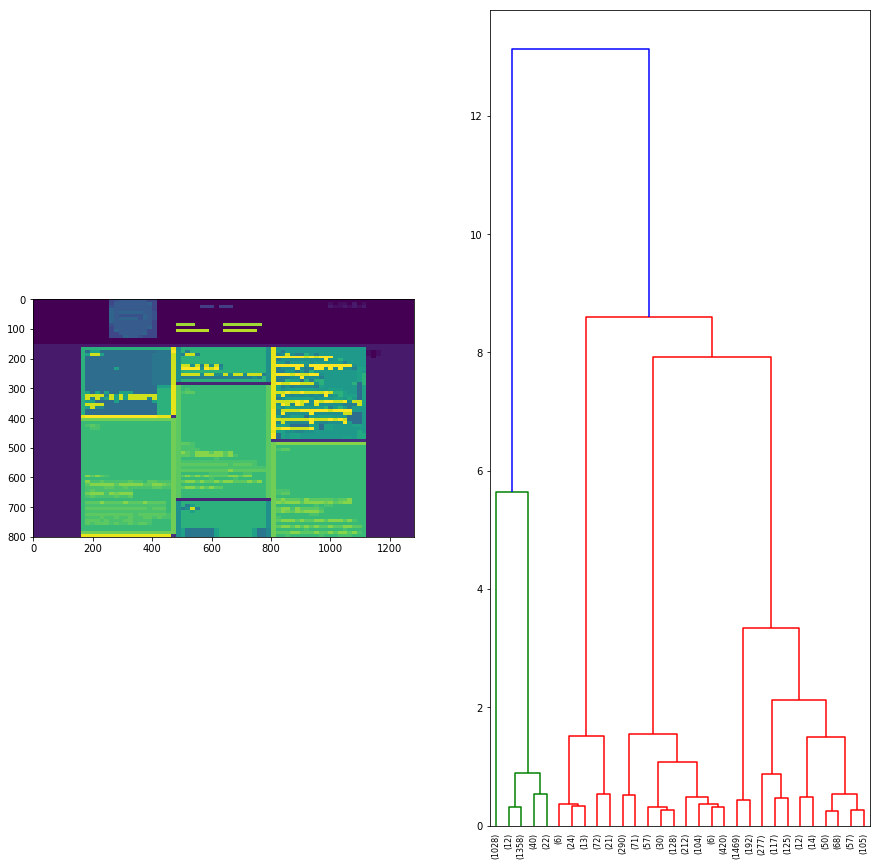

131 3.5102358792518857


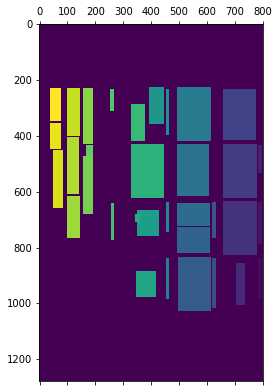

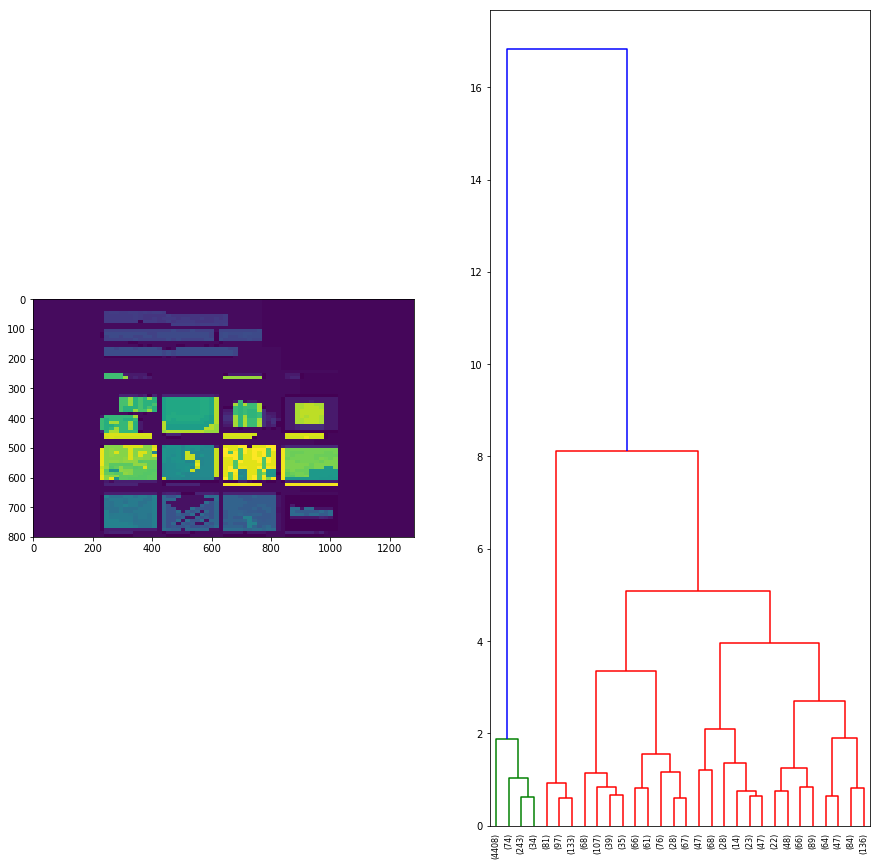

132 3.5880729348186176


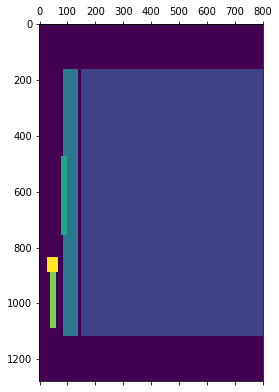

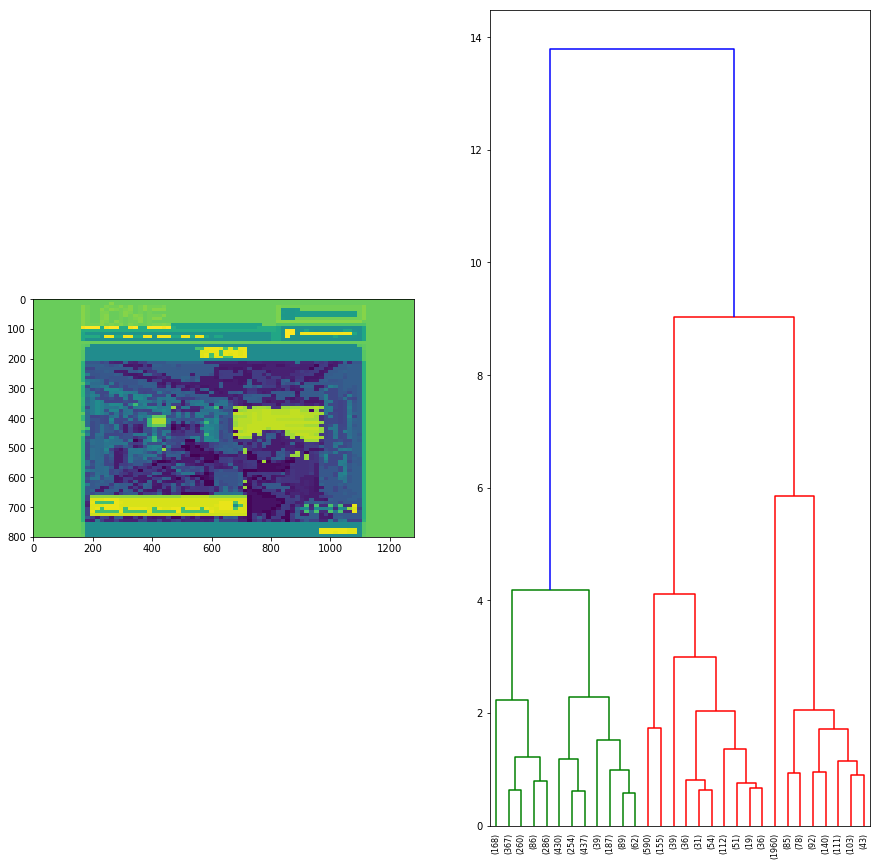

133 4.618743786796326


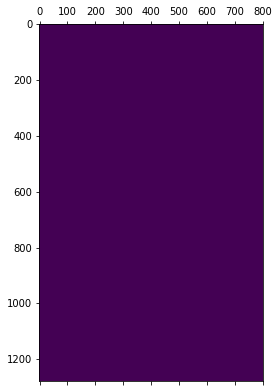

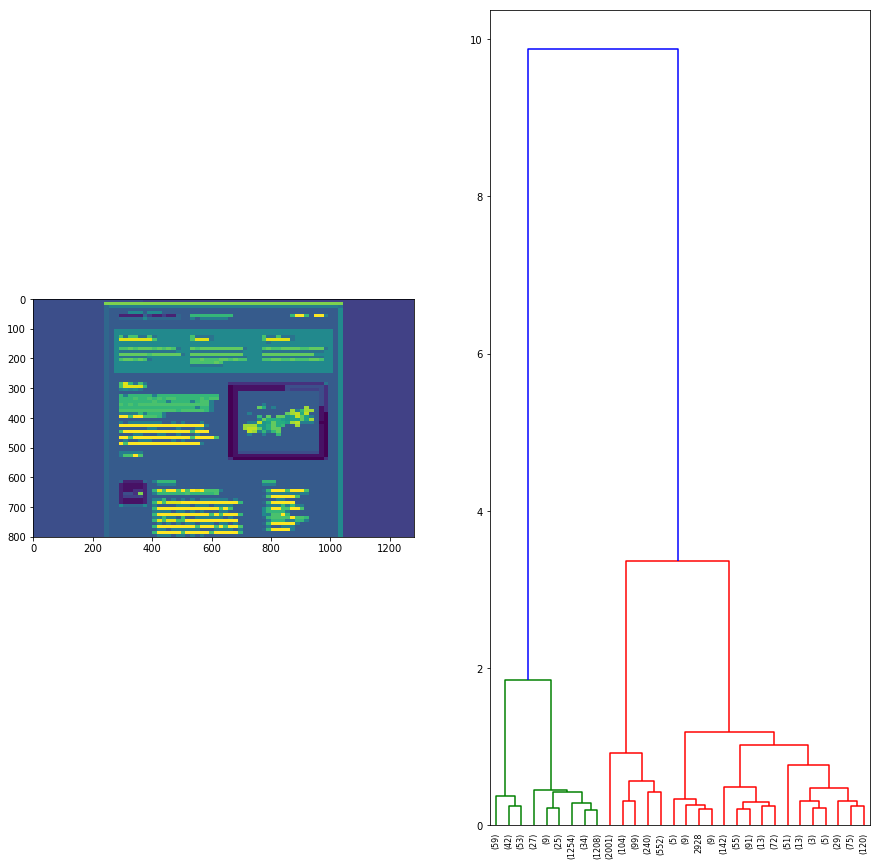

134 2.9821424317035174


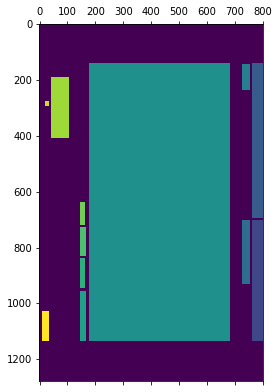

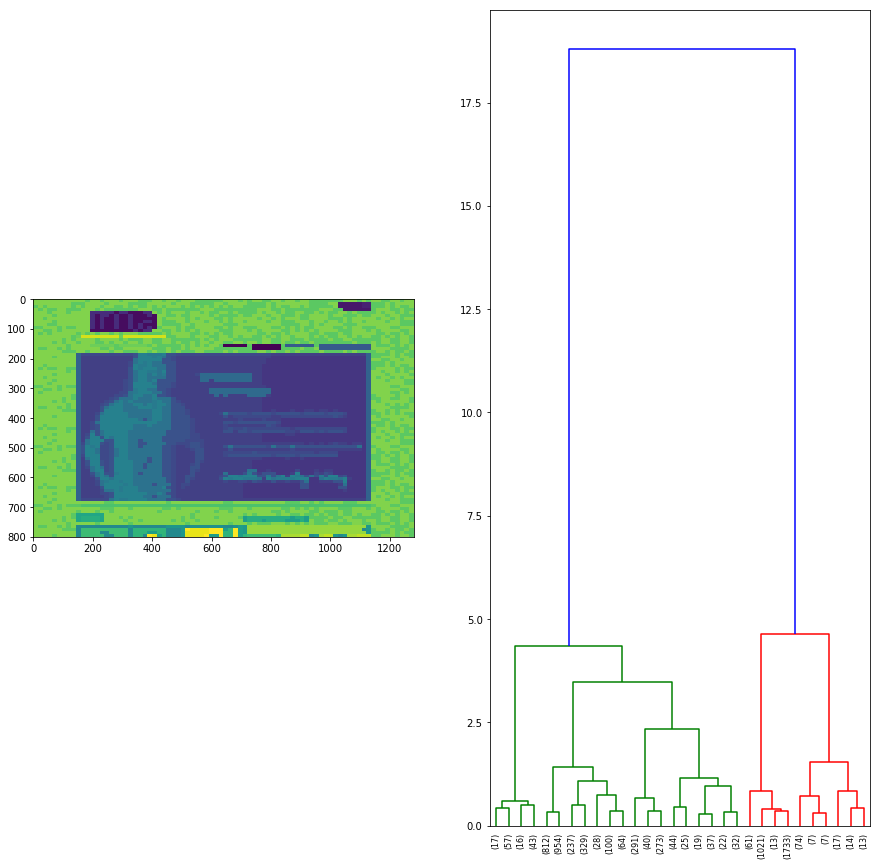

135 3.3717492177727943


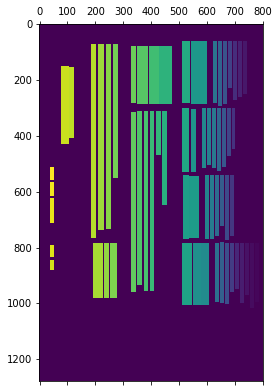

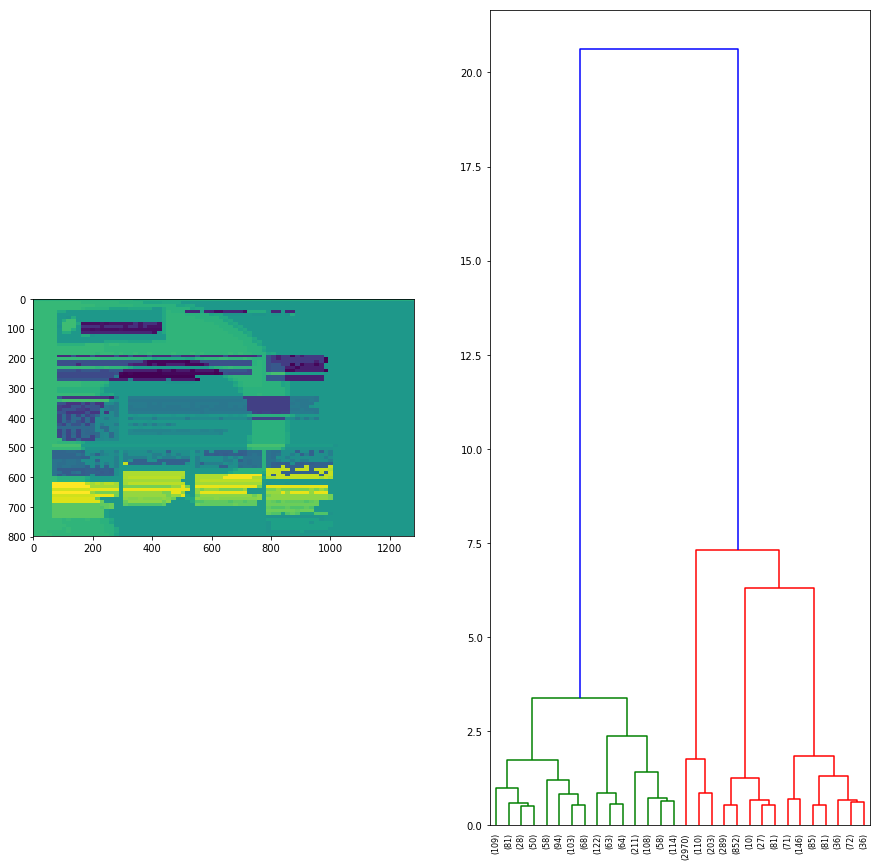

136 3.854759938514822


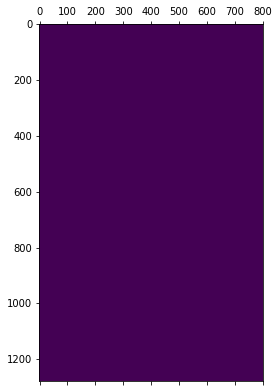

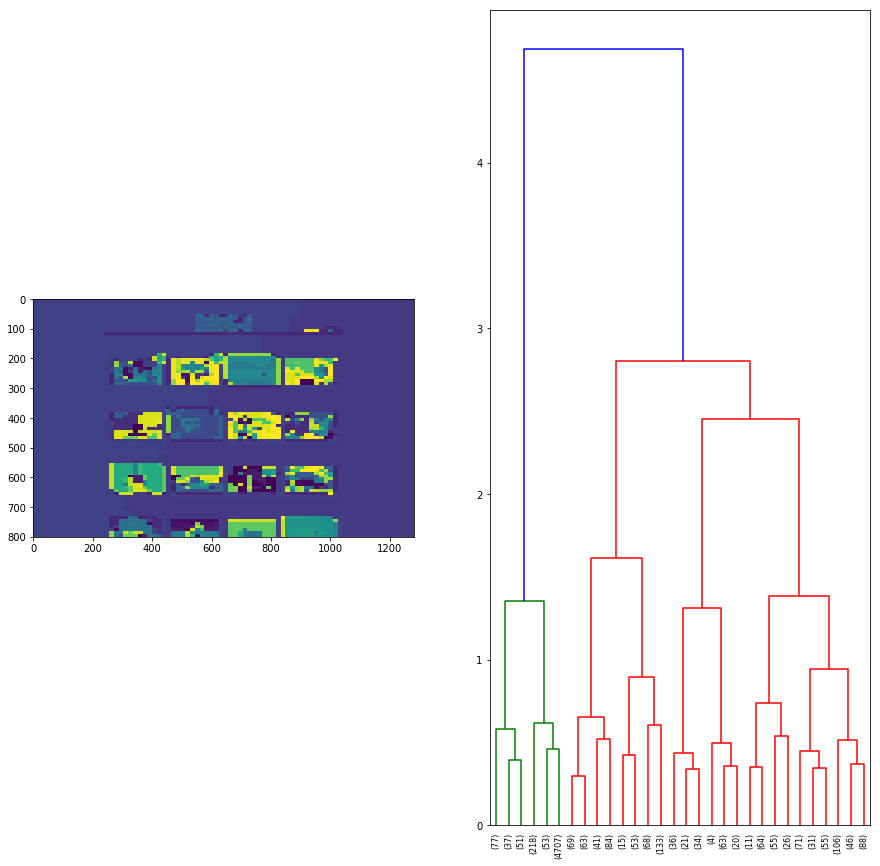

137 2.822887011377567


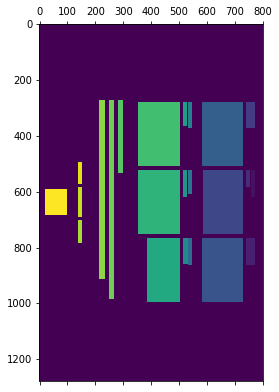

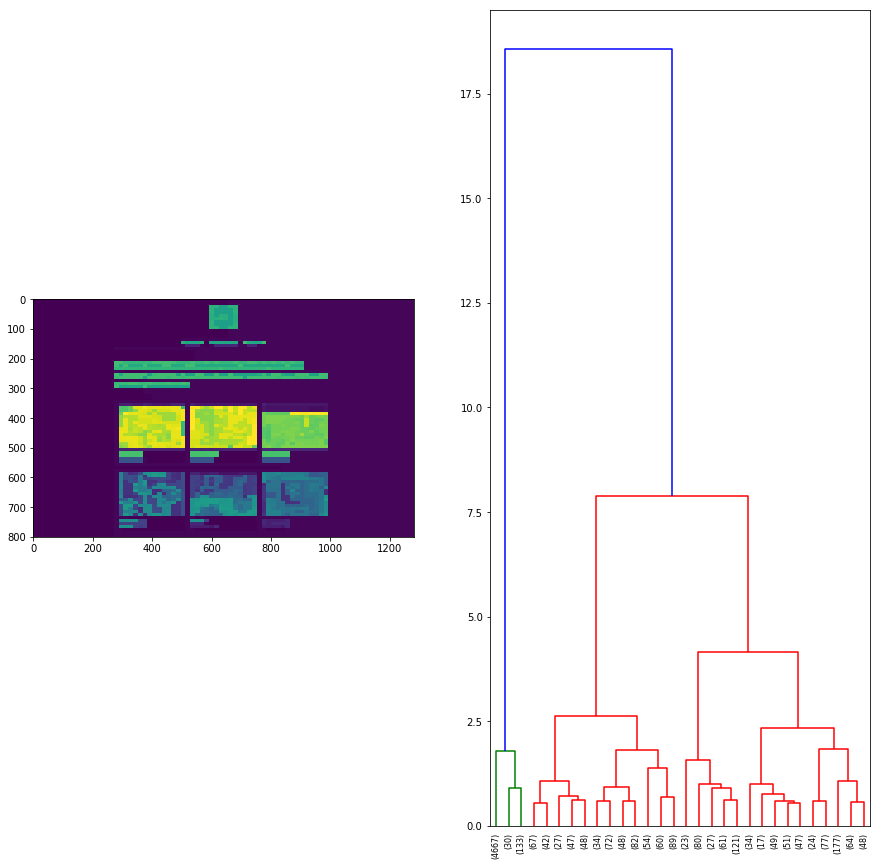

138 3.110323834861556


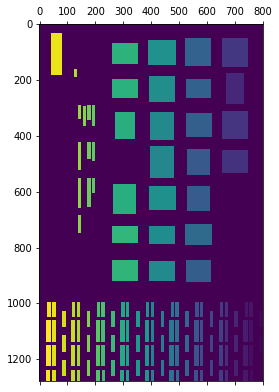

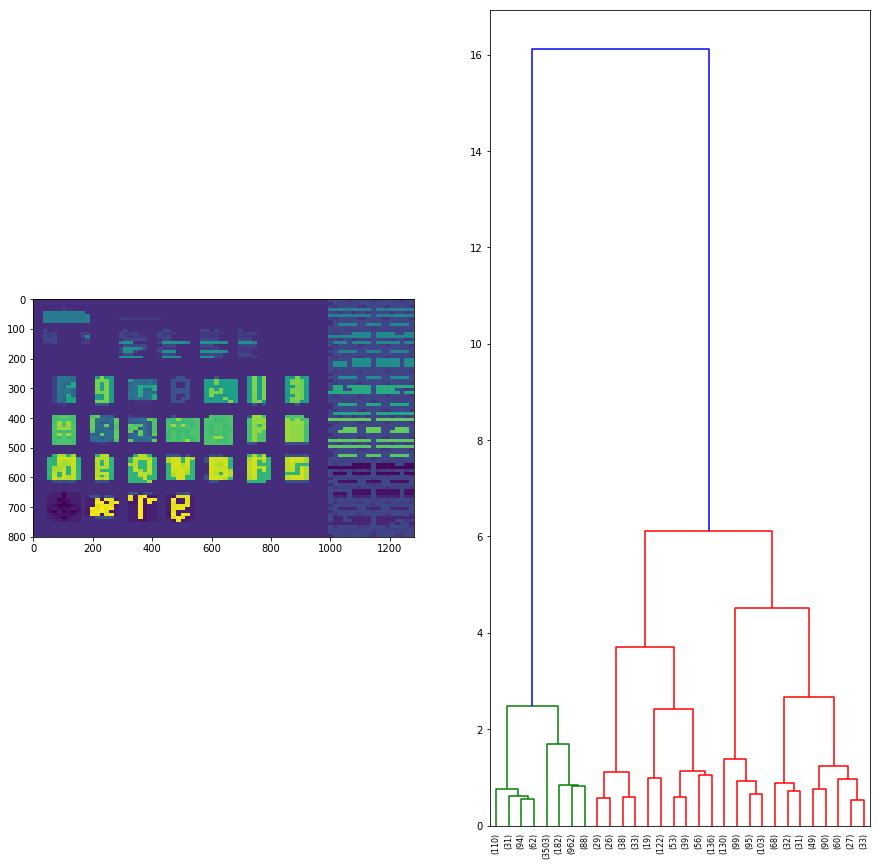

139 3.1299693772964368


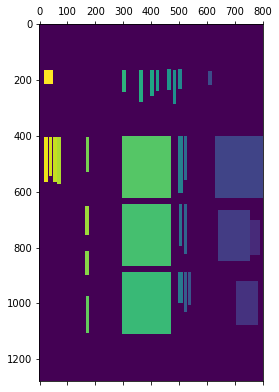

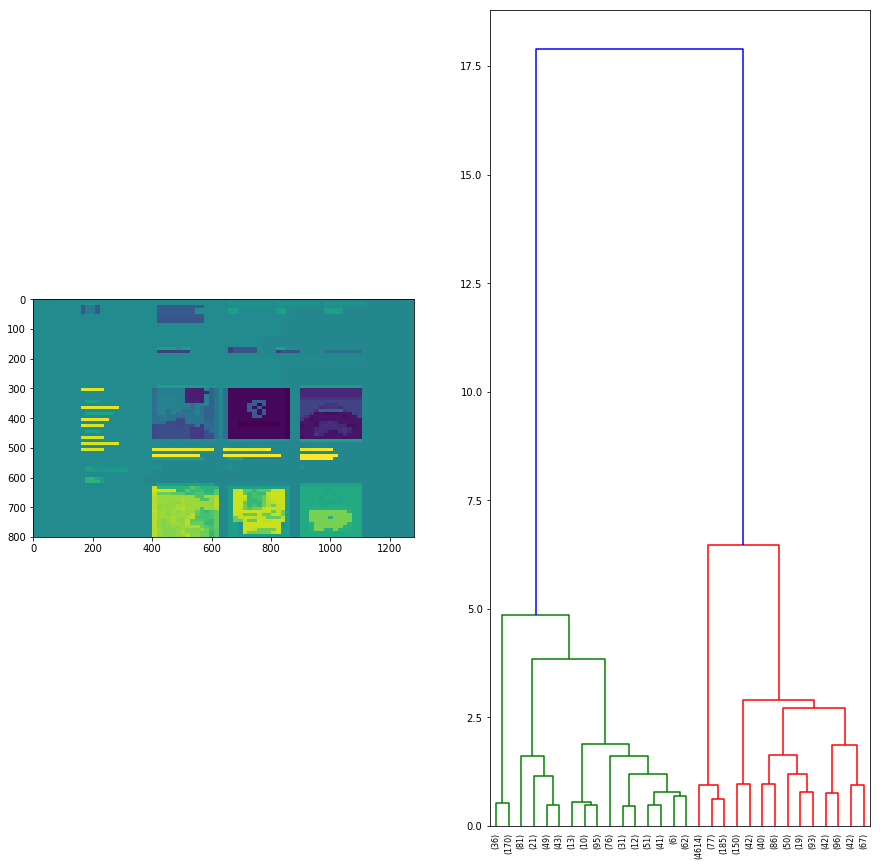

140 3.0372105554007676


([[447, 785, 32, 11],
  [503, 784, 33, 16],
  [442, 768, 38, 16],
  [705, 751, 123, 37],
  [922, 702, 157, 80],
  [667, 638, 185, 117],
  [403, 630, 221, 170],
  [173, 604, 48, 13],
  [890, 531, 117, 11],
  [891, 518, 141, 11],
  [647, 518, 179, 11],
  [403, 518, 160, 11],
  [647, 499, 151, 11],
  [890, 498, 111, 15],
  [403, 498, 206, 15],
  [166, 498, 71, 12],
  [167, 478, 124, 12],
  [166, 458, 72, 12],
  [167, 418, 76, 12],
  [167, 398, 94, 12],
  [167, 358, 114, 12],
  [167, 298, 79, 12],
  [890, 296, 221, 176],
  [647, 296, 221, 176],
  [403, 296, 221, 176],
  [977, 168, 131, 12],
  [409, 168, 122, 11],
  [815, 165, 87, 14],
  [653, 164, 105, 16],
  [409, 64, 168, 14],
  [409, 49, 161, 14],
  [409, 34, 137, 14],
  [409, 19, 161, 14],
  [167, 17, 52, 33]],
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [52]:
# Aliaksei Data

# def AliakseiTestData(w):
#     folder_path = 'file:///Users/chenwang/Documents/Manuscript/Entropy_Aesthetic/Aesthetic/webpages-am/'
#     for i in range(1, 141):
#         title = str(i)
#         childStack = []
          
#         imageMatrix, elementStack = markMatrix(childStack, title)
#         H, codeim, Z, setNum = entropyComputing(title, imageMatrix, w)
        
#         drawPic(title, codeim, Z)
#         visualRect(elementStack, title)
#         entropy_list.append([title, H, setNum])
#         entropy_dict[title] = Z
#         print(i, H) 
        
#     with open('test/entropy-aliaksei.csv', 'w') as f:
#         writer = csv.writer(f)
#         writer.writerow(['title', 'entropy', 'clustering'])
#         writer.writerows(entropy_list)
#     with open('test/z-aliaksei.pkl', 'wb') as f:
#         pickle.dump(entropy_dict, f)
        
#     return elementStack, imageMatrix
        
# w = [0.33,0.33,0.33,0.01,0.66]

# AliakseiTestData(w)       

In [99]:
# Process segmentation by Selenium
driver = webdriver.Chrome()
driver.set_window_size(windowWidth, windowHeight)

originPath = '/html/body'
path = originPath


# Weighting different metrics
w = [1,1,1,0.1,1]

# Entry
title, elementStack, imageMatrix = main(w) 

In [104]:
# Gradient Descent Fail
# weightsList = []

# def stoGradAscent(numberIter=150):
#     folder_path = 'file:///Users/chenwang/Documents/Manuscript/Entropy_Aesthetic/Aesthetic/'
#     data = pd.read_csv(folder_path + 'total.csv')
#     datad = data.groupby('title').mean().drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1).sort_values('appeal', ascending=True)
    
#     # 5 Parameters
#     para = 5
    
#     weights = np.ones(para)
#     entropy_data = pd.read_csv(folder_path + 'test/entropy.csv')
#     total = datad.join(entropy_data.set_index('title')).dropna()
    
#     dataIndex = range(len(total))
#     entropyRange = int(max(total['entropy']))+1
    
#     for j in range(numberIter):
#         for i in dataIndex:
#             alpha = 4/(1.0+j+i) + 0.01
#             randIndex = int(np.random.uniform(0, len(dataIndex)))
#             no, title = infiles[randIndex].split('*')
#             h = main(weights, title)
# #             entropy_data = pd.read_csv(folder_path + 'test/entropy.csv')
# #             total = datad.join(entropy_data.set_index('title')).dropna()
#             error = total['appeal'][title] - h
#             print(error)
#             print(- alpha * total['entropy'][title] * error)
#             weights = weights - alpha * total['entropy'][title] * error
#             print(weights)
#             weightsList.append(weights)
    
#     with open('test/weights.pkl', 'wb') as f:
#         pickle.dump(weightsList, f)
        
# #     plt.figure()
# #     ax = fig.add_subplot(151)
# #     plt.plot(range(80),weightsList)
# #     plt.show()
    
#     return weights
 
# weights = stoGradAscent()
# print('Final:')
# print(weights)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


-1.4372432992851727
12.497362150340603
[13.49736215 13.49736215 13.49736215 13.49736215 13.49736215]
-2.5333205518783664
8.042825273653577
[21.54018742 21.54018742 21.54018742 21.54018742 21.54018742]


KeyboardInterrupt: 

In [ ]:
# entropy_list
# len(entropy_list)

# imageMatrix=imageMatrix_elementStack_pickle['cvpr2018.thecvf.com']['imageMatrix']
# matshow(imageMatrix)
# plt.show()